In [1]:
import json
import pandas as pd
import numpy as np
import re
import csv
import sys
import matplotlib.pyplot as plt
from pandas.core.common import flatten
from Levenshtein import distance
import matplotlib as mpl

In [3]:
# Import with Conda to prevent the Kernel from dying all the time

import sys
!conda install --yes --prefix {sys.prefix} Levenshtein

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are not available from current channels:

  - levenshtein

Current channels:

  - https://repo.anaconda.com/pkgs/main/osx-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/osx-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




In [2]:
Neighborhoods_df = pd.read_excel("Revised Sub-Neighborhoods.xlsx")
Neighborhoods_df

Census Tract#       Zipcode   Neighborhood US Geonames Sub-neigborhood  \
0             1.00  02134, 02135       Brighton                         NaN   
1             2.01         02135       Brighton                         NaN   
2             2.02         02135       Brighton                         NaN   
3             3.01         02135       Brighton                         NaN   
4             3.02         02135       Brighton                         NaN   
..             ...           ...            ...                         ...   
176        9815.02         02151    East Boston                         NaN   
177        9816.00         02128    East Boston                         NaN   
178        9817.00         02116    Beacon Hill                         NaN   
179        9818.00  02130, 02215  Jamaica Plain                         NaN   
180        9901.01         02130            NaN                         NaN   

     Total Population   Black  Black Proportion  White  White Proportion  \
0                5324     311          0.058415   3315          0.622652   
1                3991     237          0.059384   3164          0.792784   
2                4272     263          0.061564   3031          0.709504   
3                2946     216          0.073320   2203          0.747794   
4                3469     359          0.103488   2346          0.676276   
..                ...     ...               ...    ...               ...   
176                 0       0          0.000000      0          0.000000   
177                 0       0          0.000000      0          0.000000   
178                 0       0          0.000000      0          0.000000   
179                26       9          0.346154     17          0.653846   
180                67      18          0.268657     49          0.731343   

     American Indian & Alaska Native  ...  Male   Male Proportion  Female   \
0                                  0  ...   2578         0.484222     2746   
1                                 17  ...   1800         0.451015     2191   
2                                  0  ...   2175         0.509129     2097   
3                                  0  ...   1650         0.560081     1296   
4                                 25  ...   1733         0.499568     1736   
..                               ...  ...    ...              ...      ...   
176                                0  ...      0         0.000000        0   
177                                0  ...      0         0.000000        0   
178                                0  ...      0         0.000000        0   
179                                0  ...      4         0.153846       22   
180                                0  ...     55         0.820896       12   

     Female Proportion         Lat       Long  Primary Sub-Neighborhood  \
0              0.515778  42.361485 -71.138588             Lower Allston   
1              0.548985  42.354066 -71.161168                Oak Square   
2              0.490871  42.352605 -71.154344                Oak Square   
3              0.439919  42.354144 -71.168827             Hunnwell Hill   
4              0.500432  42.347258 -71.167686                  Brighton   
..                  ...        ...        ...                       ...   
176            0.000000  42.396367 -71.004379                 Beachmont   
177            0.000000  42.388621 -70.993442            Orient Heights   
178            0.000000  42.355087 -71.065743         Downtown Crossing   
179            0.846154  42.323121 -71.116882          High Street Hill   
180            0.179104  42.329611 -70.949200                       NaN   

     Secondary Sub-Neighborhood  Teritriary Sub-Neighborhood(s)  \
0                       Allston                Packard's Corner   
1                      Brighton                  Hunnewell Hill   
2                      Brighton                         Allston   
3                    Oak Square      

In [5]:
data_df_2014 = pd.read_csv("bostonglobe2014.csv")
data_df_2015 = pd.read_csv("bostonglobe2015.csv")
data_df_2016 = pd.read_csv("bostonglobe2016.csv")
data_df_2017 = pd.read_csv("bostonglobe2017.csv")
data_df_2018 = pd.read_csv("bostonglobe2018.csv")


data_df_final = pd.concat([data_df_2014, data_df_2015, data_df_2016, data_df_2017, data_df_2018], ignore_index=True)
data_df_final


text
0      ['The Boston Police Department has issued a co...
1      ['\n individuals who worked in finance, insura...
2      ['Dr. Kenneth C. Edelin, whose historic 1975 m...
3      ['The first words in the Bible are “In the beg...
4      ['When they go up, they form the centerpiece o...
...                                                  ...
22903  ['\n\n\n fair. After years of bad policy decis...
22904  ['The governor, the mayor, the head of the Mas...
22905  ['The number of students disciplined in school...
22906  ['Hundreds of species are facing extinction du...
22907  ['Boston will record its warmest December in m...

[22908 rows x 1 columns]

In [6]:
# Cleaning the articles for 
spec_chars = ["!",'"',"#","%","&","'","(",")",
              "*","+",",","-",".","/",":",";","<",
              "=",">","?","@","[","\\","]","^","_",
              "`","{","|","}","~","–", "\xc2", "\xa0",
             "\x80", "\x9c", "\x99", "\x94", "\xad", "\xe2", "\x9d"]

for char in spec_chars:
    data_df_final['text'] = data_df_final['text'].str.replace(char, ' ')
    
data_df_final

text
0        The Boston Police Department has issued a co...
1         n individuals who worked in finance  insura...
2        Dr  Kenneth C  Edelin  whose historic 1975 m...
3        The first words in the Bible are “In the beg...
4        When they go up  they form the centerpiece o...
...                                                  ...
22903     n n n fair  After years of bad policy decis...
22904    The governor  the mayor  the head of the Mas...
22905    The number of students disciplined in school...
22906    Hundreds of species are facing extinction du...
22907    Boston will record its warmest December in m...

[22908 rows x 1 columns]

In [9]:
Neighborhood_all = Neighborhoods_df["Secondary Sub-Neighborhood"]
Neighborhood_all = Neighborhood_all.astype(str)
#Neighborhood_all = Neighborhood_all.drop_duplicates(keep = False, inplace = True) 
Primary_sub=[]

for sub in Neighborhood_all:
    if sub != "nan":
        Primary_sub.append(sub)
    
print(Primary_sub)

['Allston', 'Brighton', 'Brighton', 'Oak Square', "St. Elizabeth's", 'Oak Square', 'Brighton', 'Fisher Hill', 'Salisbury Road-Corey Farm', 'Aberdeen', 'Allston', 'Aberdeen', 'Corey Hill', 'Lower Alston', 'Cambridgeport', "Packard's Corner", 'Fenway-Kenmore', 'Fenway-Kenmore', 'Cottage Farm Historic District', 'Medical Center Area', 'Columbus', 'South End', 'Kenmore', 'Fenway-Kenmore', 'Columbus', 'Columbus', 'East Cambridge', 'Bay Village', 'East Cambridge', 'Waterfront', 'Medford Street/The Neck', 'West End', 'West End', 'Waterfront', 'Bunker Hill', 'Waterfront', 'Charlestown', 'Charlestown', 'Medford Street/The Neck', 'Inner Belt', 'Medford Street/The Neck', 'Admirals Hill', 'Central Square', 'Jeffries Point', 'Jerffries Point', 'Jerffries Point', 'East Boston', 'Central Square', 'Chelsea', 'Chelsea', 'Winthrop', 'Central Maverick Square/Paris Street', 'Telegraph Hill', 'City Point', 'City Point', 'City Point', 'D Street/West Broadway', 'Fort Point', 'South Boston', 'Columbus Park / 

In [10]:
Primary_sub_split=[]

for sub in Neighborhood_all:
    if sub != "nan":
        Primary_sub_split.extend(sub.split("/"))
    
print(Primary_sub_split)



['Allston', 'Brighton', 'Brighton', 'Oak Square', "St. Elizabeth's", 'Oak Square', 'Brighton', 'Fisher Hill', 'Salisbury Road-Corey Farm', 'Aberdeen', 'Allston', 'Aberdeen', 'Corey Hill', 'Lower Alston', 'Cambridgeport', "Packard's Corner", 'Fenway-Kenmore', 'Fenway-Kenmore', 'Cottage Farm Historic District', 'Medical Center Area', 'Columbus', 'South End', 'Kenmore', 'Fenway-Kenmore', 'Columbus', 'Columbus', 'East Cambridge', 'Bay Village', 'East Cambridge', 'Waterfront', 'Medford Street', 'The Neck', 'West End', 'West End', 'Waterfront', 'Bunker Hill', 'Waterfront', 'Charlestown', 'Charlestown', 'Medford Street', 'The Neck', 'Inner Belt', 'Medford Street', 'The Neck', 'Admirals Hill', 'Central Square', 'Jeffries Point', 'Jerffries Point', 'Jerffries Point', 'East Boston', 'Central Square', 'Chelsea', 'Chelsea', 'Winthrop', 'Central Maverick Square', 'Paris Street', 'Telegraph Hill', 'City Point', 'City Point', 'City Point', 'D Street', 'West Broadway', 'Fort Point', 'South Boston', 'C

In [15]:
#def Neighborhood_Search(terms):
    #df_search = data_df_final[data_df_final['text'].str.contains(terms, na=False)]
    #return (terms, df_search["text"].shape[0])

S_nlist = []

for n in Primary_sub_split:
    S_nlist.append(Neighborhood_Search(n))
#print(S_nlist)
Names = []
Count = []
for x in S_nlist:
    Names.append(x[0])
for num in S_nlist:
    Count.append(num[1])
    
#print(Names)

Neighborhoods_data = {'Name': Names,
        'Count': Count
        }
df_neigh = pd.DataFrame(Neighborhoods_data, columns = ['Name', 'Count'])
df_neigh.drop_duplicates()

Name  Count
0              Allston    540
1             Brighton    768
3           Oak Square     17
4      St. Elizabeth's      0
7          Fisher Hill      4
..                 ...    ...
165          Readville     82
167  Upper Washington       0
168      Spring Street      8
173     Orient Heights     31
174          Beachmont     29

[96 rows x 2 columns]

In [16]:
dedupe_df = df_neigh.drop_duplicates()


In [17]:

dedupe_df.nlargest(20, 'Count')

Name  Count
116     Dorchester   7868
90         Roxbury   5326
139       Mattapan   1976
63    South Boston   1908
21       South End   1383
151  Jamaica Plain   1334
141     Roslindale   1196
159   West Roxbury   1131
97          Dudley   1096
49     East Boston    984
1         Brighton    768
37     Charlestown    693
51         Chelsea    633
0          Allston    540
88    Mission Hill    495
127        Ashmont    276
102     Grove Hall    269
53        Winthrop    267
20        Columbus    255
35     Bunker Hill    242

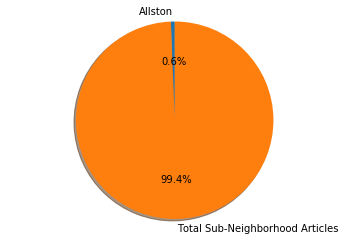

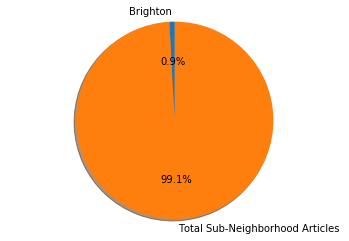

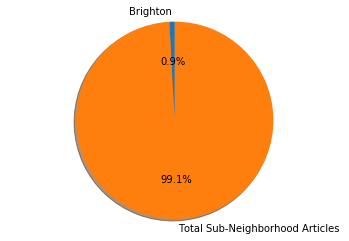

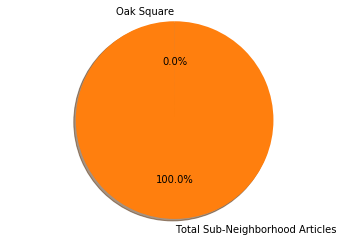

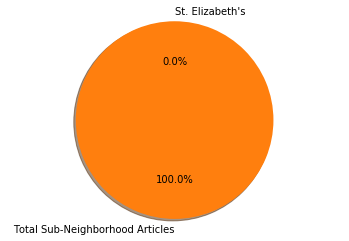

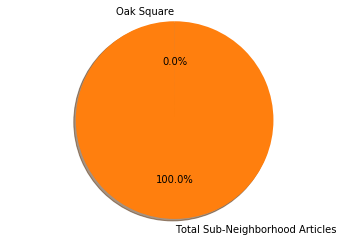

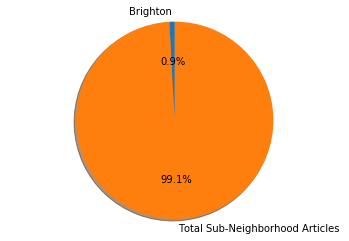

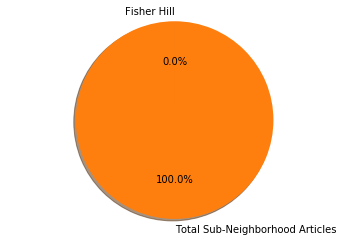

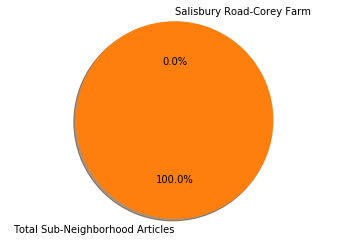

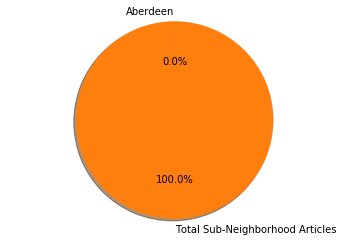

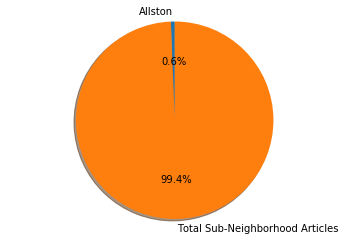

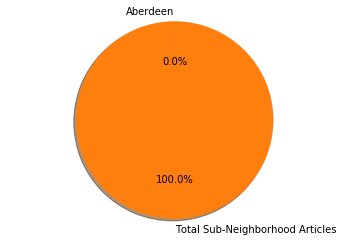

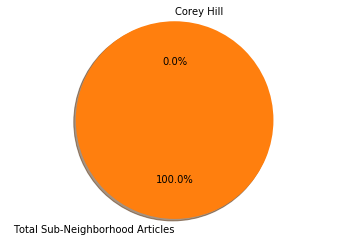

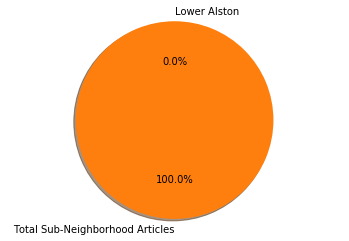

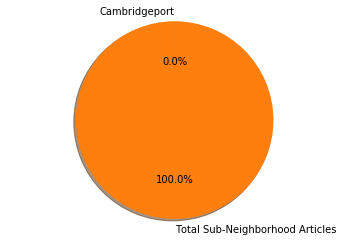

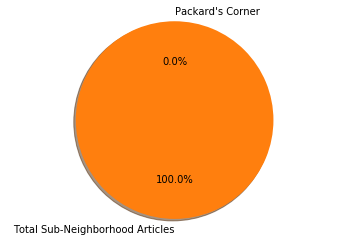

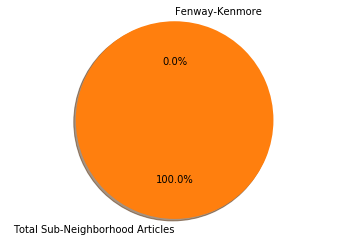

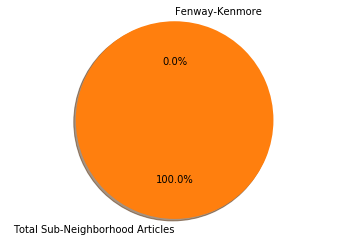

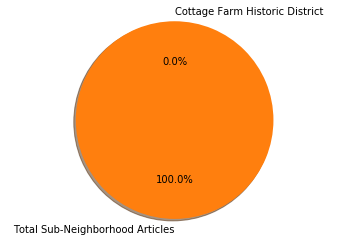

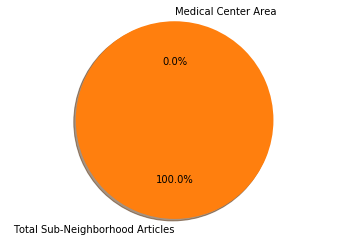

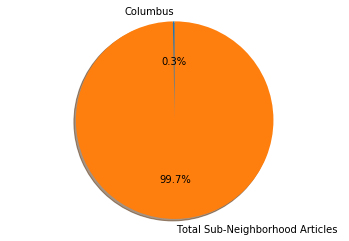

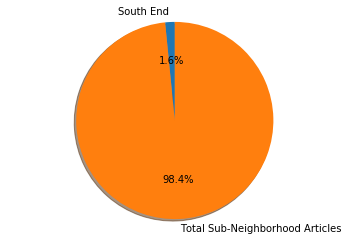

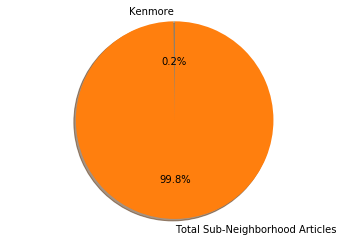

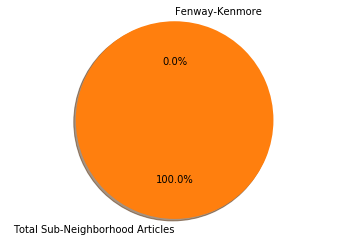

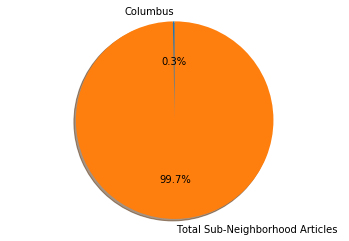

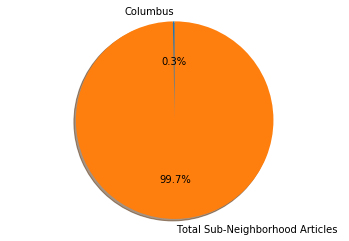

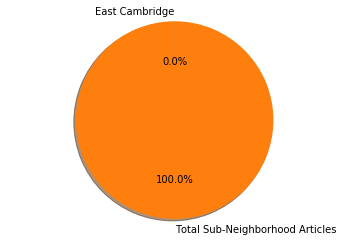

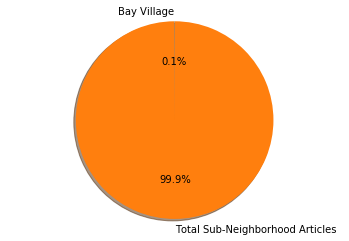

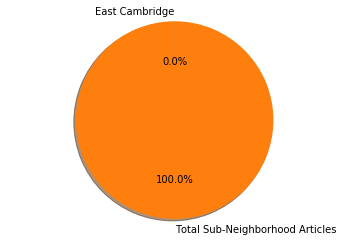

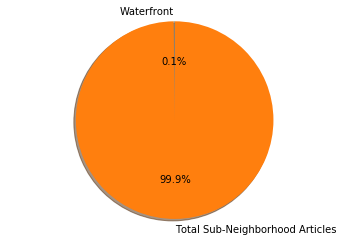

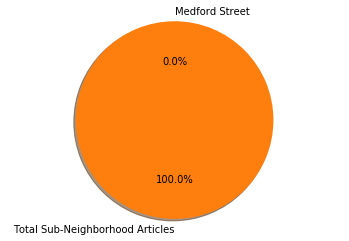

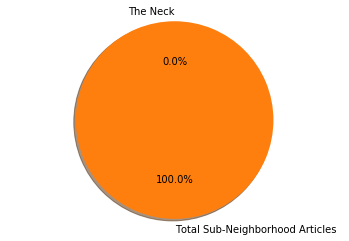

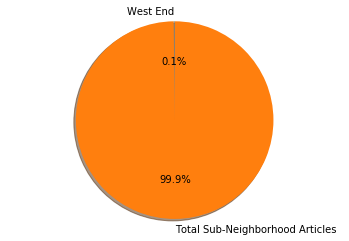

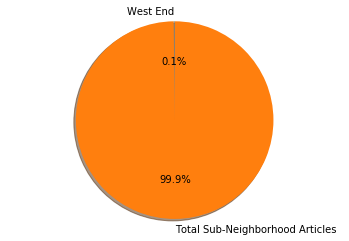

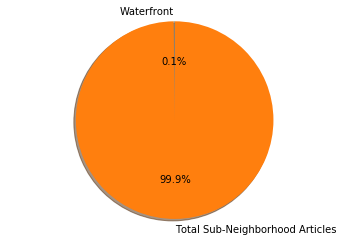

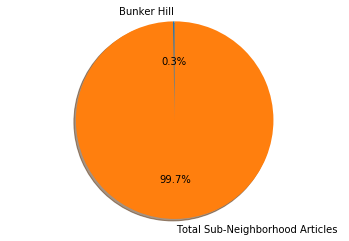

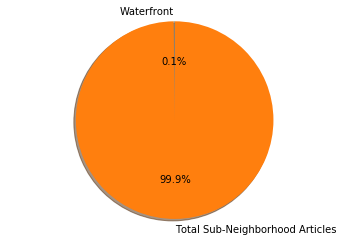

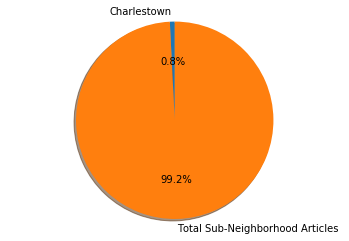

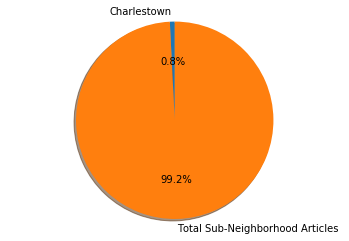

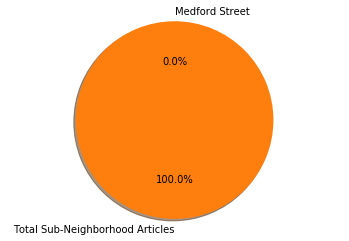

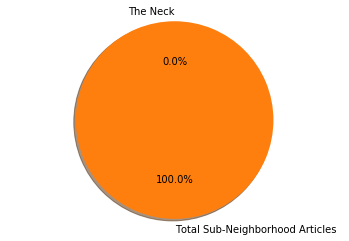

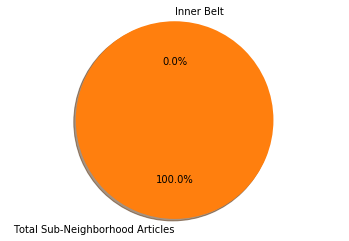

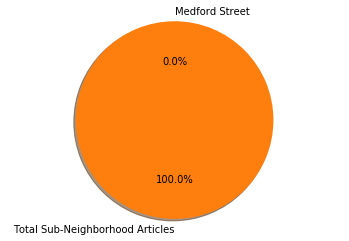

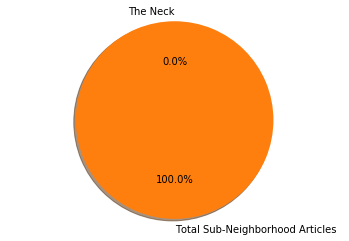

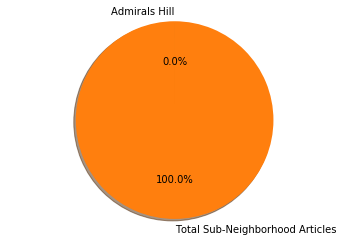

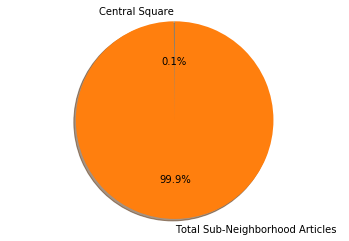

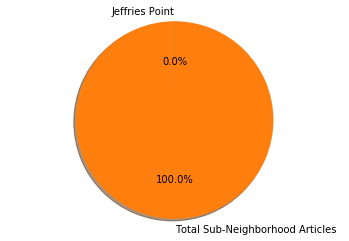

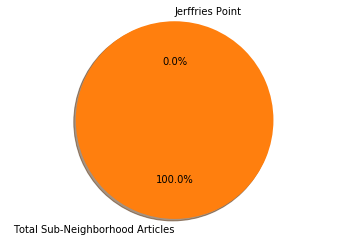

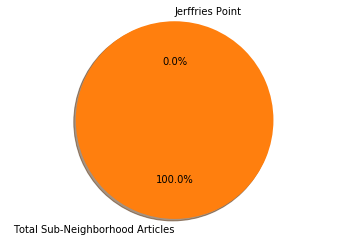

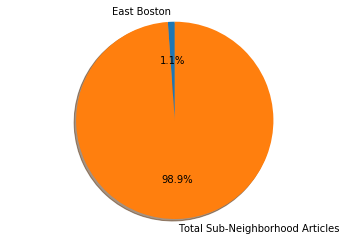

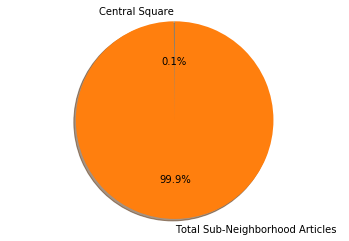

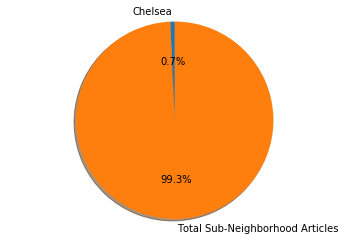

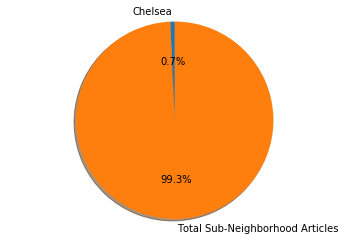

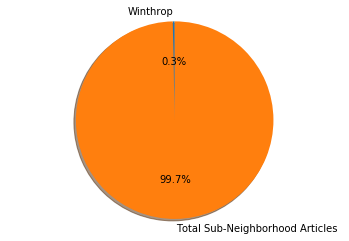

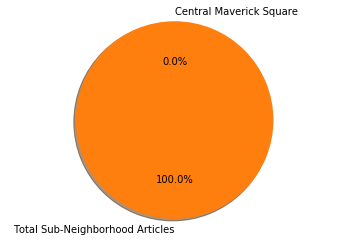

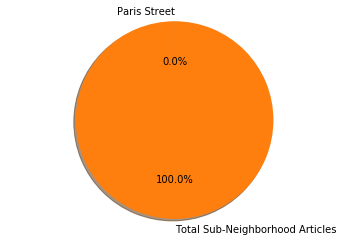

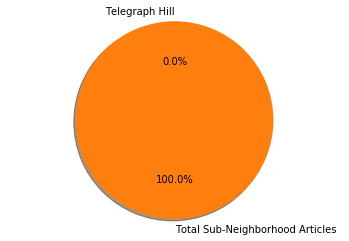

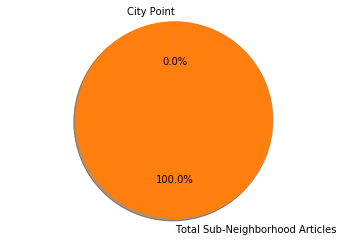

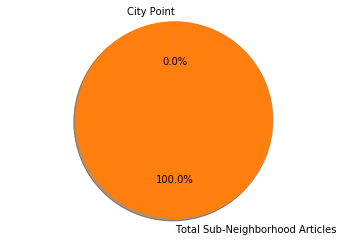

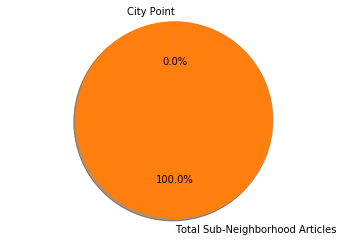

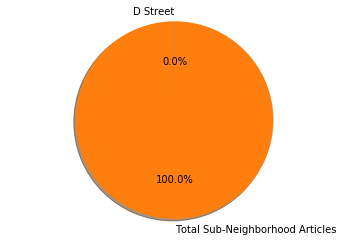

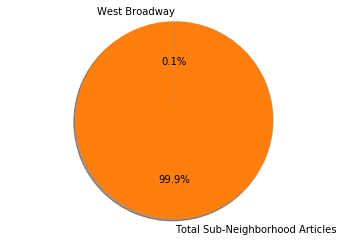

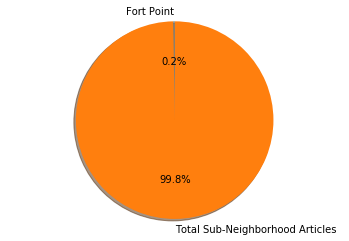

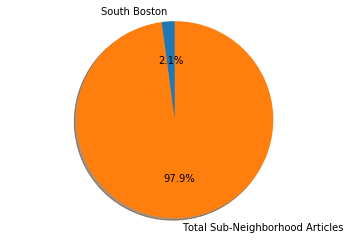

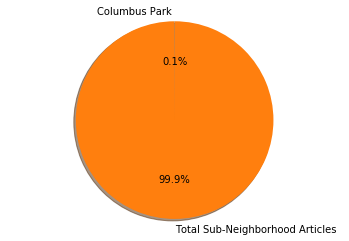

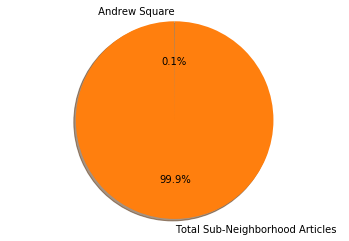

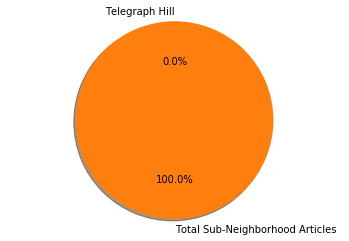

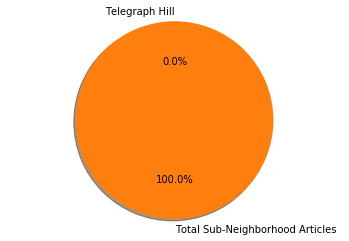

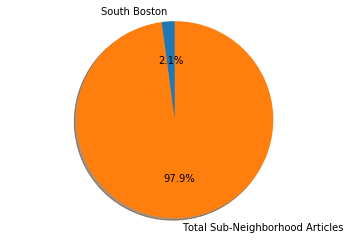

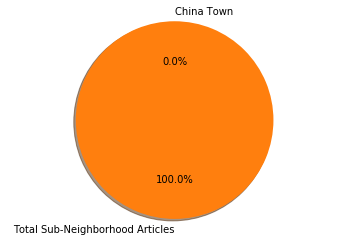

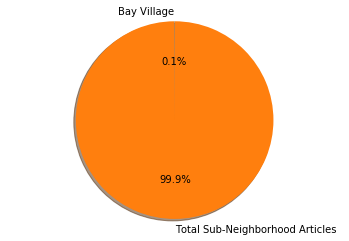

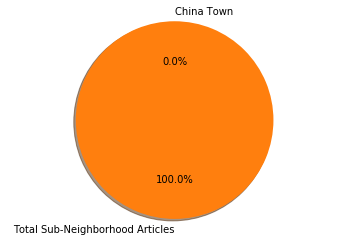

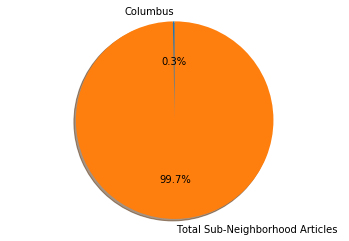

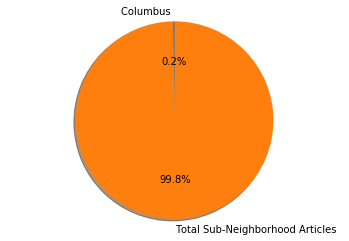

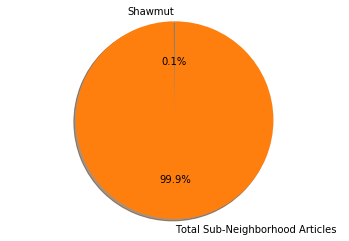

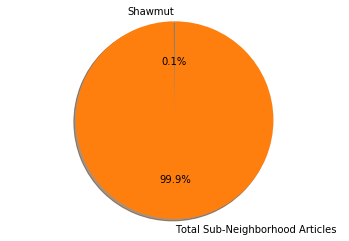

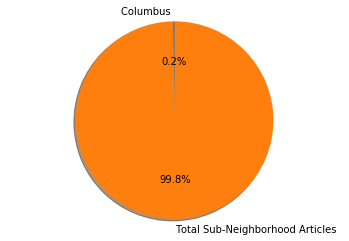

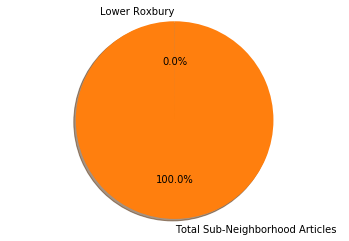

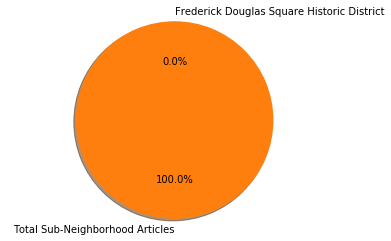

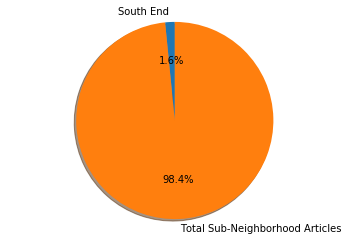

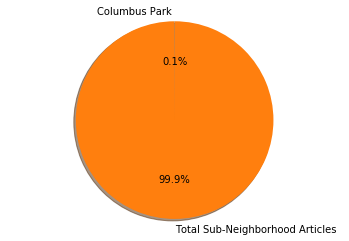

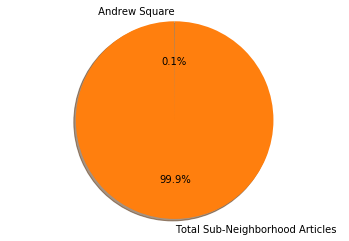

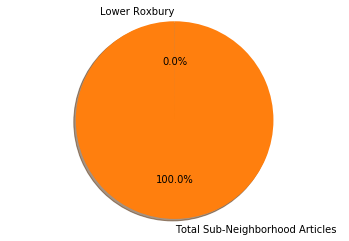

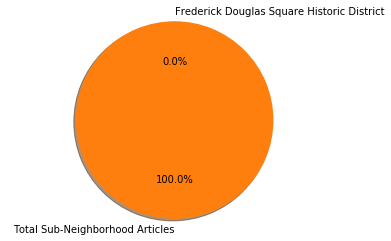

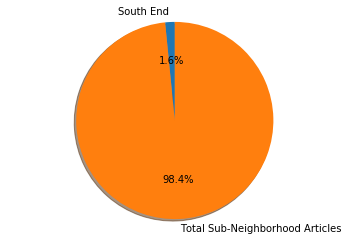

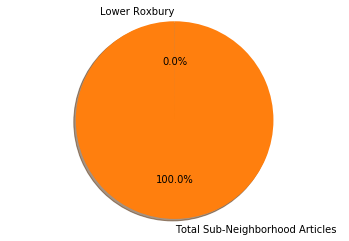

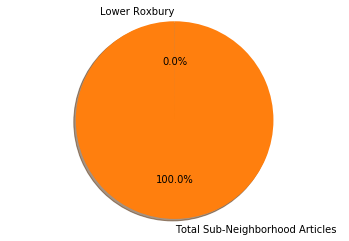

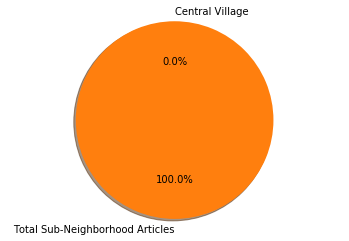

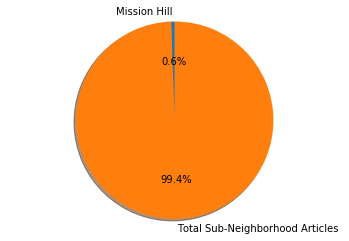

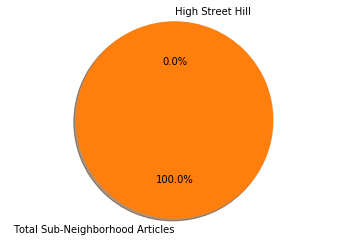

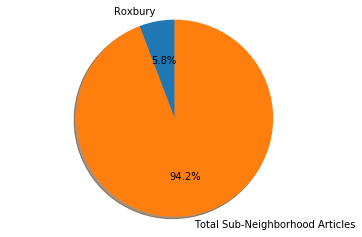

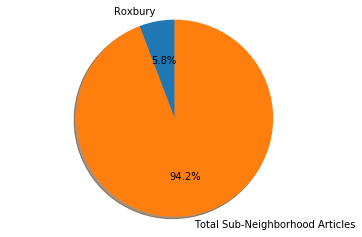

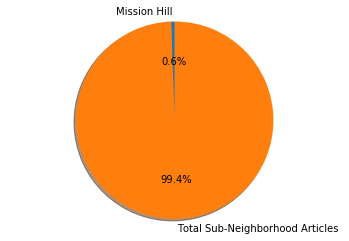

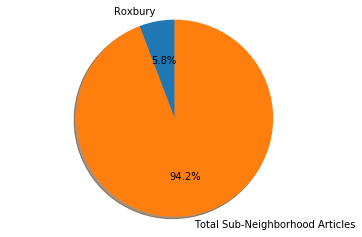

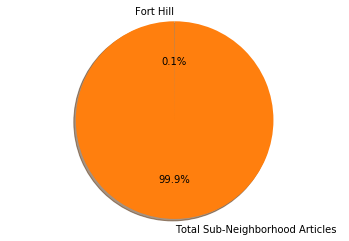

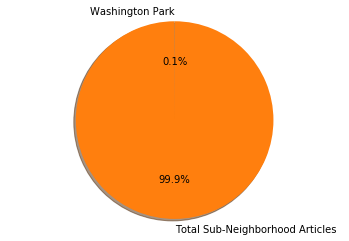

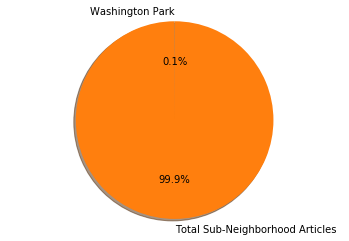

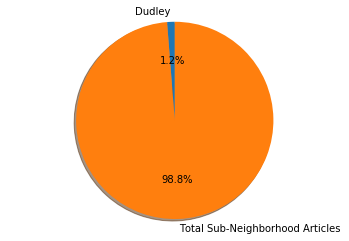

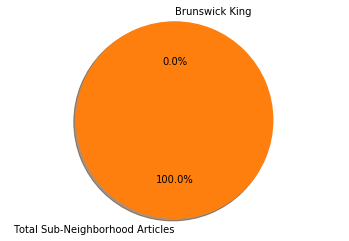

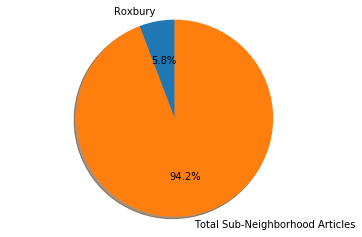

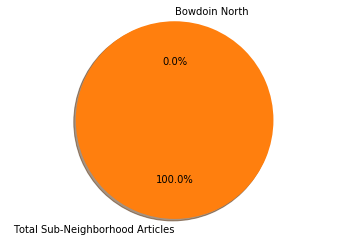

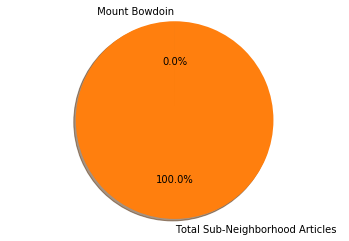

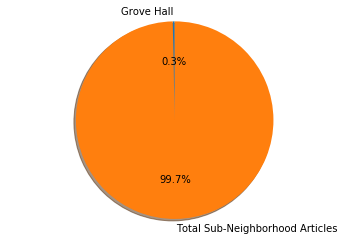

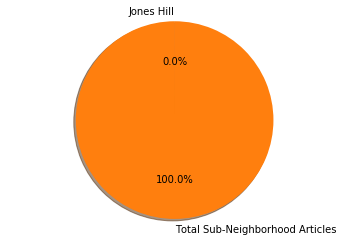

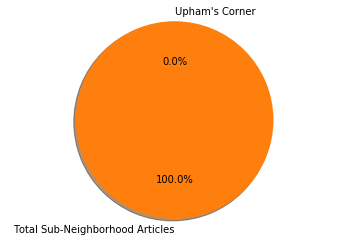

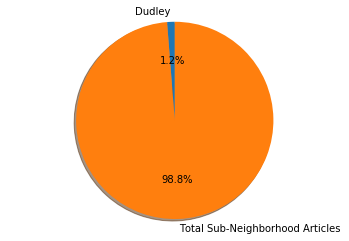

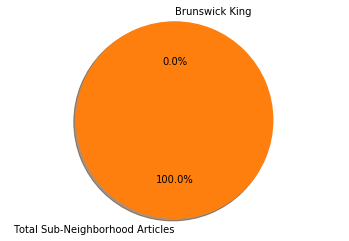

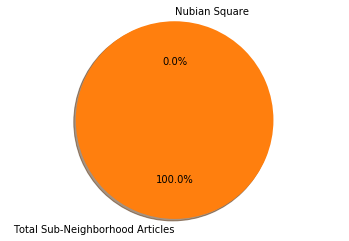

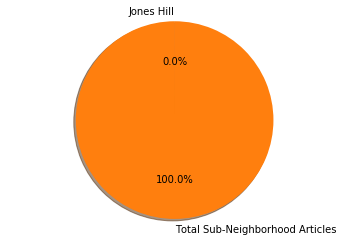

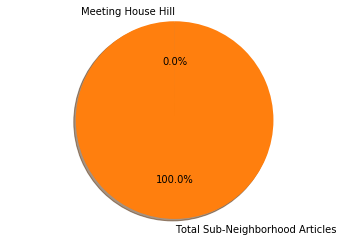

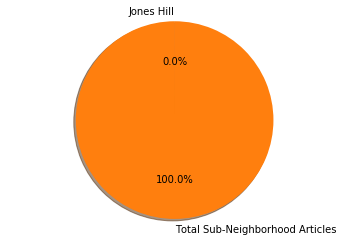

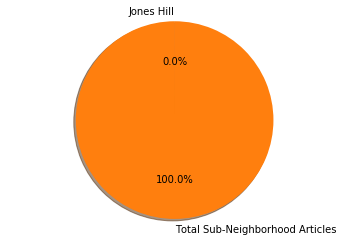

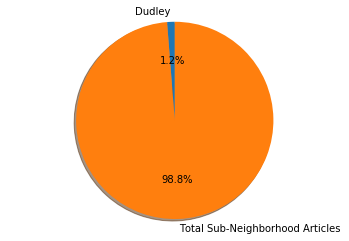

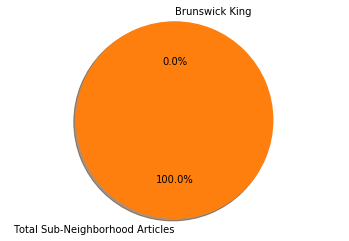

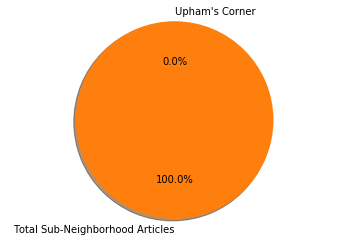

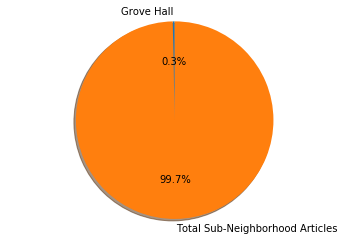

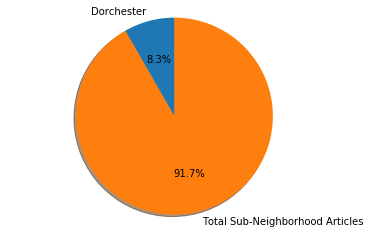

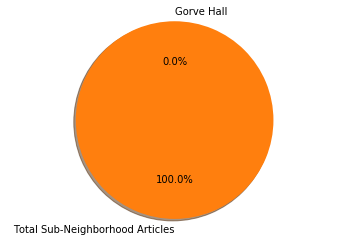

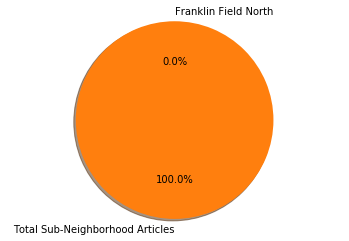

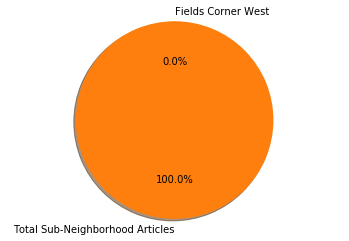

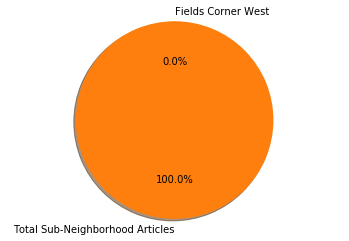

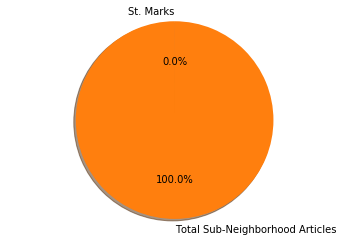

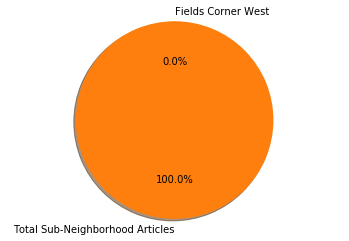

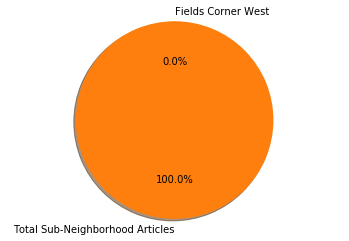

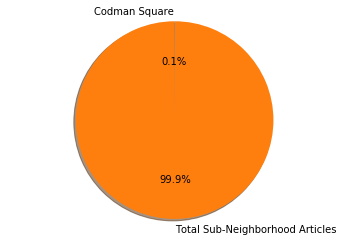

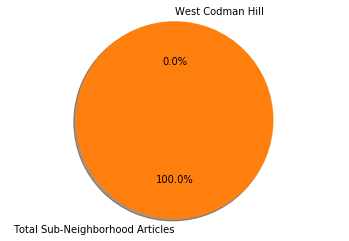

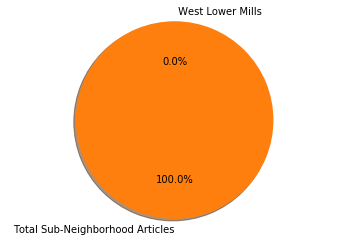

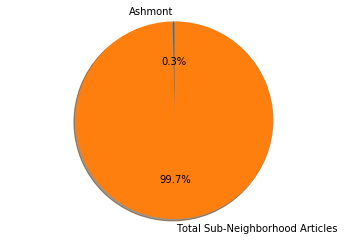

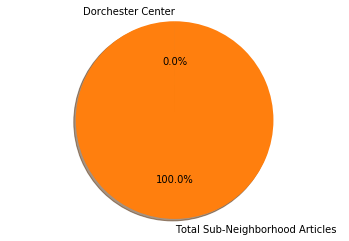

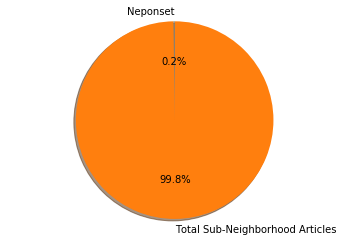

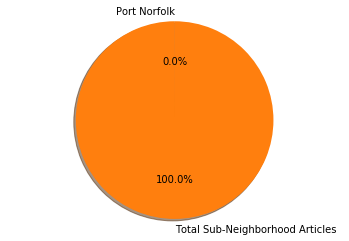

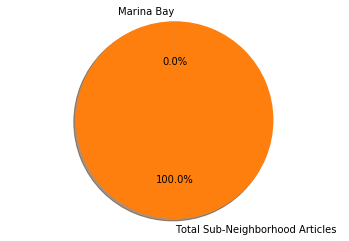

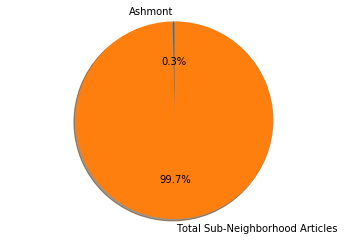

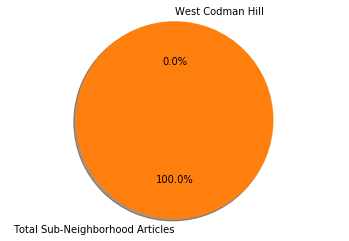

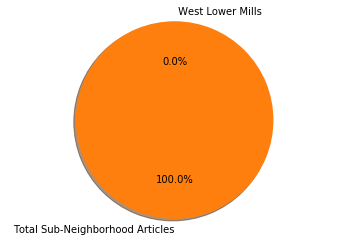

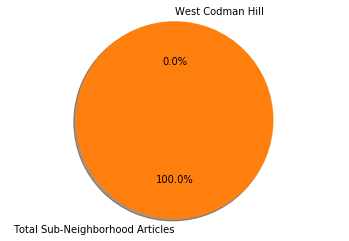

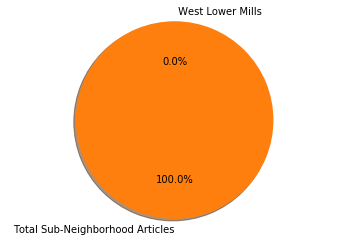

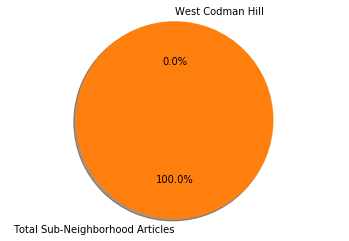

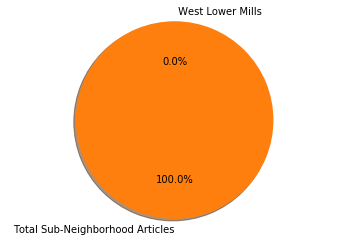

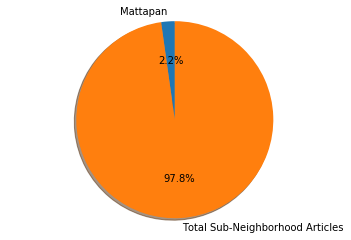

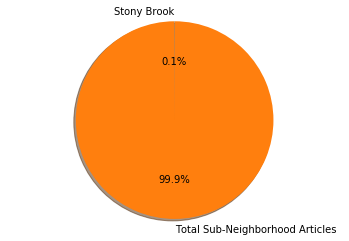

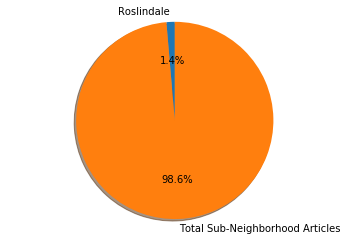

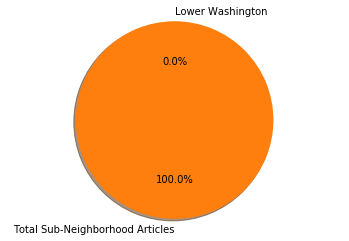

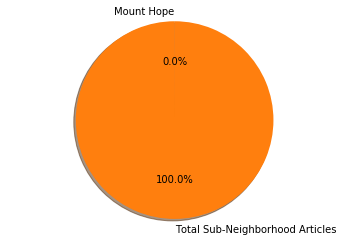

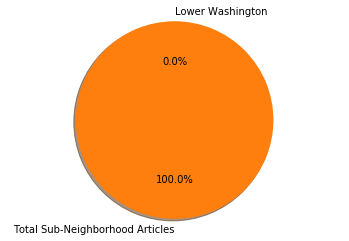

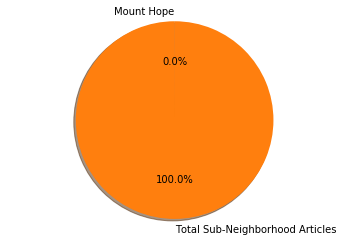

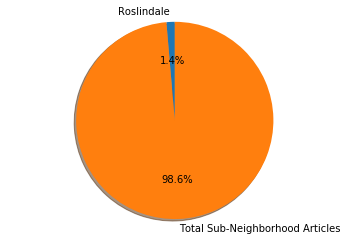

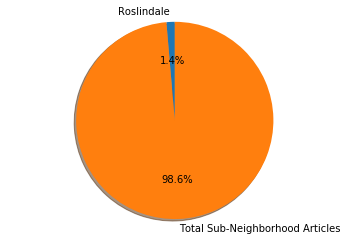

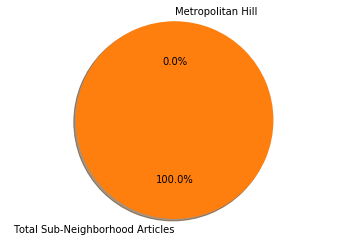

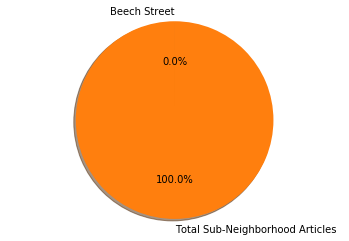

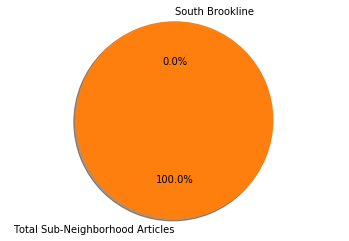

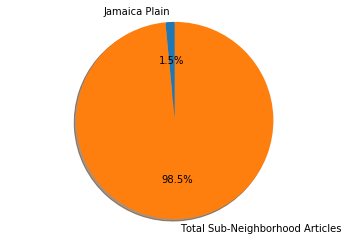

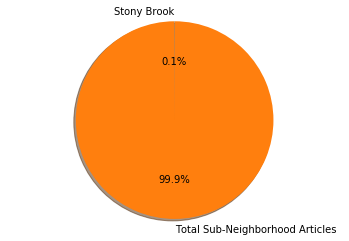

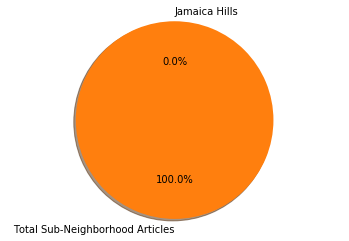

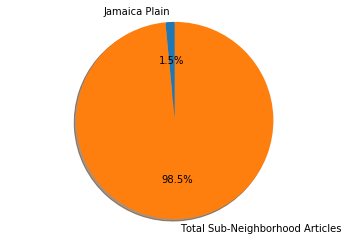

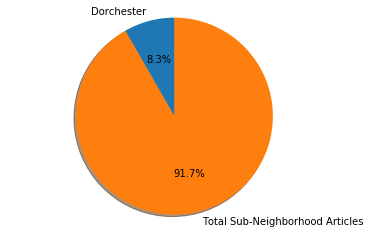

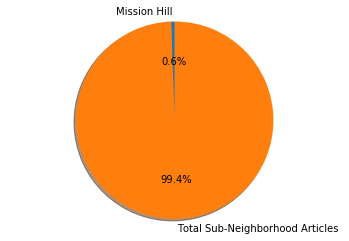

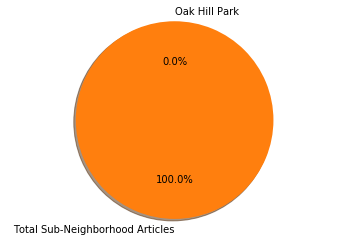

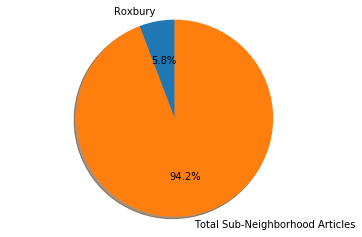

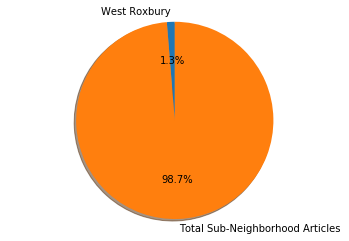

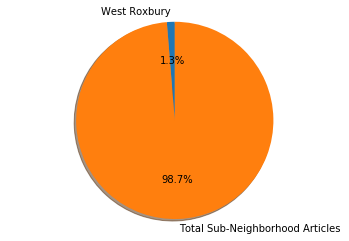

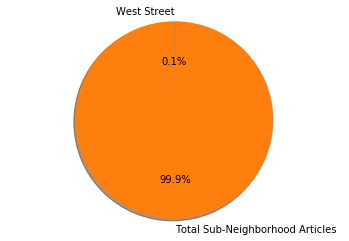

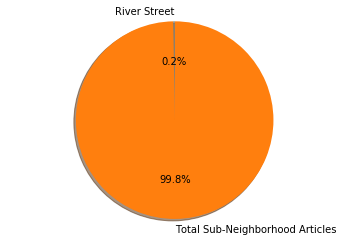

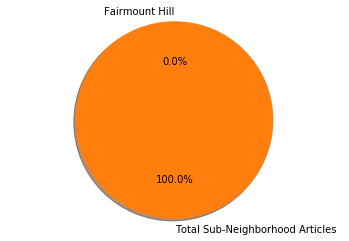

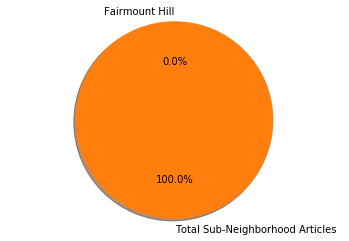

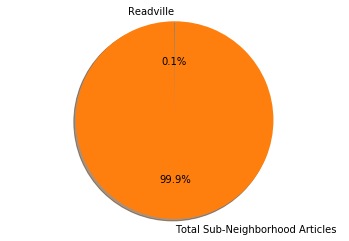

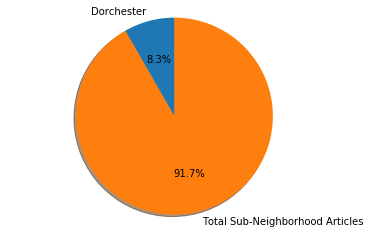

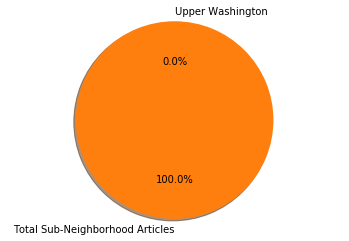

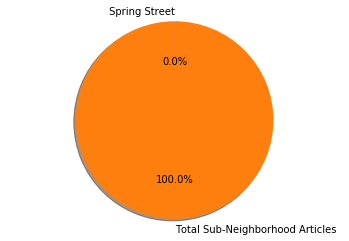

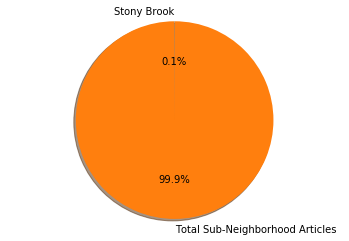

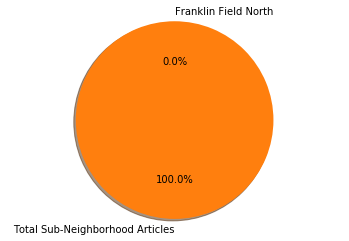

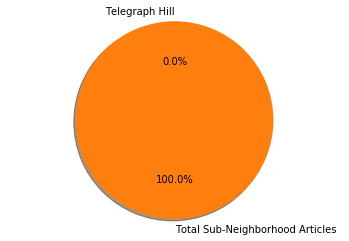

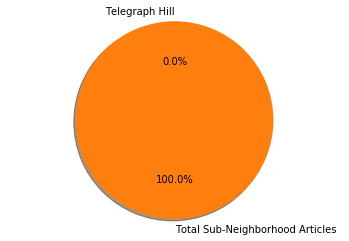

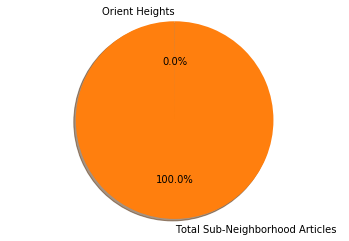

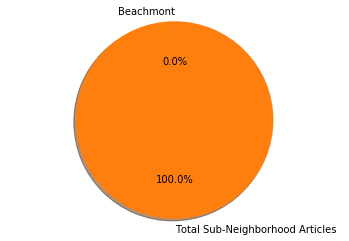

In [11]:
# Visualization of Sub-neighborhood Coverage

#data_df_final.shape[0]
addition = 0
for S_neighborhood in S_nlist:
    #print(S_neighborhood[1])
    #addition += S_neighborhood[1]
#print(addition)
# 122296 total articles covering sub-neighborhoods

    labels = S_neighborhood[0], 'Total Sub-Neighborhood Articles'
    sizes = [S_neighborhood[1], 86846]

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
                shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show()

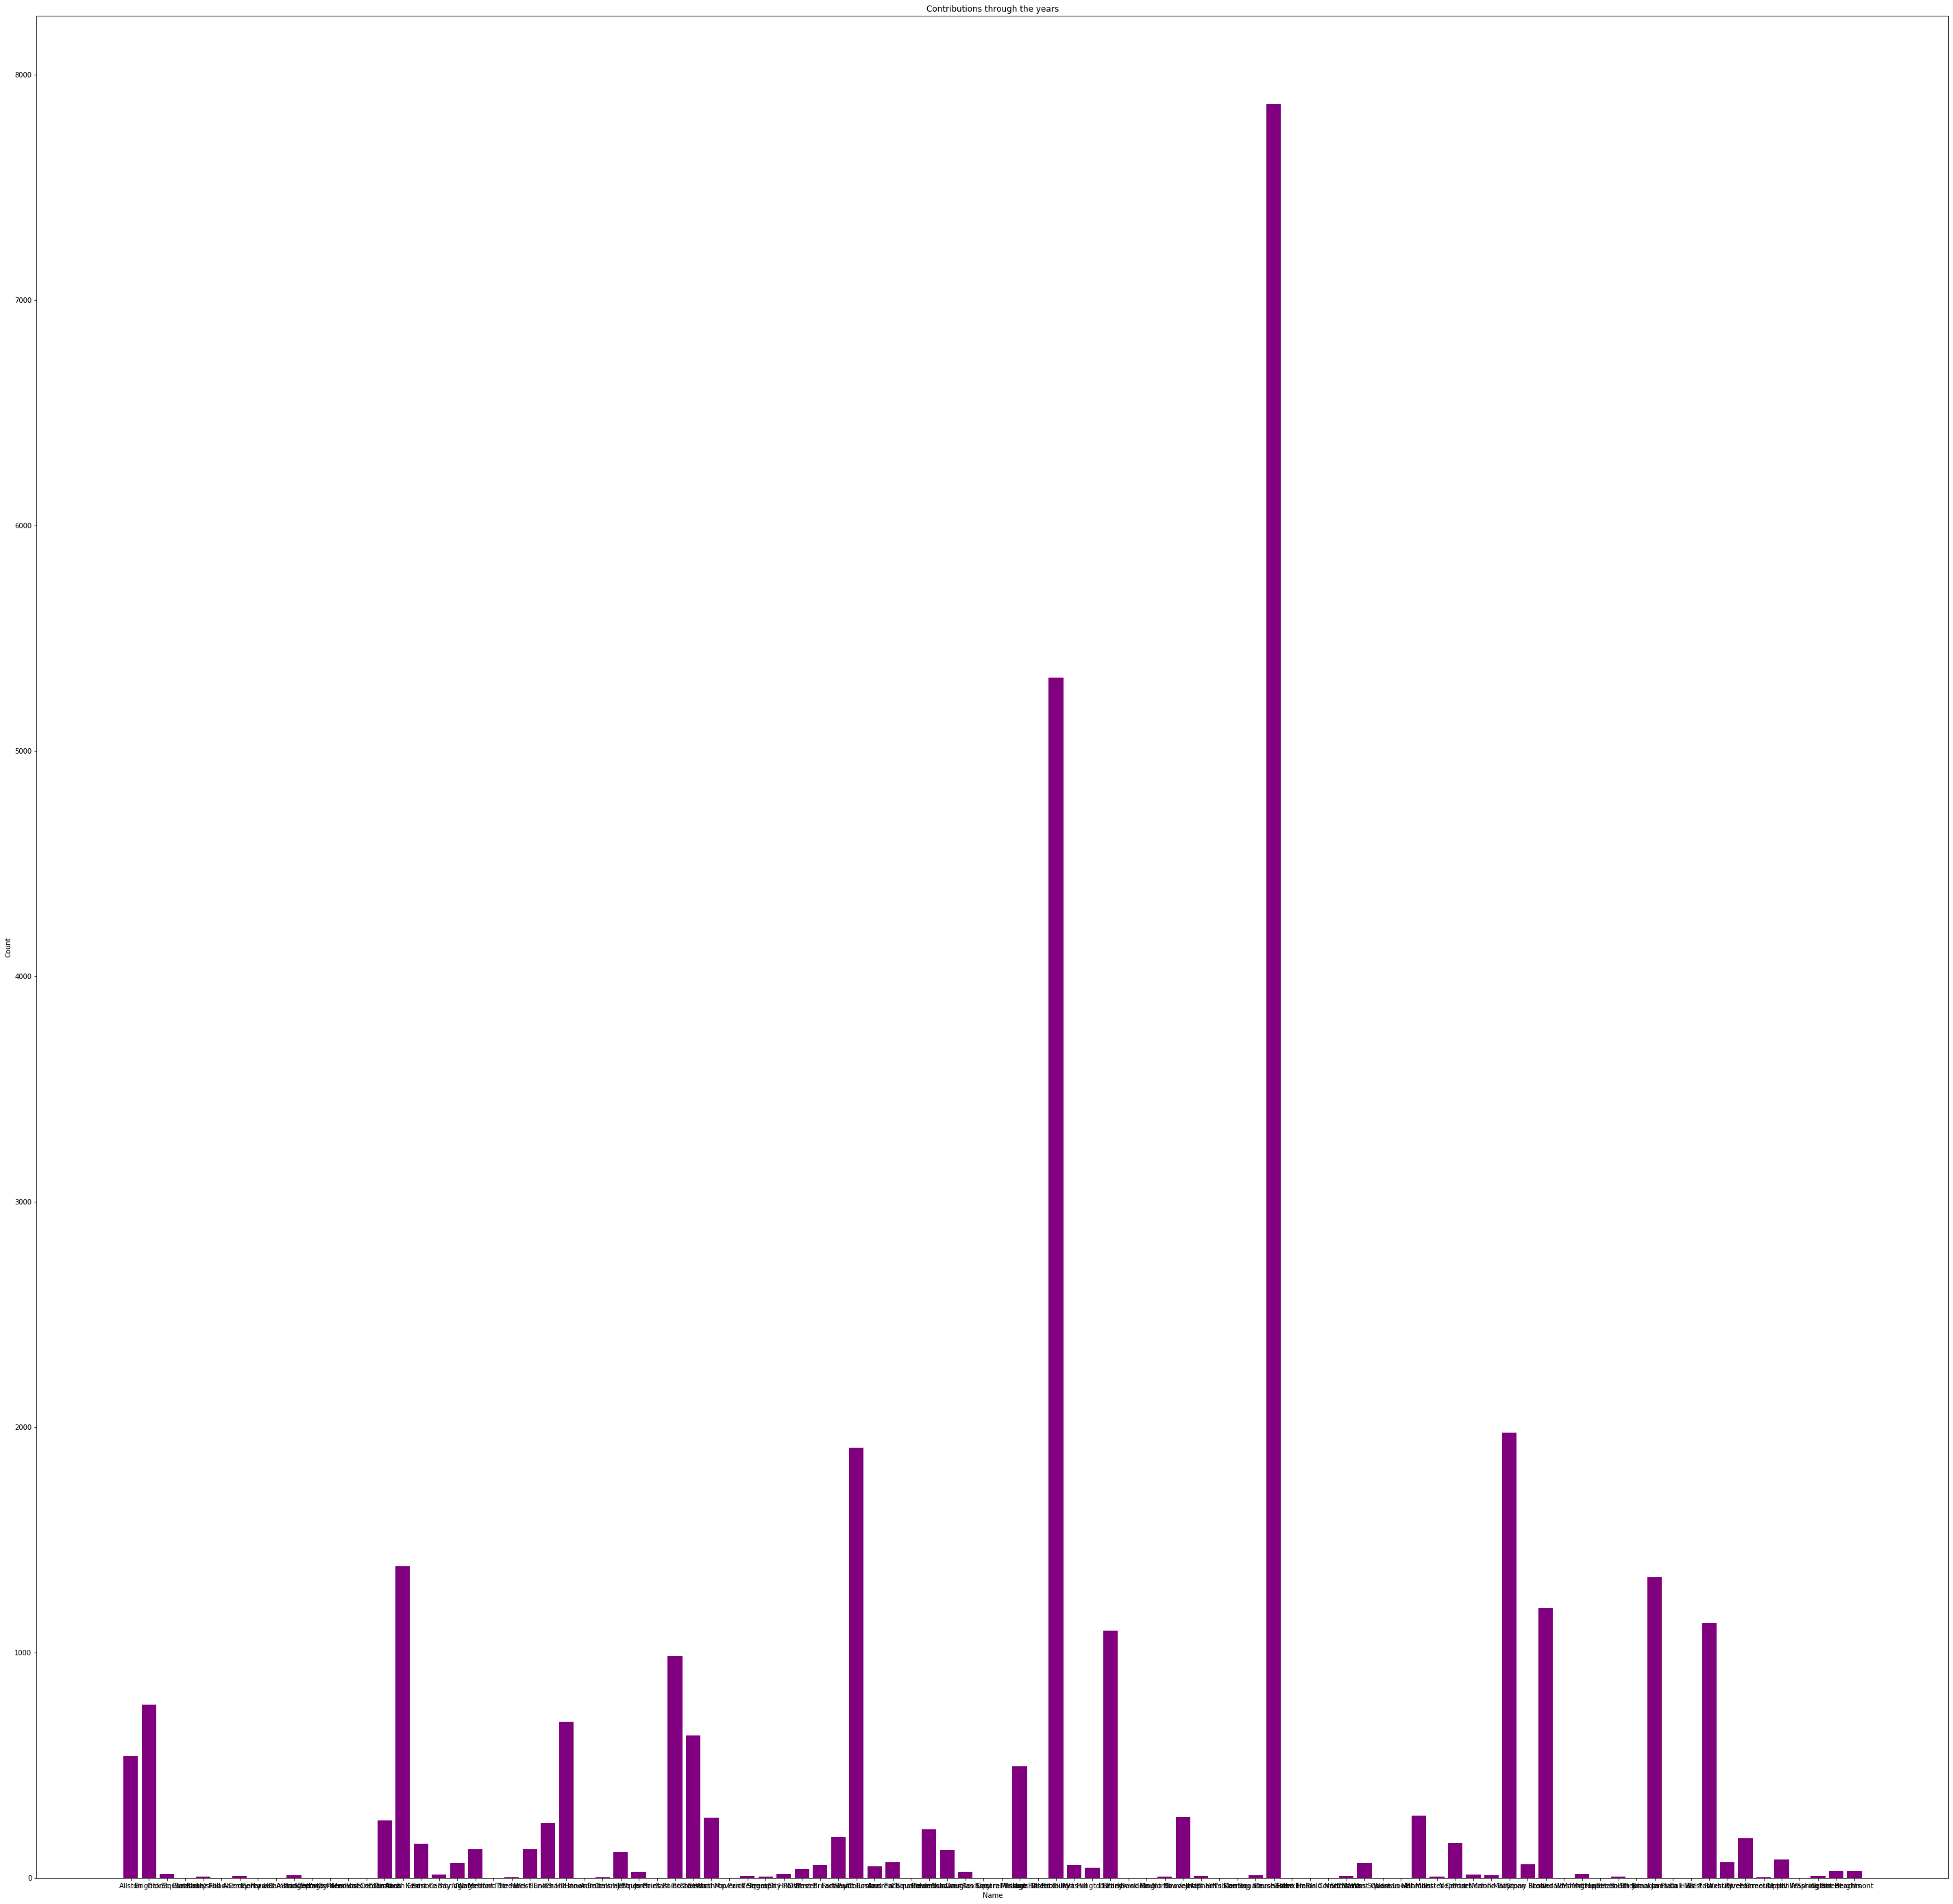

In [15]:
fig, ax = plt.subplots(figsize=(50, 50))
#ax = df_neigh.plot.bar(x='Name', rot=1000000)
#ax = df_neigh.plot.area(x="Name", y="Count", rot=10000000) 
# Add x-axis and y-axis
ax.bar(dedupe_df['Name'],
        dedupe_df['Count'],
        color='purple')

# Set title and labels for axes
ax.set(xlabel="Name",
       ylabel="Count",
       title="Contributions through the years")

plt.show()

In [13]:
addition = 0
for S_neighborhood in S_nlist:
    #print(S_neighborhood[1])
    addition += S_neighborhood[1]
print(addition)

86846


In [18]:
test_l = ["Boston", "Bowdoin North/Mount Bodoin"]
output_l = []
text = "Bowdoin North/Mount Bodoin"
for x in test_l:
    output_l.extend(x.split("/"))
    
print(output_l)

['Boston', 'Bowdoin North', 'Mount Bodoin']


In [4]:
def Neighborhood_Search(terms):
    df_search = data_df_final[data_df_final['text'].str.contains(terms, na=False)]
    return (terms, df_search["text"].shape[0])

def Coverage_Search(Neighborhood_Type):
    Neighborhood_all = Neighborhoods_df[Neighborhood_Type]
    Neighborhood_all = Neighborhood_all.astype(str)
    Primary_sub=[]

    for sub in Neighborhood_all:
        if sub != "nan":
            Primary_sub.append(sub)
    Primary_sub_split=[]

    for sub in Neighborhood_all:
        if sub != "nan":
            Primary_sub_split.extend(sub.split("/"))
            
    S_nlist = []

    for n in Primary_sub_split:
        S_nlist.append(Neighborhood_Search(n))
    #print(S_nlist)
    Names = []
    Count = []
    for x in S_nlist:
        Names.append(x[0])
    for num in S_nlist:
        Count.append(num[1])

    #print(Names)

    Neighborhoods_data = {'Name': Names,
            'Count': Count
            }
    df_neigh = pd.DataFrame(Neighborhoods_data, columns = ['Name', 'Count'])
    dedupe_df = df_neigh.drop_duplicates()
    return(dedupe_df)

In [12]:
Coverage_Search("Secondary Sub-Neighborhood")

Name  Count
0              Allston    540
1             Brighton    768
3           Oak Square     17
4      St. Elizabeth's      0
7          Fisher Hill      4
..                 ...    ...
165          Readville     82
167  Upper Washington       0
168      Spring Street      8
173     Orient Heights     31
174          Beachmont     29

[96 rows x 2 columns]

In [13]:
Coverage_Search("Primary Sub-Neighborhood")

Name  Count
0      Lower Allston      8
1         Oak Square     17
3      Hunnwell Hill      0
4           Brighton    768
5    St. Elizabeth's      0
..               ...    ...
183       Georgetown    728
184      West Street     69
185     River Street    176
189         Ashcroft      6
206        Beachmont     29

[101 rows x 2 columns]

In [14]:
Coverage_Search("Teritriary Sub-Neighborhood(s)")

Name  Count
0                             Packard's Corner      0
1                               Hunnewell Hill      0
2                                      Allston    540
3                                   Corey Hill      0
4                                     Aberdeen      8
5                                   Oak Square     17
11                                    Longwood     84
13                                    Columbus    255
14  Frederick Douglas Square Historic District      0
15                                 Bay Village     65
17                                 Charlestown    693
18                                  Waterfront    128
19                              Jeffries Point     27
20                              Medford Street      0
21                                    The Neck      0
22                                 Bunker Hill    242
23                             Assembly Square     12
24                                  Eagle Hill     12
25                                     Chelsea    633
26                                 East Boston    984
27                              Central Square    114
28                                South Boston   1908
30                               Columbus Park     55
31                               Andrew Square     68
32                            Seaport District    229
35                              Telegraph Hill      6
36                                     Shawmut    123
38                     Boston Theater District      0
40                                    Back Bay    826
41                                    West End    127
42                                   South End   1383
43                                 South End        0
46                              Fenway-Kenmore      0
47                              Lower Roxbury      12
48                     South End of Washington      0
49                               Nubian Square      0
53                             Central Village      0
55                                   Brookline    854
57                             Egleston Square     68
62                          Meeting House Hall      0
63                              Upham's Corner      0
66                                  Grove Hall    269
67                                      Dudley   1096
68                              Brunswick King      0
70                                  Jones Hill      9
71                               Bowdoin North      0
72                                Mount Bodoin      0
74                                  Dorchester   7868
76                                  Washington   2870
77                                  Mount Hope     17
78                             Washington Park     45
79                                West Street      47
80                                River Street    176
81                                   Hyde Park   1302
82                     Forest Hills Woodbourne      0
84                            Lower Washington      0
86                                    D Street     40
87                               West Broadway     58

In [15]:
Coverage_Search("T-Stop/Commuter Rail")

Name  Count
0                   Boston Landing     20
1                  Sutherland Road      0
2                    Chiswick Road      0
3             Chestnut Hill Avenue      6
4                     South Street     26
..                             ...    ...
171                      Fairmount    195
172  Centre St @ Faulkner Hospital      0
173         Columbia Rd @ P Street      0
175                      Beachmont     29
177                Boylston Street    407

[132 rows x 2 columns]

In [11]:
fig, ax = plt.subplots(figsize=(150, 150))
#ax = df_neigh.plot.bar(x='Name', rot=1000000)
#ax = df_neigh.plot.area(x="Name", y="Count", rot=10000000) 
# Add x-axis and y-axis
ax.bar(Coverage_Search("Teritriary Sub-Neighborhood(s)")['Name'],
        Coverage_Search("Teritriary Sub-Neighborhood(s)")['Count'],
        color='purple')

# Set title and labels for axes
ax.set(xlabel="Name",
       ylabel="Count",
       title="Neighborhood Coverage")

plt.show()


In [25]:
def Reverse_Search_Black_Neighborhoods(term):    
    frames=[]
    for df,dy in zip(Coverage_Search(term)['Name'], Coverage_Search(term)['Count']):#['Name']:    
        df_search = Neighborhoods_df[Neighborhoods_df[term].str.contains(df, na=False)] # Search for the Type of neighborhood in the main dataframe
        df_search['Search_Name'] = df
        df_search['Count'] = dy 
        frames.append(df_search)

    df_final = pd.concat(frames)

    return(df_final[df_final["Black Proportion"] >= 0.5]) # Return Predominantly black sub-neighborhoods   
    #"Black Proportion"

In [19]:
Reverse_Search_Black_Neighborhoods("Teritriary Sub-Neighborhood(s)")
#df_final = pd.concat(frames)
#df_final
#"Secondary Sub-Neighborhood"

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Census Tract#                     Zipcode Neighborhood  \
82          803.00                       02119      Roxbury   
82          803.00                       02119      Roxbury   
82          803.00                       02119      Roxbury   
81          801.00                02118, 02119      Roxbury   
83          804.01         02118, 02119, 02120      Roxbury   
93          815.00                       02119      Roxbury   
109         913.00                       02125   Dorchester   
91          813.00                       02119      Roxbury   
96          819.00                02119, 02121      Roxbury   
98          821.00                       02121      Roxbury   
100         902.00                       02121   Dorchester   
101         903.00                02121, 02125   Dorchester   
103         906.00                02119, 02125      Roxbury   
110         914.00                       02125   Dorchester   
114         918.00         02121, 02122, 02125   Dorchester   
113         917.00                       02122   Dorchester   
113         917.00                       02122   Dorchester   
171        9811.00  02124, 02126, 02130, 02131     Mattapan   
171        9811.00  02124, 02126, 02130, 02131     Mattapan   
171        9811.00  02124, 02126, 02130, 02131     Mattapan   

    US Geonames Sub-neigborhood  Total Population   Black  Black Proportion  \
82                          NaN              2089    1546          0.740067   
82                          NaN              2089    1546          0.740067   
82                          NaN              2089    1546          0.740067   
81                          NaN              2690    1364          0.507063   
83                          NaN              3265    1724          0.528025   
93                      Roxbury              2616    1532          0.585627   
109                         NaN              2561    1597          0.623585   
91                          NaN              5326    2726          0.511829   
96                          NaN              3494    2496          0.714367   
98                          NaN              5750    3974          0.691130   
100                         NaN              2587    1755          0.678392   
101                         NaN              3469    2488          0.717210   
103                         NaN              2599    1784          0.686418   
110                         NaN              3165    1740          0.549763   
114                         NaN              3528    2776          0.786848   
113                   Mount Ida              3214    1985          0.617610   
113                   Mount Ida              3214    1985          0.617610   
171                 Forest Hill               470     249          0.529787   
171                 Forest Hill               470     249          0.529787   
171                 Forest Hill               470     249          0.529787   

     White  White Proportion  American Indian & Alaska Native  ...  Female   \
82     231          0.110579                               78  ...     1133   
82     231          0.110579                               78  ...     1133   
82     231          0.110579                               78  ...     1133   
81     550          0.204461                               63  ...     1057   
83     721          0.220827                               36  ...     1705   
93     425          0.162462                               49  ...     1533   
109    532          0.207731                               21  ...     1287   
91    1181          0.221742                               36  ...     2658   
96     718          0.205495                                1  ...     1913   
98    1033          0.179652                              180  ...     3210   
100    576          0.222652                               17  ...     1296   
101    450          0.129720                               27  ...     19

In [26]:
Reverse_Search_Black_Neighborhoods("Primary Sub-Neighborhood")

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Census Tract#                     Zipcode  Neighborhood  \
81          801.00                02118, 02119       Roxbury   
83          804.01         02118, 02119, 02120       Roxbury   
82          803.00                       02119       Roxbury   
94          817.00                       02119       Roxbury   
95          818.00                       02119       Roxbury   
103         906.00                02119, 02125       Roxbury   
91          813.00                       02119       Roxbury   
91          813.00                       02119       Roxbury   
93          815.00                       02119       Roxbury   
81          801.00                02118, 02119       Roxbury   
83          804.01         02118, 02119, 02120       Roxbury   
96          819.00                02119, 02121       Roxbury   
97          820.00                       02121       Roxbury   
98          821.00                       02121       Roxbury   
99          901.00                       02121    Dorchester   
120         924.00                02121, 02124    Dorchester   
121        1001.00                02124, 02126    Dorchester   
122        1002.00                02124, 02126    Dorchester   
100         902.00                       02121    Dorchester   
114         918.00         02121, 02122, 02125    Dorchester   
100         902.00                       02121    Dorchester   
114         918.00         02121, 02122, 02125    Dorchester   
101         903.00                02121, 02125    Dorchester   
102         904.00         02119, 02121, 02125       Roxbury   
110         914.00                       02125    Dorchester   
101         903.00                02121, 02125    Dorchester   
102         904.00         02119, 02121, 02125       Roxbury   
110         914.00                       02125    Dorchester   
109         913.00                       02125    Dorchester   
111         915.00                02122, 02125    Dorchester   
113         917.00                       02122    Dorchester   
115         919.00                02121, 02124    Dorchester   
116         920.00                02122, 02124    Dorchester   
119         923.00                       02124    Dorchester   
123        1003.00                02124, 02126    Dorchester   
124        1004.00                       02124    Dorchester   
123        1003.00                02124, 02126    Dorchester   
124        1004.00                       02124    Dorchester   
125        1005.00                       02124    Dorchester   
130        1009.00                02124, 02126      Mattapan   
131        1010.01                       02126      Mattapan   
131        1010.01                       02126      Mattapan   
132        1010.02                       02126      Mattapan   
133        1011.01                       02126      Mattapan   
134        1011.02                       02126      Mattapan   
171        9811.00  02124, 02126, 02130, 02131      Mattapan   
171        9811.00  02124, 02126, 02130, 02131      Mattapan   
91          813.00                       02119       Roxbury   
93          815.00                       02119       Roxbury   
134        1011.02                       02126      Mattapan   
136        1102.01                       02131    Roslindale   
136        1102.01                       02131    Roslindale   
161        1401.06                       02131    Roslindale   
161        1401.06                       02131    Roslindale   
158        1304.06                02132, 02136  West Roxbury   
165        1403.00                       02136     Hyde Park   
166        1404.00         02126, 02131, 02136     Hyde Park   
166        1404.00         02126, 02131, 02136     Hyde Park   

    US Geonames Sub-neigborhood  Total Population   Black  Black Proportion  \
81                          NaN              2690    1364          0.507063   
83                          NaN              3265    1724          0.5

In [122]:
for df,dy in zip(Coverage_Search("Secondary Sub-Neighborhood")['Name'], Coverage_Search("Secondary Sub-Neighborhood")['Count']):
    #print(df,dy)
    #print(type(dy))

<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class

In [26]:
# To search a a primary and secondary neighborhood within it
def Double_Neighborhood_Search(primary, secondary):
    df_primary = data_df_final[data_df_final['text'].str.contains(primary, na=False)]
    df_secondary = df_primary[df_primary['text'].str.contains(secondary, na=False)]
    return ('Primary: ', primary, 'Secondary: ', secondary, df_secondary["text"].shape[0])

In [28]:
Double_Neighborhood_Search("Grove Hall", "Roxbury")

('Primary: ', 'Grove Hall', 'Secondary: ', 'Roxbury', 166)

In [5]:
# Alternative approach to first filter by Black neighborhoods

Black_Census_Tracts = Neighborhoods_df[Neighborhoods_df["Black Proportion"] >= 0.5]
Black_Census_Tracts

Census Tract#                     Zipcode  Neighborhood  \
81          801.00                02118, 02119       Roxbury   
82          803.00                       02119       Roxbury   
83          804.01         02118, 02119, 02120       Roxbury   
91          813.00                       02119       Roxbury   
93          815.00                       02119       Roxbury   
94          817.00                       02119       Roxbury   
95          818.00                       02119       Roxbury   
96          819.00                02119, 02121       Roxbury   
97          820.00                       02121       Roxbury   
98          821.00                       02121       Roxbury   
99          901.00                       02121    Dorchester   
100         902.00                       02121    Dorchester   
101         903.00                02121, 02125    Dorchester   
102         904.00         02119, 02121, 02125       Roxbury   
103         906.00                02119, 02125       Roxbury   
109         913.00                       02125    Dorchester   
110         914.00                       02125    Dorchester   
111         915.00                02122, 02125    Dorchester   
113         917.00                       02122    Dorchester   
114         918.00         02121, 02122, 02125    Dorchester   
115         919.00                02121, 02124    Dorchester   
116         920.00                02122, 02124    Dorchester   
119         923.00                       02124    Dorchester   
120         924.00                02121, 02124    Dorchester   
121        1001.00                02124, 02126    Dorchester   
122        1002.00                02124, 02126    Dorchester   
123        1003.00                02124, 02126    Dorchester   
124        1004.00                       02124    Dorchester   
125        1005.00                       02124    Dorchester   
130        1009.00                02124, 02126      Mattapan   
131        1010.01                       02126      Mattapan   
132        1010.02                       02126      Mattapan   
133        1011.01                       02126      Mattapan   
134        1011.02                       02126      Mattapan   
136        1102.01                       02131    Roslindale   
158        1304.06                02132, 02136  West Roxbury   
161        1401.06                       02131    Roslindale   
165        1403.00                       02136     Hyde Park   
166        1404.00         02126, 02131, 02136     Hyde Park   
171        9811.00  02124, 02126, 02130, 02131      Mattapan   

    US Geonames Sub-neigborhood  Total Population   Black  Black Proportion  \
81                          NaN              2690    1364          0.507063   
82                          NaN              2089    1546          0.740067   
83                          NaN              3265    1724          0.528025   
91                          NaN              5326    2726          0.511829   
93                      Roxbury              2616    1532          0.585627   
94                          NaN              4151    2849          0.686341   
95                          NaN              3489    2439          0.699054   
96                          NaN              3494    2496          0.714367   
97                          NaN              3409    2354          0.690525   
98                          NaN              5750    3974          0.691130   
99                          NaN              5148    3845          0.746892   
100                         NaN              2587    1755          0.678392   
101                         NaN              3469    2488          0.717210   
102                         NaN              4318    3289          0.761695   
103                         NaN              2599    1784          0.686418   
109                         NaN              2561    1597          0.623585   
110                         NaN      

In [9]:
Unique_Neighborhoods = Neighborhoods_df['Neighborhood'].unique()
Unique_Neighborhoods

array(['Brighton', 'Allston', 'Fenway', 'Longwood Medical Area',
       'Back Bay', 'Beacon Hill', 'West End', 'North End', 'Downtown',
       'Charlestown', 'East Boston', 'South Boston',
       'South Boston Waterfront', 'South End', 'Roxbury', 'Mission Hill',
       'Jamaica Plain', 'Dorchester', 'Mattapan', 'Roslindale',
       'West Roxbury', 'Hyde Park', 'Harbor Islands', nan], dtype=object)

In [13]:
All_Neighborhood_Census = pd.DataFrame(columns=['Neighborhood', 'Black Population', 'Black Percentage'])
Neigh_list = []
Pop_List = []
Percent_List = []

for neighborhood in Unique_Neighborhoods:
    All_Neighborhood_Census = Neighborhoods_df[Neighborhoods_df['Neighborhood'] == neighborhood]
    Black_Pop = All_Neighborhood_Census[' Black'].sum()
    Proportion_Mean = All_Neighborhood_Census['Black Proportion'].mean()
    Neigh_list.append(neighborhood)
    Pop_List.append(Black_Pop)
    Percent_List.append(Proportion_Mean*100)
    
#print(neighborhood, Black_Pop, Proportion_Mean*100)
NeighSe = pd.Series(Neigh_list)
PopSe = pd.Series(Pop_List)
PercentSe = pd.Series(Percent_List)

All_Neighborhood_Census['Neighborhood'] = NeighSe.values
All_Neighborhood_Census['Black Population'] = PopSe.values
All_Neighborhood_Census['Black Percentage'] = PercentSe.values

All_Neighborhood_Census = All_Neighborhood_Census[['Neighborhood','Black Population','Black Percentage']]
All_Neighborhood_Census.sort_values(by='Black Percentage', ascending=False)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

Neighborhood  Black Population  Black Percentage
18                 Mattapan             21692         77.887961
14                  Roxbury             32182         57.792557
17               Dorchester             67115         51.945371
21                Hyde Park             19405         39.816990
22           Harbor Islands               127         31.358025
19               Roslindale              7384         29.086615
10              East Boston             12608         20.687438
15             Mission Hill              3259         18.295159
13                South End              5232         17.194216
16            Jamaica Plain              7338         15.964452
20             West Roxbury              4926         12.817302
11             South Boston              3168         10.359858
9               Charlestown              1817          9.254430
12  South Boston Waterfront               187          8.488404
2                    Fenway              2145          6.642350
3     Longwood Medical Area               360          6.545455
1                   Allston              1280          6.426988
6                  West End               493          6.260777
0                  Brighton              2914          5.520567
8                  Downtown               805          4.550255
4                  Back Bay               962          4.336677
5               Beacon Hill               244          1.506084
7                 North End               109          1.206700
23                      NaN                 0               NaN

In [29]:
Neighborhood_Search("Lower Roxbury")

('Lower Roxbury', 27)

In [30]:
with open('./Black Census Tracts.csv', "w", newline='') as f:
    writer = csv.writer(f, delimiter=',')
    

Black_Census_Tracts.to_csv ('./Black Census Tracts.csv', index = False, header=True)

In [ ]:
# Edge Black Census tracts as seen on Tableau:
# 804.01, 801, 

# Perhaps make these set of points into a shapefile and only look for associated neighborhood words as a mention of a
# predominantly Black sub-neighborhood


In [14]:
from shapely.geometry import Point, Polygon
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely.geometry as geometry

In [35]:
Coordinates = []
for lat, long in zip(Black_Census_Tracts['Lat'],Black_Census_Tracts['Long']):
    coord_temp = []
    coord_temp.append(lat)
    coord_temp.append(long)
    coord_tuple = tuple(coord_temp)
    Coordinates.append(coord_tuple)

print(Coordinates)
Black_CC_poly = Polygon(Coordinates) #

[(42.3293317, -71.0705291), (42.3274519, -71.0790504), (42.3321186, -71.0808985), (42.319327, -71.0976901), (42.3207186, -71.0929141), (42.3226962, -71.086034), (42.3203184, -71.0800303), (42.3154742, -71.089652), (42.3137479, -71.0839483), (42.3094485, -71.0872292), (42.3023757, -71.0820198), (42.3071378, -71.0790559), (42.3109366, -71.076505), (42.3171635, -71.0747098), (42.3229604, -71.0722753), (42.3199357, -71.0668701), (42.3152689, -71.0698538), (42.3114941, -71.0643707), (42.3036111, -71.0659136), (42.3073664, -71.0705167), (42.3008408, -71.0755308), (42.2996758, -71.0675668), (42.2939435, -71.0750607), (42.2960418, -71.0849877), (42.2902498, -71.0873027), (42.2848004, -71.0857215), (42.2827979, -71.0797972), (42.281787, -71.0708447), (42.2882344, -71.0707474), (42.2740065, -71.0742308), (42.2718109, -71.0999859), (42.2740572, -71.0853267), (42.2826649, -71.0950819), (42.2787961, -71.0920462), (42.280496, -71.1170508), (42.2600645, -71.1514976), (42.2738738, -71.1371416), (42.25

In [32]:
#p1 = Point((42.324755,-71.081800))
Neighborhoods_Sans_Black = Neighborhoods_df[Neighborhoods_df.apply(lambda x: x.values.tolist() not in Black_Census_Tracts.values.tolist(), axis=1)]

Check_Coord = []

for lat, long, tractNum in zip(Neighborhoods_Sans_Black['Lat'],Neighborhoods_Sans_Black['Long'], Neighborhoods_Sans_Black['Census Tract#']):
    coord_temp = []
    coord_temp.append(lat)
    coord_temp.append(long)
    coord_tuple = tuple(coord_temp)
    #Check_Coord.append(coord_tuple)
    check_point = Point(coord_tuple)

    
    print(tractNum, Black_CC_poly.exterior.distance(check_point))



1.0 0.058735720401566605
2.01 0.07236180217442553
2.02 0.06570487285773453
3.01 0.07919999399047427
3.02 0.0753633274238922
4.01 0.05713319502785616
4.02 0.06599487847954502
5.02 0.0610344163950222
5.03 0.056206487559804674
5.04 0.05117568118481699
6.01 0.05752521599056448
6.02 0.05384742380996365
7.01 0.0488582897405429
7.03 0.0442261514224368
7.04 0.047080029823377875
8.02 0.0493753891563453
8.03 0.04622335556911521
101.03 0.0277152353300897
101.04 0.02156210489539006
102.03 0.0201373365535071
102.04 0.024900194255746064
103.0 0.018473770669112384
104.03 0.014804381351812702
104.04 0.012523645400619598
104.05 0.011438518763054318
104.08 0.017847702458340876
105.0 0.012976736712285676
106.0 0.015593513894246366
107.01 0.01785453351337061
107.02 0.02043831169641842
108.01 0.022339676678502923
108.02 0.019980145432152947
201.01 0.02805006526356099
202.0 0.03076719812153745
203.01 0.03338540593807489
203.02 0.030715415974724315
203.03 0.03730275768425505
301.0 0.04026913676080216
302.0 0

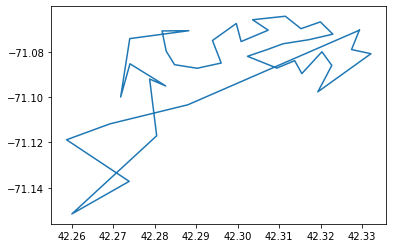

In [33]:
plt.plot(*Black_CC_poly.exterior.xy)

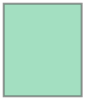

In [38]:
point_collection = geometry.MultiPoint(Coordinates)
point_collection.envelope

In [56]:
import sys
!{sys.executable} -m pip install geopandas

     |████████████████████████████████| 962kB 1.5MB/s eta 0:00:01
     |████████████████████████████████| 13.9MB 3.4MB/s eta 0:00:01
     |████████████████████████████████| 13.0MB 4.6MB/s eta 0:00:01


In [22]:
Primary_Sub_Unique = Black_Census_Tracts['Primary Sub-Neighborhood'].unique()
Secondary_Sub_Unique = Black_Census_Tracts['Secondary Sub-Neighborhood'].unique()
Teritiary_Sub_Unique = Black_Census_Tracts['Teritriary Sub-Neighborhood(s)'].unique()
Commuter_Unique = Black_Census_Tracts['T-Stop/Commuter Rail'].unique()



In [23]:
Primary_Sub_Unique

array(['Lower Roxbury', 'Nubian Square', 'Washington Park ',
       'Washington Park', 'Roxbury', 'Grove Hall', 'Franklin Field South',
       'Bowdoin North/Mount Bodoin', 'Dudley/Brunswick King',
       "Upham's Corner", 'Jones Hill', 'Meeting House Hill', 'Dorchester',
       'Dorcehster Center', 'West Codman Hill/ West Lower Mills',
       'Codman Square', 'Milton Hill', 'Southern Mattapan', 'Mattapan',
       'Wellington Hill', 'Washington Hill', 'Washington /Mount Hope',
       'Hyde Park', 'Metropolitan Hill/Beech Street',
       'West Street/River Street', 'Forest Hills/Woodbourne'],
      dtype=object)

In [24]:
Secondary_Sub_Unique

array(['Columbus Park / Andrew Square', 'Lower Roxbury',
       'Frederick Douglas Square Historic District', 'Roxbury',
       'Fort Hill', 'Washington Park', 'Dudley/Brunswick King',
       'Bowdoin North / Mount Bowdoin', 'Grove Hall', 'Jones Hill',
       "Upham's Corner", 'Dorchester', 'Gorve Hall',
       'Franklin Field North', 'Fields Corner West', 'Codman Square',
       'West Codman Hill / West Lower Mills', nan, 'Ashmont',
       'Dorchester Center', 'Mattapan', 'Roslindale', 'West Roxbury',
       'West Street/River Street'], dtype=object)

In [25]:
Teritiary_Sub_Unique

array(['Nubian Square', 'Columbus Park/Andrew Square', 'Egleston Square',
       nan, 'Meeting House Hall', "Upham's Corner", 'Jones Hill',
       'Bowdoin North/Mount Bodoin', 'Lower Washington/Mount Hope'],
      dtype=object)

In [26]:
Commuter_Unique 

array(['Massachustts Ave @ Peirson St',
       'Dudley St @ Adams St / Dearborn St.', 'Ruggles',
       'Colubmus Ave @ Dimock St / Jackson Square',
       'Washington St @ ML King Blvd / Jackson Square',
       'Walnut Ave @ Rockland St',
       'Warren St @ Woodbine / Blue Hill Ave and West Cottage St', nan,
       'Warren St @ Gaston St', 'Old Rd @ Ellington St',
       'Geneva Ave @ Jeremiah Burke High School / Four Corners/Geneva',
       'Uphams Corner', 'Uphams Corner / Newmarket',
       'Hancock Hill @ Trull and Rowell', 'Four Corners/Geneva',
       'Fields Corner', 'Talbot Ave / Shawmut', 'Talbot Ave',
       'Morton Street', 'Ashmont / Peabody Square',
       'Central Ave/ Milton/Butler', 'Mlue Hill Avenue',
       'American Legion Highway @ Stella'], dtype=object)

In [27]:
Neighborhood_Names_List = []
for primary in Primary_Sub_Unique:
    Neighborhood_Names_List.append(primary)
   
for secondary in Secondary_Sub_Unique:
    Neighborhood_Names_List.append(secondary)
    
for teritiary in Secondary_Sub_Unique:
    Neighborhood_Names_List.append(teritiary)

for stops in Commuter_Unique:
    Neighborhood_Names_List.append(stops)

print(Neighborhood_Names_List)    

['Lower Roxbury', 'Nubian Square', 'Washington Park ', 'Washington Park', 'Roxbury', 'Grove Hall', 'Franklin Field South', 'Bowdoin North/Mount Bodoin', 'Dudley/Brunswick King', "Upham's Corner", 'Jones Hill', 'Meeting House Hill', 'Dorchester', 'Dorcehster Center', 'West Codman Hill/ West Lower Mills', 'Codman Square', 'Milton Hill', 'Southern Mattapan', 'Mattapan', 'Wellington Hill', 'Washington Hill', 'Washington /Mount Hope', 'Hyde Park', 'Metropolitan Hill/Beech Street', 'West Street/River Street', 'Forest Hills/Woodbourne', 'Columbus Park / Andrew Square', 'Lower Roxbury', 'Frederick Douglas Square Historic District', 'Roxbury', 'Fort Hill', 'Washington Park', 'Dudley/Brunswick King', 'Bowdoin North / Mount Bowdoin', 'Grove Hall', 'Jones Hill', "Upham's Corner", 'Dorchester', 'Gorve Hall', 'Franklin Field North', 'Fields Corner West', 'Codman Square', 'West Codman Hill / West Lower Mills', nan, 'Ashmont', 'Dorchester Center', 'Mattapan', 'Roslindale', 'West Roxbury', 'West Street

In [28]:
Neighborhood_Names_List = list(dict.fromkeys(Neighborhood_Names_List))
print(Neighborhood_Names_List) 

['Lower Roxbury', 'Nubian Square', 'Washington Park ', 'Washington Park', 'Roxbury', 'Grove Hall', 'Franklin Field South', 'Bowdoin North/Mount Bodoin', 'Dudley/Brunswick King', "Upham's Corner", 'Jones Hill', 'Meeting House Hill', 'Dorchester', 'Dorcehster Center', 'West Codman Hill/ West Lower Mills', 'Codman Square', 'Milton Hill', 'Southern Mattapan', 'Mattapan', 'Wellington Hill', 'Washington Hill', 'Washington /Mount Hope', 'Hyde Park', 'Metropolitan Hill/Beech Street', 'West Street/River Street', 'Forest Hills/Woodbourne', 'Columbus Park / Andrew Square', 'Frederick Douglas Square Historic District', 'Fort Hill', 'Bowdoin North / Mount Bowdoin', 'Gorve Hall', 'Franklin Field North', 'Fields Corner West', 'West Codman Hill / West Lower Mills', nan, 'Ashmont', 'Dorchester Center', 'Roslindale', 'West Roxbury', 'Massachustts Ave @ Peirson St', 'Dudley St @ Adams St / Dearborn St.', 'Ruggles', 'Colubmus Ave @ Dimock St / Jackson Square', 'Washington St @ ML King Blvd / Jackson Squar

In [29]:
Primary_sub_Black_slash = []
Primary_sub_Black_split = []

for sub in Neighborhood_Names_List:
    str_sub = str(sub)
    if str_sub != "nan":
        Primary_sub_Black_slash.extend(str_sub.split("/"))

st = ' St'        
for sub in Primary_sub_Black_slash:    
    Primary_sub_Black_split.extend(sub.split("@"))
    

#for sub in Primary_sub_Black_split:
    #if st in sub:        
        #Primary_sub_Black_split.append(sub +'reet')
#print(Primary_sub_Black_split)

Primary_sub_Black_split = list(dict.fromkeys(Primary_sub_Black_split))
print(Primary_sub_Black_split)

['Lower Roxbury', 'Nubian Square', 'Washington Park ', 'Washington Park', 'Roxbury', 'Grove Hall', 'Franklin Field South', 'Bowdoin North', 'Mount Bodoin', 'Dudley', 'Brunswick King', "Upham's Corner", 'Jones Hill', 'Meeting House Hill', 'Dorchester', 'Dorcehster Center', 'West Codman Hill', ' West Lower Mills', 'Codman Square', 'Milton Hill', 'Southern Mattapan', 'Mattapan', 'Wellington Hill', 'Washington Hill', 'Washington ', 'Mount Hope', 'Hyde Park', 'Metropolitan Hill', 'Beech Street', 'West Street', 'River Street', 'Forest Hills', 'Woodbourne', 'Columbus Park ', ' Andrew Square', 'Frederick Douglas Square Historic District', 'Fort Hill', 'Bowdoin North ', ' Mount Bowdoin', 'Gorve Hall', 'Franklin Field North', 'Fields Corner West', 'West Codman Hill ', 'Ashmont', 'Dorchester Center', 'Roslindale', 'West Roxbury', 'Massachustts Ave ', ' Peirson St', 'Dudley St ', ' Adams St ', ' Dearborn St.', 'Ruggles', 'Colubmus Ave ', ' Dimock St ', ' Jackson Square', 'Washington St ', ' ML Kin

In [31]:
# Remove the strings with a single string difference, mostly to account for a difference of a space
for names in Primary_sub_Black_split:
    for reverse in Primary_sub_Black_split[::-1]:
        if distance(names, reverse) == 1:
            Primary_sub_Black_split.remove(names)
print(Primary_sub_Black_split)

['Lower Roxbury', 'Nubian Square', 'Washington Park', 'Roxbury', 'Grove Hall', 'Franklin Field South', 'Mount Bodoin', 'Dudley', 'Brunswick King', 'Jones Hill', 'Meeting House Hill', 'Dorchester', 'Dorcehster Center', ' West Lower Mills', 'Codman Square', 'Milton Hill', 'Southern Mattapan', 'Mattapan', 'Wellington Hill', 'Washington Hill', 'Washington ', 'Mount Hope', 'Hyde Park', 'Metropolitan Hill', 'Beech Street', 'West Street', 'River Street', 'Forest Hills', 'Woodbourne', 'Columbus Park ', ' Andrew Square', 'Frederick Douglas Square Historic District', 'Fort Hill', 'Bowdoin North ', ' Mount Bowdoin', 'Gorve Hall', 'Franklin Field North', 'Fields Corner West', 'West Codman Hill ', 'Dorchester Center', 'Roslindale', 'West Roxbury', 'Massachustts Ave ', ' Peirson St', 'Dudley St ', ' Adams St ', ' Dearborn St.', 'Ruggles', 'Colubmus Ave ', ' Dimock St ', ' Jackson Square', 'Washington St ', ' ML King Blvd ', 'Walnut Ave ', ' Rockland St', 'Warren St ', ' Woodbine ', ' Blue Hill Ave a

In [33]:
#Primary_sub_Black_split.remove('Washington Park')
Primary_sub_Black_split

['Lower Roxbury',
 'Nubian Square',
 'Washington Park',
 'Roxbury',
 'Grove Hall',
 'Franklin Field South',
 'Mount Bodoin',
 'Dudley',
 'Brunswick King',
 'Jones Hill',
 'Meeting House Hill',
 'Dorchester',
 'Dorcehster Center',
 ' West Lower Mills',
 'Codman Square',
 'Milton Hill',
 'Southern Mattapan',
 'Mattapan',
 'Wellington Hill',
 'Washington Hill',
 'Washington ',
 'Mount Hope',
 'Hyde Park',
 'Metropolitan Hill',
 'Beech Street',
 'West Street',
 'River Street',
 'Forest Hills',
 'Woodbourne',
 'Columbus Park ',
 ' Andrew Square',
 'Frederick Douglas Square Historic District',
 'Fort Hill',
 'Bowdoin North ',
 ' Mount Bowdoin',
 'Gorve Hall',
 'Franklin Field North',
 'Fields Corner West',
 'West Codman Hill ',
 'Dorchester Center',
 'Roslindale',
 'West Roxbury',
 'Massachustts Ave ',
 ' Peirson St',
 'Dudley St ',
 ' Adams St ',
 ' Dearborn St.',
 'Ruggles',
 'Colubmus Ave ',
 ' Dimock St ',
 ' Jackson Square',
 'Washington St ',
 ' ML King Blvd ',
 'Walnut Ave ',
 ' Rockl

In [32]:
for names in Primary_sub_Black_split:
    print(Neighborhood_Search(names))

('Lower Roxbury', 27)
('Nubian Square', 0)
('Washington Park', 45)
('Roxbury', 5326)
('Grove Hall', 269)
('Franklin Field South', 2)
('Mount Bodoin', 0)
('Dudley', 1096)
('Brunswick King', 0)
('Jones Hill', 9)
('Meeting House Hill', 12)
('Dorchester', 7868)
('Dorcehster Center', 0)
(' West Lower Mills', 0)
('Codman Square', 65)
('Milton Hill', 3)
('Southern Mattapan', 0)
('Mattapan', 1976)
('Wellington Hill', 5)
('Washington Hill', 0)
('Washington ', 1861)
('Mount Hope', 17)
('Hyde Park', 1302)
('Metropolitan Hill', 0)
('Beech Street', 4)
('West Street', 69)
('River Street', 176)
('Forest Hills', 137)
('Woodbourne', 0)
('Columbus Park ', 51)
(' Andrew Square', 68)
('Frederick Douglas Square Historic District', 0)
('Fort Hill', 57)
('Bowdoin North ', 0)
(' Mount Bowdoin', 4)
('Gorve Hall', 0)
('Franklin Field North', 0)
('Fields Corner West', 0)
('West Codman Hill ', 0)
('Dorchester Center', 6)
('Roslindale', 1196)
('West Roxbury', 1131)
('Massachustts Ave ', 0)
(' Peirson St', 0)
('Dud

In [71]:
Neighborhoods_Sans_Black = Neighborhoods_df[Neighborhoods_df.apply(lambda x: x.values.tolist() not in Black_Census_Tracts.values.tolist(), axis=1)]

Neighborhoods_Sans_Black

Census Tract#       Zipcode   Neighborhood US Geonames Sub-neigborhood  \
0             1.00  02134, 02135       Brighton                         NaN   
1             2.01         02135       Brighton                         NaN   
2             2.02         02135       Brighton                         NaN   
3             3.01         02135       Brighton                         NaN   
4             3.02         02135       Brighton                         NaN   
..             ...           ...            ...                         ...   
176        9815.02         02151    East Boston                         NaN   
177        9816.00         02128    East Boston                         NaN   
178        9817.00         02116    Beacon Hill                         NaN   
179        9818.00  02130, 02215  Jamaica Plain                         NaN   
180        9901.01         02130            NaN                         NaN   

     Total Population   Black  Black Proportion  White  White Proportion  \
0                5324     311          0.058415   3315          0.622652   
1                3991     237          0.059384   3164          0.792784   
2                4272     263          0.061564   3031          0.709504   
3                2946     216          0.073320   2203          0.747794   
4                3469     359          0.103488   2346          0.676276   
..                ...     ...               ...    ...               ...   
176                 0       0          0.000000      0          0.000000   
177                 0       0          0.000000      0          0.000000   
178                 0       0          0.000000      0          0.000000   
179                26       9          0.346154     17          0.653846   
180                67      18          0.268657     49          0.731343   

     American Indian & Alaska Native  ...  Male   Male Proportion  Female   \
0                                  0  ...   2578         0.484222     2746   
1                                 17  ...   1800         0.451015     2191   
2                                  0  ...   2175         0.509129     2097   
3                                  0  ...   1650         0.560081     1296   
4                                 25  ...   1733         0.499568     1736   
..                               ...  ...    ...              ...      ...   
176                                0  ...      0         0.000000        0   
177                                0  ...      0         0.000000        0   
178                                0  ...      0         0.000000        0   
179                                0  ...      4         0.153846       22   
180                                0  ...     55         0.820896       12   

     Female Proportion         Lat       Long  Primary Sub-Neighborhood  \
0              0.515778  42.361485 -71.138588             Lower Allston   
1              0.548985  42.354066 -71.161168                Oak Square   
2              0.490871  42.352605 -71.154344                Oak Square   
3              0.439919  42.354144 -71.168827             Hunnwell Hill   
4              0.500432  42.347258 -71.167686                  Brighton   
..                  ...        ...        ...                       ...   
176            0.000000  42.396367 -71.004379                 Beachmont   
177            0.000000  42.388621 -70.993442            Orient Heights   
178            0.000000  42.355087 -71.065743         Downtown Crossing   
179            0.846154  42.323121 -71.116882          High Street Hill   
180            0.179104  42.329611 -70.949200                       NaN   

     Secondary Sub-Neighborhood  Teritriary Sub-Neighborhood(s)  \
0                       Allston                Packard's Corner   
1                      Brighton                  Hunnewell Hill   
2                      Brighton                         Allston   
3                    Oak Square      

In [34]:
OPrimary_Sub_Unique = Neighborhoods_Sans_Black['Primary Sub-Neighborhood'].unique()
OSecondary_Sub_Unique = Neighborhoods_Sans_Black['Secondary Sub-Neighborhood'].unique()
OTeritiary_Sub_Unique = Neighborhoods_Sans_Black['Teritriary Sub-Neighborhood(s)'].unique()
OCommuter_Unique = Neighborhoods_Sans_Black['T-Stop/Commuter Rail'].unique()

Other_Names_List = []
for primary in OPrimary_Sub_Unique:
    Other_Names_List.append(primary)
   
for secondary in OSecondary_Sub_Unique:
    Other_Names_List.append(secondary)
    
for teritiary in OTeritiary_Sub_Unique:
    Other_Names_List.append(teritiary)
    
for stops in OCommuter_Unique:
    Other_Names_List.append(stops)

print(Other_Names_List)   

['Lower Allston', 'Oak Square', 'Hunnwell Hill', 'Brighton', "St. Elizabeth's", 'Chestnut Hill Neighborhood Association', 'Aberdeen', 'Salisbury Road-Corey Farm', 'Allston', 'Back Bay', 'West Fens', 'Fenway-Kenmore', 'Frederick Douglas Square Historic District', 'Back Bay West / Back Bay', 'West End', 'Bunker Hill', 'Charlestown', 'Boston', 'East Boston', nan, 'Medford Street/The Neck', 'Eagle Hill', 'Central Maverick Square/Paris Square', 'Orient Heights', 'Harbor View/Orient Heights', 'Jeffries Point', 'City Point', 'Telegraph Hill', 'Seaport District', 'D Street / West Broadway', 'South Boston', 'Columbus Park/Andrew Square', 'Downtown Crossing', 'China Town', 'Bay Village', 'Shawmut', 'Columbus', 'South End', 'Mission Hill', 'Central Village', 'Fort Hill', "Upham's Corner", 'Jones Hill', 'Meeting House Hill', 'Clam Point', 'Fields Corner Wester', 'St. Marks', 'Neponset/Port Norfolk', 'Adams Village', 'Ashmount', 'Forest Hills/Woodbourne', 'Roslindale ', 'Metropolitan Hill/Beech Str

In [35]:
Other_Names_List = list(dict.fromkeys(Other_Names_List))
print(Other_Names_List)

['Lower Allston', 'Oak Square', 'Hunnwell Hill', 'Brighton', "St. Elizabeth's", 'Chestnut Hill Neighborhood Association', 'Aberdeen', 'Salisbury Road-Corey Farm', 'Allston', 'Back Bay', 'West Fens', 'Fenway-Kenmore', 'Frederick Douglas Square Historic District', 'Back Bay West / Back Bay', 'West End', 'Bunker Hill', 'Charlestown', 'Boston', 'East Boston', nan, 'Medford Street/The Neck', 'Eagle Hill', 'Central Maverick Square/Paris Square', 'Orient Heights', 'Harbor View/Orient Heights', 'Jeffries Point', 'City Point', 'Telegraph Hill', 'Seaport District', 'D Street / West Broadway', 'South Boston', 'Columbus Park/Andrew Square', 'Downtown Crossing', 'China Town', 'Bay Village', 'Shawmut', 'Columbus', 'South End', 'Mission Hill', 'Central Village', 'Fort Hill', "Upham's Corner", 'Jones Hill', 'Meeting House Hill', 'Clam Point', 'Fields Corner Wester', 'St. Marks', 'Neponset/Port Norfolk', 'Adams Village', 'Ashmount', 'Forest Hills/Woodbourne', 'Roslindale ', 'Metropolitan Hill/Beech Str

In [36]:
Primary_sub_Other_slash = []
Primary_sub_Other_split =[]

for sub in Other_Names_List:
    str_sub = str(sub)
    if str_sub != "nan":
        Primary_sub_Other_slash.extend(str_sub.split("/"))
        
for sub in Primary_sub_Other_slash:    
    Primary_sub_Other_split.extend(sub.split("@"))
    
print(Primary_sub_Other_split)

['Lower Allston', 'Oak Square', 'Hunnwell Hill', 'Brighton', "St. Elizabeth's", 'Chestnut Hill Neighborhood Association', 'Aberdeen', 'Salisbury Road-Corey Farm', 'Allston', 'Back Bay', 'West Fens', 'Fenway-Kenmore', 'Frederick Douglas Square Historic District', 'Back Bay West ', ' Back Bay', 'West End', 'Bunker Hill', 'Charlestown', 'Boston', 'East Boston', 'Medford Street', 'The Neck', 'Eagle Hill', 'Central Maverick Square', 'Paris Square', 'Orient Heights', 'Harbor View', 'Orient Heights', 'Jeffries Point', 'City Point', 'Telegraph Hill', 'Seaport District', 'D Street ', ' West Broadway', 'South Boston', 'Columbus Park', 'Andrew Square', 'Downtown Crossing', 'China Town', 'Bay Village', 'Shawmut', 'Columbus', 'South End', 'Mission Hill', 'Central Village', 'Fort Hill', "Upham's Corner", 'Jones Hill', 'Meeting House Hill', 'Clam Point', 'Fields Corner Wester', 'St. Marks', 'Neponset', 'Port Norfolk', 'Adams Village', 'Ashmount', 'Forest Hills', 'Woodbourne', 'Roslindale ', 'Metropol

In [37]:
for names in Primary_sub_Other_split:
    print(Neighborhood_Search(names))

('Lower Allston', 8)
('Oak Square', 17)
('Hunnwell Hill', 0)
('Brighton', 768)
("St. Elizabeth's", 0)
('Chestnut Hill Neighborhood Association', 0)
('Aberdeen', 8)
('Salisbury Road-Corey Farm', 0)
('Allston', 540)
('Back Bay', 826)
('West Fens', 0)
('Fenway-Kenmore', 0)
('Frederick Douglas Square Historic District', 0)
('Back Bay West ', 0)
(' Back Bay', 824)
('West End', 127)
('Bunker Hill', 242)
('Charlestown', 693)
('Boston', 15633)
('East Boston', 984)
('Medford Street', 0)
('The Neck', 3)
('Eagle Hill', 12)
('Central Maverick Square', 0)
('Paris Square', 0)
('Orient Heights', 31)
('Harbor View', 30)
('Orient Heights', 31)
('Jeffries Point', 27)
('City Point', 19)
('Telegraph Hill', 6)
('Seaport District', 229)
('D Street ', 27)
(' West Broadway', 54)
('South Boston', 1908)
('Columbus Park', 55)
('Andrew Square', 68)
('Downtown Crossing', 189)
('China Town', 0)
('Bay Village', 65)
('Shawmut', 123)
('Columbus', 255)
('South End', 1383)
('Mission Hill', 495)
('Central Village', 0)
('

In [38]:
s1 = set(Primary_sub_Black_split)
s2 = set(Primary_sub_Other_split)
Other_Names_Only = s2 - s1

In [39]:
Other_Names_Only

{'',
 ' 88 E Newton St ',
 ' Adams St',
 ' Back Bay',
 ' Back of the Hill',
 ' Broadway',
 ' Burke St',
 ' Cedar St',
 ' China Town',
 ' Columbus Ave',
 ' E St',
 ' Faulkner Hospital',
 ' Fenway',
 ' Forest Hills',
 ' Gavin Way',
 ' Goud',
 ' Havre St',
 ' Hynes Convention Center',
 ' Jersey St',
 ' Mercer St',
 ' P St',
 ' P Street',
 ' Paul A Dever School',
 ' Prudential',
 ' Reservoir',
 ' River Street',
 ' Spring Street',
 ' The Neck',
 ' Tufts Med Ctr',
 ' West Broadway',
 ' Wren',
 '8th St',
 '91 E Concord St ',
 'Aberdeen',
 'Adams Village',
 'Admirals Hill',
 'Airport',
 'Allston',
 'Allston Street',
 'Andrew Square',
 'Arlington',
 'Ashcroft',
 'Ashmont',
 'Ashmount',
 'Assembly Square',
 'BU Central',
 'Babcock Street',
 'Back Bay',
 'Back Bay West ',
 'Bay Village',
 'Beachmont',
 'Bellevue',
 'Bellevue Hill',
 'Berkley St ',
 'Blanchard Street',
 'Boston',
 'Boston Landing',
 'Boston St and Dorset St ',
 'Boston Theater District',
 'Bowdoin',
 'Boylston Street',
 'Brigham C

In [33]:
import sys
!{sys.executable} -m pip install python-Levenshtein

  Using cached https://files.pythonhosted.org/packages/42/a9/d1785c85ebf9b7dfacd08938dd028209c34a0ea3b1bcdb895208bd40a67d/python-Levenshtein-0.12.0.tar.gz
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.0-cp37-cp37m-macosx_10_9_x86_64.whl size=76559 sha256=9f2eb47176d8830c6571a0e796464abee0f1422869fc64d48ef3f121ba38cc53
  Stored in directory: /Users/gowthamasokan/Library/Caches/pip/wheels/de/c2/93/660fd5f7559049268ad2dc6d81c4e39e9e36518766eaf7e342
Successfully built python-Levenshtein


In [42]:
Other_Names_List = list(Other_Names_Only)
for names in Other_Names_List:
    for reverse in Other_Names_List[::-1]:
        if distance(names, reverse) == 1:
            Other_Names_List.remove(reverse)

print(Other_Names_List)

['', 'Downtown Crossing', ' Jersey St', ' Back of the Hill', 'Wood Island', 'Copley ', 'Washington', 'Aberdeen', 'Meridan St ', 'Spring Street ', ' Faulkner Hospital', 'Bay Village', 'Cleveland Circle', ' Burke St', 'Heath Street ', 'Central Maverick Square', 'E 8th St ', 'West Fens', 'East Boston', 'Allston Street', 'Mt Vernon St ', 'Chestnut Hill Ave', 'Blanchard Street', 'Fort Point', 'Roxbury ', 'Longwood Medical Area', 'W 6th St ', 'Chiswick Road', 'Adams Village', ' P St', 'Fairmount', 'Seaport District', 'Longwood', 'Hynes Convention Center Station', 'D Street ', 'Cambridgeport', ' Reservoir', 'Queensbury St ', 'Back Bay West ', 'UMass', 'Central Square', 'JFK', 'Central Village', 'East Cambridge', 'Gibson St ', 'Hunnewell Hill', 'Harrison Ave opp. Plympton Street ', ' River Street', ' Cedar St', 'Bunker Hill', ' Paul A Dever School', 'Egleston Square', 'Suffolk Downs', 'Boston Theater District', 'Hyde Park  ', 'Brook Farm', 'Charlestown', 'Lower Roxbury ', 'Boston St and Dorset

In [43]:
print(Other_Names_Only)

{'', 'Downtown Crossing', ' Jersey St', ' Back of the Hill', 'Wood Island', 'Copley ', 'Washington', 'Aberdeen', 'Meridan St ', 'Spring Street ', ' Faulkner Hospital', 'Bay Village', 'Cleveland Circle', ' Burke St', 'Heath Street ', 'Central Maverick Square', 'E 8th St ', 'West Fens', 'East Boston', 'Allston Street', 'Copley', 'Mt Vernon St ', 'Chestnut Hill Ave', 'Blanchard Street', 'Fort Point', 'Roxbury ', 'Longwood Medical Area', 'W 6th St ', 'Chiswick Road', 'Adams Village', ' P St', 'Fairmount', 'Seaport District', 'Longwood', 'Hynes Convention Center Station', 'D Street ', 'Cambridgeport', ' Reservoir', 'Queensbury St ', 'Back Bay West ', 'UMass', 'Central Square', 'JFK', 'Central Village', 'East Cambridge', 'Gibson St ', 'Hunnewell Hill', 'Harrison Ave opp. Plympton Street ', ' River Street', ' Cedar St', 'Bunker Hill', ' Paul A Dever School', 'Egleston Square', 'Suffolk Downs', 'Boston Theater District', 'Hyde Park  ', 'Brook Farm', 'Charlestown', 'Lower Roxbury ', 'Boston St 

In [44]:
Primary_sub_Black_split = list(Primary_sub_Black_split)
for names in Primary_sub_Black_split:
    for reverse in Primary_sub_Black_split[::-1]:
        if distance(names, reverse) == 1:
            Primary_sub_Black_split.remove(reverse)

print(Primary_sub_Black_split)

['Lower Roxbury', 'Nubian Square', 'Washington Park', 'Roxbury', 'Grove Hall', 'Franklin Field South', 'Mount Bodoin', 'Dudley', 'Brunswick King', 'Jones Hill', 'Meeting House Hill', 'Dorchester', 'Dorcehster Center', ' West Lower Mills', 'Codman Square', 'Milton Hill', 'Southern Mattapan', 'Mattapan', 'Wellington Hill', 'Washington Hill', 'Washington ', 'Mount Hope', 'Hyde Park', 'Metropolitan Hill', 'Beech Street', 'West Street', 'River Street', 'Forest Hills', 'Woodbourne', 'Columbus Park ', ' Andrew Square', 'Frederick Douglas Square Historic District', 'Fort Hill', 'Bowdoin North ', ' Mount Bowdoin', 'Gorve Hall', 'Franklin Field North', 'Fields Corner West', 'West Codman Hill ', 'Dorchester Center', 'Roslindale', 'West Roxbury', 'Massachustts Ave ', ' Peirson St', 'Dudley St ', ' Adams St ', ' Dearborn St.', 'Ruggles', 'Colubmus Ave ', ' Dimock St ', ' Jackson Square', 'Washington St ', ' ML King Blvd ', 'Walnut Ave ', ' Rockland St', 'Warren St ', ' Woodbine ', ' Blue Hill Ave a

In [45]:
print(Primary_sub_Black_split)
Major_Neighborhoods = ['Allston', 'Beacon Hill', 'Chinatown', 'Financial District', 'Leather District', 'Mission Hill',
                      'Roxbury', 'Fenway', 'West Roxbury', 'Back Bay', 'Brighton', 'Dorchester','Hyde Park',
                      'Mattapan','North End','Seaport','Waterfront','Bay Village','Charlestown',
                      'East Boston','Jamaica Plain','Midtown','Roslindale','South End','West End']

Black_Major = []
for names in Primary_sub_Black_split:
    if names in Major_Neighborhoods:
        Black_Major.append(names)
        Primary_sub_Black_split.remove(names)
        
print('Black Sub-Neighborhoods', Primary_sub_Black_split)
print('---------------------------')
print('Black Major Neighborhoods', Black_Major)


['Lower Roxbury', 'Nubian Square', 'Washington Park', 'Roxbury', 'Grove Hall', 'Franklin Field South', 'Mount Bodoin', 'Dudley', 'Brunswick King', 'Jones Hill', 'Meeting House Hill', 'Dorchester', 'Dorcehster Center', ' West Lower Mills', 'Codman Square', 'Milton Hill', 'Southern Mattapan', 'Mattapan', 'Wellington Hill', 'Washington Hill', 'Washington ', 'Mount Hope', 'Hyde Park', 'Metropolitan Hill', 'Beech Street', 'West Street', 'River Street', 'Forest Hills', 'Woodbourne', 'Columbus Park ', ' Andrew Square', 'Frederick Douglas Square Historic District', 'Fort Hill', 'Bowdoin North ', ' Mount Bowdoin', 'Gorve Hall', 'Franklin Field North', 'Fields Corner West', 'West Codman Hill ', 'Dorchester Center', 'Roslindale', 'West Roxbury', 'Massachustts Ave ', ' Peirson St', 'Dudley St ', ' Adams St ', ' Dearborn St.', 'Ruggles', 'Colubmus Ave ', ' Dimock St ', ' Jackson Square', 'Washington St ', ' ML King Blvd ', 'Walnut Ave ', ' Rockland St', 'Warren St ', ' Woodbine ', ' Blue Hill Ave a

In [13]:
Check = ['Lower Roxbury', 'Nubian Square', 'Washington Park', 'Grove Hall', 'Franklin Field South', 'Mount Bodoin', 'Dudley', 'Brunswick King', 'Jones Hill', 'Meeting House Hill', 'Dorcehster Center', ' West Lower Mills', 'Codman Square', 'Milton Hill', 'Southern Mattapan', 'Wellington Hill', 'Washington Hill', 'Washington ', 'Mount Hope', 'Metropolitan Hill', 'Beech Street', 'West Street', 'River Street', 'Forest Hills', 'Woodbourne', 'Columbus Park ', ' Andrew Square', 'Frederick Douglas Square Historic District', 'Fort Hill', 'Bowdoin North ', ' Mount Bowdoin', 'Gorve Hall', 'Franklin Field North', 'Fields Corner West', 'West Codman Hill ', 'Dorchester Center', 'West Roxbury', 'Massachustts Ave ', ' Peirson St', 'Dudley St ', ' Adams St ', ' Dearborn St.', 'Ruggles', 'Colubmus Ave ', ' Dimock St ', ' Jackson Square', 'Washington St ', ' ML King Blvd ', 'Walnut Ave ', ' Rockland St', 'Warren St ', ' Woodbine ', ' Blue Hill Ave and West Cottage St', ' Gaston St', 'Old Rd ', ' Ellington St', 'Geneva Ave ', ' Jeremiah Burke High School ', 'Geneva', 'Uphams Corner ', ' Newmarket', 'Hancock Hill ', ' Trull and Rowell', 'Four Corners', 'Fields Corner', ' Shawmut', 'Talbot Ave', 'Morton Street', 'Ashmont ', ' Peabody Square', 'Central Ave', ' Milton', 'Butler', 'Mlue Hill Avenue', 'American Legion Highway ', ' Stella']
print(len(Check))         

76


In [46]:


Other_Major = []
for names in Other_Names_List:
    if names in Major_Neighborhoods:
        Other_Major.append(names)
        Other_Names_List.remove(names)
        
print('Other sub-neighborhoods: ', Other_Names_List)
print('Major sub-neighborhoods: ', Other_Major)

Other sub-neighborhoods:  ['', 'Downtown Crossing', ' Jersey St', ' Back of the Hill', 'Wood Island', 'Copley ', 'Washington', 'Aberdeen', 'Meridan St ', 'Spring Street ', ' Faulkner Hospital', 'Cleveland Circle', ' Burke St', 'Heath Street ', 'Central Maverick Square', 'E 8th St ', 'West Fens', 'Allston Street', 'Mt Vernon St ', 'Chestnut Hill Ave', 'Blanchard Street', 'Fort Point', 'Roxbury ', 'Longwood Medical Area', 'W 6th St ', 'Chiswick Road', 'Adams Village', ' P St', 'Fairmount', 'Seaport District', 'Longwood', 'Hynes Convention Center Station', 'D Street ', 'Cambridgeport', ' Reservoir', 'Queensbury St ', 'Back Bay West ', 'UMass', 'Central Square', 'JFK', 'Central Village', 'East Cambridge', 'Gibson St ', 'Hunnewell Hill', 'Harrison Ave opp. Plympton Street ', ' River Street', ' Cedar St', 'Bunker Hill', ' Paul A Dever School', 'Egleston Square', 'Suffolk Downs', 'Boston Theater District', 'Hyde Park  ', 'Brook Farm', 'Lower Roxbury ', 'Boston St and Dorset St ', 'Massachuset

In [14]:
Check2 = ['Downtown Crossing', ' Jersey St', ' Back of the Hill', 'Wood Island', 'Copley ', 'Washington', 'Aberdeen', 'Meridan St ', 'Spring Street ', ' Faulkner Hospital', 'Cleveland Circle', ' Burke St', 'Heath Street ', 'Central Maverick Square', 'E 8th St ', 'West Fens', 'Allston Street', 'Mt Vernon St ', 'Chestnut Hill Ave', 'Blanchard Street', 'Fort Point', 'Roxbury ', 'Longwood Medical Area', 'W 6th St ', 'Chiswick Road', 'Adams Village', ' P St', 'Fairmount', 'Seaport District', 'Longwood', 'Hynes Convention Center Station', 'D Street ', 'Cambridgeport', ' Reservoir', 'Queensbury St ', 'Back Bay West ', 'UMass', 'Central Square', 'JFK', 'Central Village', 'East Cambridge', 'Gibson St ', 'Hunnewell Hill', 'Harrison Ave opp. Plympton Street ', ' River Street', ' Cedar St', 'Bunker Hill', ' Paul A Dever School', 'Egleston Square', 'Suffolk Downs', 'Boston Theater District', 'Hyde Park  ', 'Brook Farm', 'Lower Roxbury ', 'Boston St and Dorset St ', 'Massachusetts Ave', 'Warren Street', 'Winthrop', ' P Street', 'Readville', 'Maverick', 'Cedar Grove', 'Columbus', 'Hyde Park Ave opp Walk Hill St ', ' Havre St', ' 88 E Newton St ', "Packard's Corner", 'Forest Hills Woodbourne', 'Paris Square', 'Arlington', 'Northeastern University', 'Fisher Hill', 'Fairmount Hill', 'South Boston', 'Jerffries Point', 'Medford Street', 'E Broad St ', "Upham's Corner", 'Roxbury Crossing', ' Gavin Way', 'City Point', 'Green Street', 'Port Norfolk', 'Eagle Hill', 'Shawmut', 'Chelsea', 'Highland', ' Fenway', 'Columbia Rd ', 'Lower Alston', 'Andrew Square', ' Spring Street', 'Sullivan Square', 'Old Colony Ave ', 'Oak Square', 'Jamaica Hills', 'Telegraph Hill', 'Ashmount', 'Woodard Rd ', ' Tufts Med Ctr', ' The Neck', 'South Brookline', ' West Broadway', 'opp Harvest St', 'Community College', 'Marina Bay', ' Columbus Ave', 'Roslindale ', 'Admirals Hill', 'South End  ', ' Adams St', 'Oak Hill Park', 'Brookline', 'Boston', '8th St', 'Clam Point', 'South Street', 'Sutherland Road', 'Centre St ', 'Chestnut Hill Neighborhood Association', 'Columbus Park', ' Hynes Convention Center', 'Orient Heights ', 'Neponset', 'Inner Belt', 'Medical Center Area', 'Stonybrook', 'Chestnut Hill Avenue', 'South End of Washington', 'Beachmont', 'Paris Street', 'Allston', 'Cottage Farm Historic District', 'Bellevue', 'Washington Street', 'Assembly Square', 'High Street Hill', 'Roslindale Village', 'Tremont St ', 'North Station', 'Berkley St ', 'South Station', 'Upper Washington', 'Savin Hill', "St. Elizabeth's", 'Bowdoin', 'China Town', 'Babcock Street', 'Charles', 'Corey Hill', 'Jackson Square', 'Salisbury Road-Corey Farm', 'Bellevue Hill', 'Orient Heights         ', 'Mission Park', 'Fenwood Road', ' Broadway', 'Stony Brook', 'South Point', 'BU Central', 'Haymarket', ' Prudential', 'Georgetown', 'Ashcroft', ' Mercer St', 'Tufts Medical Center', 'Brigham Circle', ' Forest Hills', 'Boston Landing', 'St. Marks', 'West Street ', ' Goud', 'Boylston Street', 'Centre South', 'Fenwood Rd', 'Lower Washington', 'Airport', 'Harbor View', 'Lansdowne ', 'Fenway-Kenmore', 'MGH', '91 E Concord St ', 'Opp 43 W Dedham St', ' Wren', 'Fields Corner Wester', 'Kenmore']
print(len(Check2))         
          
          

186


In [5]:
def Name_Search(Name_type):
    S_nlist = []
    for n in Name_type:
        S_nlist.append(Neighborhood_Search(n))
    #print(S_nlist)
    Names = []
    Count = []
    for x in S_nlist:
        Names.append(x[0])
    for num in S_nlist:
        Count.append(num[1])

    #print(Names)

    Neighborhoods_data = {'Name': Names,
            'Count': Count
            }
    df_neigh = pd.DataFrame(Neighborhoods_data, columns = ['Name', 'Count'])
    dedupe_df = df_neigh.drop_duplicates()
    return dedupe_df

#print(Name_Search(Other_Names_List)['Count'].sum())

In [48]:
Name_Search(Primary_sub_Black_split)

Name  Count
0              Lower Roxbury     27
1              Nubian Square      0
2            Washington Park     45
3                 Grove Hall    269
4       Franklin Field South      2
..                       ...    ...
71                    Milton    573
72                    Butler    159
73          Mlue Hill Avenue      0
74  American Legion Highway      21
75                    Stella     32

[76 rows x 2 columns]

In [49]:
Name_Search(Primary_sub_Black_split)['Count'].sum()

7360

In [50]:
Name_Search(Other_Names_List)

Name  Count
0                          22908
1       Downtown Crossing    189
2               Jersey St     37
3        Back of the Hill      0
4             Wood Island      1
..                    ...    ...
182      91 E Concord St       0
183    Opp 43 W Dedham St      0
184                  Wren     53
185  Fields Corner Wester      0
186               Kenmore    150

[187 rows x 2 columns]

In [51]:
Name_Search(Other_Names_List)['Count'].sum()

64198

In [44]:
print(Name_Search(Primary_sub_Black_split)['Count'].sum())

7828


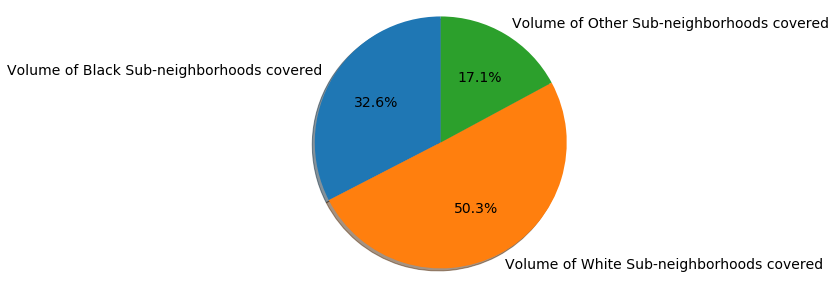

In [25]:
#print(Name_Search(Primary_sub_Black_split)['Count'].sum())
labels = 'Volume of Black Sub-neighborhoods covered', 'Volume of White Sub-neighborhoods covered', 'Volume of Other Sub-neighborhoods covered'

# 24,992 out of 51,716
sizes = [24992, 38578, 13138]

fig1, ax1 = plt.subplots()
fig1.set_size_inches(5,5)
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
                shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
mpl.rcParams['font.size'] = 14.0
plt.show()

In [36]:
data_df_final

text
0      ['The Boston Police Department has issued a co...
1      ['\n individuals who worked in finance, insura...
2      ['Dr. Kenneth C. Edelin, whose historic 1975 m...
3      ['The first words in the Bible are “In the beg...
4      ['When they go up, they form the centerpiece o...
...                                                  ...
22903  ['\n\n\n fair. After years of bad policy decis...
22904  ['The governor, the mayor, the head of the Mas...
22905  ['The number of students disciplined in school...
22906  ['Hundreds of species are facing extinction du...
22907  ['Boston will record its warmest December in m...

[22908 rows x 1 columns]

In [52]:
Sentiment_df = pd.read_csv('Black_Neighborhoods_Coverage.csv')
Sentiment_df

Name  Count  Vader Sentiment
0              Lower Roxbury     27         0.761278
1              Nubian Square      0         0.000000
2            Washington Park     45         0.729509
3                 Grove Hall    269         0.332162
4       Franklin Field South      2         0.961300
..                       ...    ...              ...
71                    Milton    573         0.212844
72                    Butler    159         0.517960
73          Mlue Hill Avenue      0         0.000000
74  American Legion Highway      21        -0.519343
75                    Stella     32         0.982050

[76 rows x 3 columns]

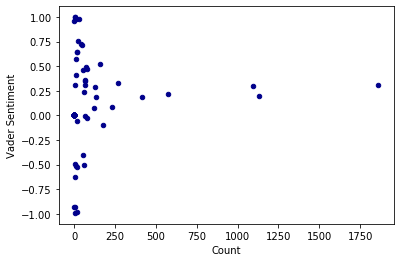

In [96]:
ax1 = Sentiment_df.plot.scatter(x='Count',
                      y='Vader Sentiment',
                      c='DarkBlue')


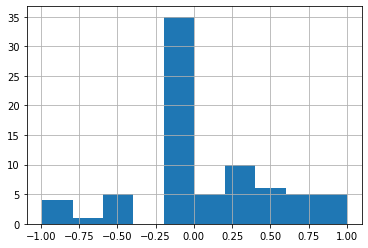

In [54]:
Sentiment_df['Vader Sentiment'].hist()

In [53]:
Other_Sentiment_df = pd.read_csv('Other_Neighborhoods_Coverage.csv')
Other_Sentiment_df

Name  Count  Vader Sentiment
0     Admirals Hill      3         0.995533
1         St. Marks      7         0.998000
2        Georgetown    728         0.552604
3     Hunnwell Hill      0         0.000000
4      South Street     26         0.382677
..              ...    ...              ...
180     Bunker Hill    242         0.532292
181     E Broad St       0         0.000000
182  Telegraph Hill      6         0.989367
183        Havre St      3         0.988700
184        Ashcroft      6        -0.981000

[185 rows x 3 columns]

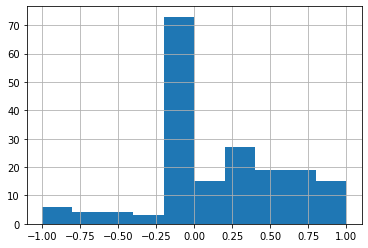

In [55]:
Other_Sentiment_df['Vader Sentiment'].hist()

In [56]:
import math
Coverage_List_Black = []
for count, sent in zip(Sentiment_df['Count'],Sentiment_df['Vader Sentiment']):
    coverage = count*sent
    Coverage_List_Black.append(coverage)
    
BlackSe = pd.Series(Coverage_List_Black)
Sentiment_df['Coverage'] = BlackSe.values


Sentiment_df = Sentiment_df[Sentiment_df['Vader Sentiment'] != 0] 

Log_scores = []
for coverage in Sentiment_df['Coverage']:
    if coverage < 0:
        Abs_value = coverage * (-1)
        Log_scores.append(math.log10(Abs_value) * (-1))
    else:
        Log_scores.append(math.log10(coverage))

LogSe = pd.Series(Log_scores)
Sentiment_df['Coverage_Log'] = LogSe.values
        
        
        
#Sentiment_df['Coverage_Log'] = np.log10(Sentiment_df['Coverage'])

Sentiment_df

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Name  Count  Vader Sentiment  Coverage  \
0                  Lower Roxbury     27         0.761278   20.5545   
2                Washington Park     45         0.729509   32.8279   
3                     Grove Hall    269         0.332162   89.3516   
4           Franklin Field South      2         0.961300    1.9226   
6                         Dudley   1096         0.303780  332.9434   
8                     Jones Hill      9         0.979200    8.8128   
9             Meeting House Hill     12        -0.510575   -6.1269   
12                 Codman Square     65         0.312495   20.3122   
13                   Milton Hill      3         0.997500    2.9925   
15               Wellington Hill      5        -0.931880   -4.6594   
17                   Washington    1861         0.311263  579.2598   
18                    Mount Hope     17         0.647206   11.0025   
20                  Beech Street      4        -0.496075   -1.9843   
21                   West Street     69        -0.001588   -0.1096   
22                  River Street    176        -0.100574  -17.7010   
23                  Forest Hills    137         0.183575   25.1498   
25                Columbus Park      51         0.718696   36.6535   
26                 Andrew Square     68         0.360693   24.5271   
28                     Fort Hill     57         0.464449   26.4736   
30                 Mount Bowdoin      4        -0.990625   -3.9625   
35             Dorchester Center      6         0.313333    1.8800   
36                  West Roxbury   1131         0.197717  223.6176   
41                  Dearborn St.      3        -0.626833   -1.8805   
42                       Ruggles     78        -0.030110   -2.3486   
45                Jackson Square     72         0.495871   35.7027   
49                   Rockland St     10         0.414930    4.1493   
51                     Woodbine       6         0.997333    5.9840   
53                     Gaston St      1        -0.932500   -0.9325   
55                  Ellington St     17        -0.978882  -16.6410   
57   Jeremiah Burke High School      17        -0.052935   -0.8999   
58                        Geneva    413         0.191335   79.0214   
59                Uphams Corner      64         0.349627   22.3761   
60                     Newmarket     79         0.468386   37.0025   
63                  Four Corners     63         0.234825   14.7940   
64                 Fields Corner    129         0.285684   36.8533   
65                       Shawmut    123         0.072615    8.9317   
66                    Talbot Ave     55        -0.407275  -22.4001   
67                 Morton Street     63        -0.508089  -32.0096   
68                      Ashmont     233         0.087148   20.3056   
69                Peabody Square     20         0.644035   12.8807   
70                   Central Ave     14         0.575086    8.0512   
71                        Milton    573         0.212844  121.9596   
72                        Butler    159         0.517960   82.3556   
74      American Legion Highway      21        -0.519343  -10.9062   
75                        Stella     32         0.982050   31.4256   

    Coverage_Log  
0       1.312907  
2       1.516243  
3       1.951102  
4       0.283889  
6       2.522370  
8       0.945114  
9      -0.787241  
12      1.307757  
13      0.476034  
15     -0.668330  
17      2.762873  
18      1.041491  
20     -0.297607  
21      0.960189  
22     -1.247998  
23      1.400535  
25      1.564115  
26      1.389646  
28      1.422813  
30     -0.597969  
35      0.274158  
36      2.349506  
41     -0.274273  
42     -0.370809  
45      1.552701  
49      0.617975  
51      0.776992  
53      0.030351  
55     -1.221179  
57      0.045806  
58      1.897745  
59      1.349784  
60      1.568231  
63      1.170086  
64      1.566476  
65      0.950934  
66     -1.350250  
67     -1.505280  
68      1.307616  
69      1.109939  
70      0.905861  
71      2

In [101]:
#Sentiment_df = Sentiment_df[Sentiment_df['Vader Sentiment'] != 0] 
#Sentiment_df
#sent_list = []
#for x in Sentiment_df['Coverage_Log']:
    #sent_list.append(x)
#sent_list[1]
#type(sent_list[1])


Name  Count  Vader Sentiment  Coverage  \
0                  Lower Roxbury     27         0.761278   20.5545   
2                Washington Park     45         0.729509   32.8279   
3                     Grove Hall    269         0.332162   89.3516   
4           Franklin Field South      2         0.961300    1.9226   
6                         Dudley   1096         0.303780  332.9434   
8                     Jones Hill      9         0.979200    8.8128   
9             Meeting House Hill     12        -0.510575   -6.1269   
12                 Codman Square     65         0.312495   20.3122   
13                   Milton Hill      3         0.997500    2.9925   
15               Wellington Hill      5        -0.931880   -4.6594   
17                   Washington    1861         0.311263  579.2598   
18                    Mount Hope     17         0.647206   11.0025   
20                  Beech Street      4        -0.496075   -1.9843   
21                   West Street     69        -0.001588   -0.1096   
22                  River Street    176        -0.100574  -17.7010   
23                  Forest Hills    137         0.183575   25.1498   
25                Columbus Park      51         0.718696   36.6535   
26                 Andrew Square     68         0.360693   24.5271   
28                     Fort Hill     57         0.464449   26.4736   
30                 Mount Bowdoin      4        -0.990625   -3.9625   
35             Dorchester Center      6         0.313333    1.8800   
36                  West Roxbury   1131         0.197717  223.6176   
41                  Dearborn St.      3        -0.626833   -1.8805   
42                       Ruggles     78        -0.030110   -2.3486   
45                Jackson Square     72         0.495871   35.7027   
49                   Rockland St     10         0.414930    4.1493   
51                     Woodbine       6         0.997333    5.9840   
53                     Gaston St      1        -0.932500   -0.9325   
55                  Ellington St     17        -0.978882  -16.6410   
57   Jeremiah Burke High School      17        -0.052935   -0.8999   
58                        Geneva    413         0.191335   79.0214   
59                Uphams Corner      64         0.349627   22.3761   
60                     Newmarket     79         0.468386   37.0025   
63                  Four Corners     63         0.234825   14.7940   
64                 Fields Corner    129         0.285684   36.8533   
65                       Shawmut    123         0.072615    8.9317   
66                    Talbot Ave     55        -0.407275  -22.4001   
67                 Morton Street     63        -0.508089  -32.0096   
68                      Ashmont     233         0.087148   20.3056   
69                Peabody Square     20         0.644035   12.8807   
70                   Central Ave     14         0.575086    8.0512   
71                        Milton    573         0.212844  121.9596   
72                        Butler    159         0.517960   82.3556   
74      American Legion Highway      21        -0.519343  -10.9062   
75                        Stella     32         0.982050   31.4256   

    Coverage_Log  
0       1.312907  
2       1.516243  
3       1.951102  
4       0.283889  
6       2.522370  
8       0.945114  
9            NaN  
12      1.307757  
13      0.476034  
15           NaN  
17      2.762873  
18      1.041491  
20           NaN  
21           NaN  
22           NaN  
23      1.400535  
25      1.564115  
26      1.389646  
28      1.422813  
30           NaN  
35      0.274158  
36      2.349506  
41           NaN  
42           NaN  
45      1.552701  
49      0.617975  
51      0.776992  
53           NaN  
55           NaN  
57           NaN  
58      1.897745  
59      1.349784  
60      1.568231  
63      1.170086  
64      1.566476  
65      0.950934  
66           NaN  
67           NaN  
68      1.307616  
69      1.109939  
70      0.905861  
71      2

In [57]:
Other_List = []
for count, sent in zip(Other_Sentiment_df['Count'],Other_Sentiment_df['Vader Sentiment']):
    coverage = count*sent
    Other_List.append(coverage)
    
OtherSe = pd.Series(Other_List)
Other_Sentiment_df['Coverage'] = OtherSe.values

Other_Sentiment_df = Other_Sentiment_df[Other_Sentiment_df['Vader Sentiment'] != 0] 

Other_Log_scores = []
for coverage in Other_Sentiment_df['Coverage']:
    if coverage < 0:
        Abs_value = coverage * (-1)
        Other_Log_scores.append(math.log10(Abs_value) * (-1))
    else:
        Other_Log_scores.append(math.log10(coverage))

OtherLogSe = pd.Series(Other_Log_scores)
Other_Sentiment_df['Coverage_Log'] = OtherLogSe.values


#Other_Sentiment_df['Coverage_Log'] = np.log(Other_Sentiment_df['Coverage'])
Other_Sentiment_df


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Name  Count  Vader Sentiment  Coverage  Coverage_Log
0     Admirals Hill      3         0.995533    2.9866      0.475177
1         St. Marks      7         0.998000    6.9860      0.844229
2        Georgetown    728         0.552604  402.2958      2.604545
4      South Street     26         0.382677    9.9496      0.997806
7         Fairmount    195         0.427261   83.3158      1.920727
..              ...    ...              ...       ...           ...
179    South Boston   1908         0.254996  486.5333      2.687113
180     Bunker Hill    242         0.532292  128.8147      2.109965
182  Telegraph Hill      6         0.989367    5.9362      0.773509
183        Havre St      3         0.988700    2.9661      0.472186
184        Ashcroft      6        -0.981000   -5.8860     -0.769820

[118 rows x 5 columns]

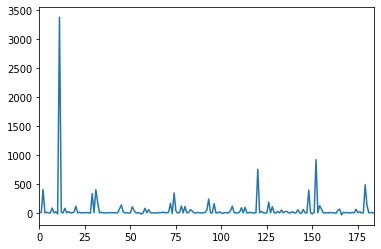

In [52]:
Other_Sentiment_df['Coverage'].plot()

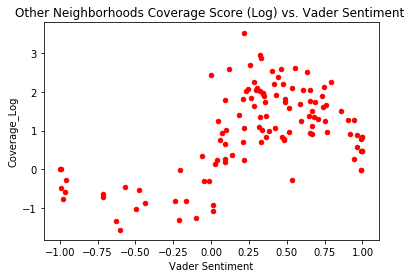

In [58]:
Other_Sentiment_df.plot(kind='scatter',x='Vader Sentiment',y='Coverage_Log',color='red', title='Other Neighborhoods Coverage Score (Log) vs. Vader Sentiment ')
plt.show()

In [59]:
print(Other_Sentiment_df['Coverage_Log'].mean())
#print(Other_Sentiment_df['Coverage_Log'].mode())
print(Other_Sentiment_df['Coverage_Log'].std())

0.9918032205142594
1.1027249059813429


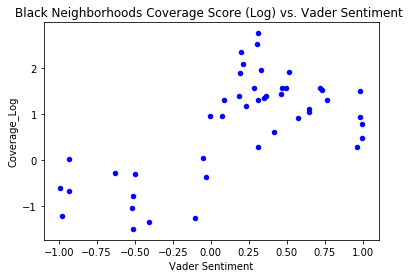

In [60]:
Sentiment_df.plot(kind='scatter',x='Vader Sentiment',y='Coverage_Log',color='blue', title='Black Neighborhoods Coverage Score (Log) vs. Vader Sentiment ')
plt.show()

In [61]:
print(Sentiment_df['Coverage_Log'].mean())
#print(Sentiment_df['Coverage_Log'].mode())
print(Sentiment_df['Coverage_Log'].std())

0.7660405023782336
1.1105937764144715


In [111]:
fig, ax = plt.subplots(figsize=(150, 150))
#ax = df_neigh.plot.bar(x='Name', rot=1000000)
#ax = df_neigh.plot.area(x="Name", y="Count", rot=10000000) 
# Add x-axis and y-axis
ax.bar(Sentiment_df['Name'],
        Sentiment_df['Count'],
        color='purple')

# Set title and labels for axes
ax.set(xlabel="Name",ylabel="Count",title="Neighborhood Coverage")

plt.show()

# White Neighborhoods

In [18]:
White_Census_Tracts = Neighborhoods_df[Neighborhoods_df["White Proportion"] >= 0.5]
White_Census_Tracts

Census Tract#       Zipcode             Neighborhood  \
0             1.00  02134, 02135                 Brighton   
1             2.01         02135                 Brighton   
2             2.02         02135                 Brighton   
3             3.01         02135                 Brighton   
4             3.02         02135                 Brighton   
..             ...           ...                      ...   
168        9803.00  02121, 02130                  Roxbury   
173        9812.02  02127, 02210  South Boston Waterfront   
174        9813.00         02128              East Boston   
179        9818.00  02130, 02215            Jamaica Plain   
180        9901.01         02130                      NaN   

    US Geonames Sub-neigborhood  Total Population   Black  Black Proportion  \
0                           NaN              5324     311          0.058415   
1                           NaN              3991     237          0.059384   
2                           NaN              4272     263          0.061564   
3                           NaN              2946     216          0.073320   
4                           NaN              3469     359          0.103488   
..                          ...               ...     ...               ...   
168                 Forest Hill               380      91          0.239474   
173  Fort Winthrop (historical)               215      27          0.125581   
174                         NaN               400      20          0.050000   
179                         NaN                26       9          0.346154   
180                         NaN                67      18          0.268657   

     White  White Proportion  American Indian & Alaska Native  ...  Male   \
0     3315          0.622652                                0  ...   2578   
1     3164          0.792784                               17  ...   1800   
2     3031          0.709504                                0  ...   2175   
3     2203          0.747794                                0  ...   1650   
4     2346          0.676276                               25  ...   1733   
..     ...               ...                              ...  ...    ...   
168    221          0.581579                               13  ...    295   
173    179          0.832558                                0  ...    206   
174    362          0.905000                                0  ...    284   
179     17          0.653846                                0  ...      4   
180     49          0.731343                                0  ...     55   

     Male Proportion  Female   Female Proportion         Lat       Long  \
0           0.484222     2746            0.515778  42.361485 -71.138588   
1           0.451015     2191            0.548985  42.354066 -71.161168   
2           0.509129     2097            0.490871  42.352605 -71.154344   
3           0.560081     1296            0.439919  42.354144 -71.168827   
4           0.499568     1736            0.500432  42.347258 -71.167686   
..               ...      ...                 ...        ...        ...   
168         0.776316       85            0.223684  42.300613 -71.094613   
173         0.958140        9            0.041860  42.343916 -71.024362   
174         0.710000      116            0.290000  42.361129 -71.006975   
179         0.153846       22            0.846154  42.323121 -71.116882   
180         0.820896       12            0.179104  42.329611 -70.949200   

     Primary Sub-Neighborhood  Secondary Sub-Neighborhood  \
0               Lower Allston                     Allston   
1                  Oak Square                    Brighton   
2                  Oak Square                    Brighton   
3               Hunnwell Hill                  Oak Square   
4                    Brighton             St. Elizabeth's   
..                        ...                         ...   
168                   Roxbury                  Dorchester   
173      

In [30]:
Neighborhoods_Sans_Black

Census Tract#       Zipcode   Neighborhood US Geonames Sub-neigborhood  \
0             1.00  02134, 02135       Brighton                         NaN   
1             2.01         02135       Brighton                         NaN   
2             2.02         02135       Brighton                         NaN   
3             3.01         02135       Brighton                         NaN   
4             3.02         02135       Brighton                         NaN   
..             ...           ...            ...                         ...   
176        9815.02         02151    East Boston                         NaN   
177        9816.00         02128    East Boston                         NaN   
178        9817.00         02116    Beacon Hill                         NaN   
179        9818.00  02130, 02215  Jamaica Plain                         NaN   
180        9901.01         02130            NaN                         NaN   

     Total Population   Black  Black Proportion  White  White Proportion  \
0                5324     311          0.058415   3315          0.622652   
1                3991     237          0.059384   3164          0.792784   
2                4272     263          0.061564   3031          0.709504   
3                2946     216          0.073320   2203          0.747794   
4                3469     359          0.103488   2346          0.676276   
..                ...     ...               ...    ...               ...   
176                 0       0          0.000000      0          0.000000   
177                 0       0          0.000000      0          0.000000   
178                 0       0          0.000000      0          0.000000   
179                26       9          0.346154     17          0.653846   
180                67      18          0.268657     49          0.731343   

     American Indian & Alaska Native  ...  Male   Male Proportion  Female   \
0                                  0  ...   2578         0.484222     2746   
1                                 17  ...   1800         0.451015     2191   
2                                  0  ...   2175         0.509129     2097   
3                                  0  ...   1650         0.560081     1296   
4                                 25  ...   1733         0.499568     1736   
..                               ...  ...    ...              ...      ...   
176                                0  ...      0         0.000000        0   
177                                0  ...      0         0.000000        0   
178                                0  ...      0         0.000000        0   
179                                0  ...      4         0.153846       22   
180                                0  ...     55         0.820896       12   

     Female Proportion         Lat       Long  Primary Sub-Neighborhood  \
0              0.515778  42.361485 -71.138588             Lower Allston   
1              0.548985  42.354066 -71.161168                Oak Square   
2              0.490871  42.352605 -71.154344                Oak Square   
3              0.439919  42.354144 -71.168827             Hunnwell Hill   
4              0.500432  42.347258 -71.167686                  Brighton   
..                  ...        ...        ...                       ...   
176            0.000000  42.396367 -71.004379                 Beachmont   
177            0.000000  42.388621 -70.993442            Orient Heights   
178            0.000000  42.355087 -71.065743         Downtown Crossing   
179            0.846154  42.323121 -71.116882          High Street Hill   
180            0.179104  42.329611 -70.949200                       NaN   

     Secondary Sub-Neighborhood  Teritriary Sub-Neighborhood(s)  \
0                       Allston                Packard's Corner   
1                      Brighton                  Hunnewell Hill   
2                      Brighton                         Allston   
3                    Oak Square      

In [82]:
White_Primary_Sub_Unique = White_Census_Tracts['Primary Sub-Neighborhood'].unique()
White_Secondary_Sub_Unique = White_Census_Tracts['Secondary Sub-Neighborhood'].unique()
White_Teritiary_Sub_Unique = White_Census_Tracts['Teritriary Sub-Neighborhood(s)'].unique()
White_Commuter_Unique = White_Census_Tracts['T-Stop/Commuter Rail'].unique()

print(White_Primary_Sub_Unique)
print(White_Secondary_Sub_Unique)
print(White_Teritiary_Sub_Unique)
print(White_Commuter_Unique)

['Lower Allston' 'Oak Square' 'Hunnwell Hill' 'Brighton' "St. Elizabeth's"
 'Chestnut Hill Neighborhood Association' 'Aberdeen'
 'Salisbury Road-Corey Farm' 'Allston' 'Back Bay' 'West Fens'
 'Fenway-Kenmore' 'Frederick Douglas Square Historic District'
 'Back Bay West / Back Bay' 'West End' 'Bunker Hill' 'Charlestown'
 'Boston' 'East Boston' nan 'Medford Street/The Neck' 'Eagle Hill'
 'Central Maverick Square/Paris Square' 'Orient Heights'
 'Harbor View/Orient Heights' 'Jeffries Point' 'City Point'
 'Telegraph Hill' 'Seaport District' 'South Boston'
 'Columbus Park/Andrew Square' 'D Street / West Broadway'
 'Downtown Crossing' 'Shawmut' 'Columbus' 'South End' 'Mission Hill'
 'Jones Hill' "Upham's Corner" 'Neponset/Port Norfolk' 'Adams Village'
 'Ashmount' 'Forest Hills/Woodbourne' 'Roslindale '
 'Metropolitan Hill/Beech Street' 'Roslindale' 'Centre South'
 'Jamaica Hills' 'Jamaica Plain' 'Stonybrook' 'Roxbury ' 'Egleston Square'
 'High Street Hill' 'Brook Farm' 'Bellevue Hill'
 'Upper 

In [83]:
White_Names_List = []
for primary in White_Primary_Sub_Unique:
    White_Names_List.append(primary)
   
for secondary in White_Secondary_Sub_Unique:
    White_Names_List.append(secondary)
    
for teritiary in White_Teritiary_Sub_Unique:
    White_Names_List.append(teritiary)
    
for stops in White_Commuter_Unique:
    White_Names_List.append(stops)

print(White_Names_List)   

['Lower Allston', 'Oak Square', 'Hunnwell Hill', 'Brighton', "St. Elizabeth's", 'Chestnut Hill Neighborhood Association', 'Aberdeen', 'Salisbury Road-Corey Farm', 'Allston', 'Back Bay', 'West Fens', 'Fenway-Kenmore', 'Frederick Douglas Square Historic District', 'Back Bay West / Back Bay', 'West End', 'Bunker Hill', 'Charlestown', 'Boston', 'East Boston', nan, 'Medford Street/The Neck', 'Eagle Hill', 'Central Maverick Square/Paris Square', 'Orient Heights', 'Harbor View/Orient Heights', 'Jeffries Point', 'City Point', 'Telegraph Hill', 'Seaport District', 'South Boston', 'Columbus Park/Andrew Square', 'D Street / West Broadway', 'Downtown Crossing', 'Shawmut', 'Columbus', 'South End', 'Mission Hill', 'Jones Hill', "Upham's Corner", 'Neponset/Port Norfolk', 'Adams Village', 'Ashmount', 'Forest Hills/Woodbourne', 'Roslindale ', 'Metropolitan Hill/Beech Street', 'Roslindale', 'Centre South', 'Jamaica Hills', 'Jamaica Plain', 'Stonybrook', 'Roxbury ', 'Egleston Square', 'High Street Hill',

In [84]:
White_Names_List = list(dict.fromkeys(White_Names_List))
print(White_Names_List)

['Lower Allston', 'Oak Square', 'Hunnwell Hill', 'Brighton', "St. Elizabeth's", 'Chestnut Hill Neighborhood Association', 'Aberdeen', 'Salisbury Road-Corey Farm', 'Allston', 'Back Bay', 'West Fens', 'Fenway-Kenmore', 'Frederick Douglas Square Historic District', 'Back Bay West / Back Bay', 'West End', 'Bunker Hill', 'Charlestown', 'Boston', 'East Boston', nan, 'Medford Street/The Neck', 'Eagle Hill', 'Central Maverick Square/Paris Square', 'Orient Heights', 'Harbor View/Orient Heights', 'Jeffries Point', 'City Point', 'Telegraph Hill', 'Seaport District', 'South Boston', 'Columbus Park/Andrew Square', 'D Street / West Broadway', 'Downtown Crossing', 'Shawmut', 'Columbus', 'South End', 'Mission Hill', 'Jones Hill', "Upham's Corner", 'Neponset/Port Norfolk', 'Adams Village', 'Ashmount', 'Forest Hills/Woodbourne', 'Roslindale ', 'Metropolitan Hill/Beech Street', 'Roslindale', 'Centre South', 'Jamaica Hills', 'Jamaica Plain', 'Stonybrook', 'Roxbury ', 'Egleston Square', 'High Street Hill',

In [85]:
Primary_sub_White_slash = []
Primary_sub_White_split =[]

for sub in White_Names_List:
    str_sub = str(sub)
    if str_sub != "nan":
        Primary_sub_White_slash.extend(str_sub.split("/"))
        
for sub in Primary_sub_White_slash:    
    Primary_sub_White_split.extend(sub.split("@"))
    
print(Primary_sub_White_split)

['Lower Allston', 'Oak Square', 'Hunnwell Hill', 'Brighton', "St. Elizabeth's", 'Chestnut Hill Neighborhood Association', 'Aberdeen', 'Salisbury Road-Corey Farm', 'Allston', 'Back Bay', 'West Fens', 'Fenway-Kenmore', 'Frederick Douglas Square Historic District', 'Back Bay West ', ' Back Bay', 'West End', 'Bunker Hill', 'Charlestown', 'Boston', 'East Boston', 'Medford Street', 'The Neck', 'Eagle Hill', 'Central Maverick Square', 'Paris Square', 'Orient Heights', 'Harbor View', 'Orient Heights', 'Jeffries Point', 'City Point', 'Telegraph Hill', 'Seaport District', 'South Boston', 'Columbus Park', 'Andrew Square', 'D Street ', ' West Broadway', 'Downtown Crossing', 'Shawmut', 'Columbus', 'South End', 'Mission Hill', 'Jones Hill', "Upham's Corner", 'Neponset', 'Port Norfolk', 'Adams Village', 'Ashmount', 'Forest Hills', 'Woodbourne', 'Roslindale ', 'Metropolitan Hill', 'Beech Street', 'Roslindale', 'Centre South', 'Jamaica Hills', 'Jamaica Plain', 'Stonybrook', 'Roxbury ', 'Egleston Square

In [87]:
s1 = set(Primary_sub_Black_split)
s2 = set(Primary_sub_White_split)
White_Names_Only = s2 - s1
White_Names_Only

{'',
 ' 88 E Newton St ',
 ' Back Bay',
 ' Back of the Hill',
 ' Broadway',
 ' Columbus Ave',
 ' E St',
 ' Fenway',
 ' Forest Hills',
 ' Goud',
 ' Havre St',
 ' Hynes Convention Center',
 ' Jersey St',
 ' Mercer St',
 ' P St',
 ' Prudential',
 ' Reservoir',
 ' River Street',
 ' The Neck',
 ' West Broadway',
 ' Wren',
 '8th St',
 '91 E Concord St ',
 'Aberdeen',
 'Adams Village',
 'Admirals Hill',
 'Airport',
 'Allston',
 'Allston Street',
 'Andrew Square',
 'Arlington',
 'Ashcroft',
 'Ashmont',
 'Ashmount',
 'Assembly Square',
 'BU Central',
 'Babcock Street',
 'Back Bay',
 'Back Bay West ',
 'Bay Village',
 'Bellevue',
 'Bellevue Hill',
 'Berkley St ',
 'Blanchard Street',
 'Boston',
 'Boston Landing',
 'Boston St and Dorset St ',
 'Bowdoin',
 'Brigham Circle',
 'Brighton',
 'Broadway',
 'Brook Farm',
 'Brookline',
 'Bunker Hill',
 'Cambridgeport',
 'Cedar Grove',
 'Central Maverick Square',
 'Central Square',
 'Central Village',
 'Centre South',
 'Charles',
 'Charlestown',
 'Chelsea'

In [88]:
White_Names_List = list(White_Names_Only)
for names in White_Names_List:
    for reverse in White_Names_List[::-1]:
        if distance(names, reverse) == 1:
            White_Names_List.remove(reverse)

print(White_Names_List)

['', 'Downtown Crossing', ' Jersey St', ' Back of the Hill', 'Wood Island', 'Copley ', 'Washington', 'Aberdeen', 'Meridan St ', 'Spring Street ', 'Bay Village', 'Cleveland Circle', 'Hyde Park', 'Heath Street ', 'Central Maverick Square', 'E 8th St ', 'West Fens', 'Kenmore', 'East Boston', 'Allston Street', 'Chestnut Hill Ave', 'Blanchard Street', 'Fort Point', 'Roxbury ', 'W 6th St ', 'Chiswick Road', 'Adams Village', ' P St', 'Fairmount', 'Seaport District', 'Longwood', 'Hynes Convention Center Station', 'D Street ', 'Cambridgeport', ' Reservoir', 'Queensbury St ', 'Back Bay West ', 'UMass', 'Central Square', 'JFK', 'Central Village', 'East Cambridge', 'Hunnewell Hill', 'Harrison Ave opp. Plympton Street ', ' River Street', 'Bunker Hill', 'Egleston Square', 'Lower Roxbury ', 'Suffolk Downs', 'Hyde Park  ', 'Brook Farm', 'Charlestown', 'Boston St and Dorset St ', 'Massachusetts Ave', 'Warren Street', 'South End', 'Winthrop', 'Readville', 'Maverick', 'Cedar Grove', 'Columbus', 'Hyde Par

In [90]:
Major_Neighborhoods = ['Allston', 'Beacon Hill', 'Chinatown', 'Financial District', 'Leather District', 'Mission Hill',
                      'Roxbury', 'Fenway', 'West Roxbury', 'Back Bay', 'Brighton', 'Dorchester','Hyde Park',
                      'Mattapan','North End','Seaport','Waterfront','Bay Village','Charlestown',
                      'East Boston','Jamaica Plain','Midtown','Roslindale','South End','West End']

White_Major = []
for names in White_Names_List:
    if names in Major_Neighborhoods:
        White_Major.append(names)
        White_Names_List.remove(names)
        
print('White Sub-Neighborhoods', White_Names_List)
print('---------------------------')
print('White Major Neighborhoods', White_Major)

White Sub-Neighborhoods ['', 'Downtown Crossing', ' Jersey St', ' Back of the Hill', 'Wood Island', 'Copley ', 'Washington', 'Aberdeen', 'Meridan St ', 'Spring Street ', 'Cleveland Circle', 'Heath Street ', 'Central Maverick Square', 'E 8th St ', 'West Fens', 'Kenmore', 'Allston Street', 'Chestnut Hill Ave', 'Blanchard Street', 'Fort Point', 'Roxbury ', 'W 6th St ', 'Chiswick Road', 'Adams Village', ' P St', 'Fairmount', 'Seaport District', 'Longwood', 'Hynes Convention Center Station', 'D Street ', 'Cambridgeport', ' Reservoir', 'Queensbury St ', 'Back Bay West ', 'UMass', 'Central Square', 'JFK', 'Central Village', 'East Cambridge', 'Hunnewell Hill', 'Harrison Ave opp. Plympton Street ', ' River Street', 'Bunker Hill', 'Egleston Square', 'Lower Roxbury ', 'Suffolk Downs', 'Hyde Park  ', 'Brook Farm', 'Boston St and Dorset St ', 'Massachusetts Ave', 'Warren Street', 'Winthrop', 'Readville', 'Maverick', 'Cedar Grove', 'Columbus', 'Hyde Park Ave opp Walk Hill St ', ' Havre St', ' 88 E N

In [15]:
Check3 = ['Downtown Crossing', ' Jersey St', ' Back of the Hill', 'Wood Island', 'Copley ', 'Washington', 'Aberdeen', 'Meridan St ', 'Spring Street ', 'Cleveland Circle', 'Heath Street ', 'Central Maverick Square', 'E 8th St ', 'West Fens', 'Kenmore', 'Allston Street', 'Chestnut Hill Ave', 'Blanchard Street', 'Fort Point', 'Roxbury ', 'W 6th St ', 'Chiswick Road', 'Adams Village', ' P St', 'Fairmount', 'Seaport District', 'Longwood', 'Hynes Convention Center Station', 'D Street ', 'Cambridgeport', ' Reservoir', 'Queensbury St ', 'Back Bay West ', 'UMass', 'Central Square', 'JFK', 'Central Village', 'East Cambridge', 'Hunnewell Hill', 'Harrison Ave opp. Plympton Street ', ' River Street', 'Bunker Hill', 'Egleston Square', 'Lower Roxbury ', 'Suffolk Downs', 'Hyde Park  ', 'Brook Farm', 'Boston St and Dorset St ', 'Massachusetts Ave', 'Warren Street', 'Winthrop', 'Readville', 'Maverick', 'Cedar Grove', 'Columbus', 'Hyde Park Ave opp Walk Hill St ', ' Havre St', ' 88 E Newton St ', "Packard's Corner", 'Forest Hills Woodbourne', 'Paris Square', 'Arlington', 'Northeastern University', 'Fisher Hill', 'Fairmount Hill', 'South Boston', 'Jerffries Point', 'Medford Street', 'E Broad St ', "Upham's Corner", 'Roxbury Crossing', 'City Point', 'Green Street', 'Port Norfolk', 'Eagle Hill', 'Shawmut', 'Chelsea', 'Highland', ' Fenway', 'Lower Alston', 'Andrew Square', 'Sullivan Square', 'Oak Square', 'Jamaica Hills', 'Telegraph Hill', 'Ashmount', 'Woodard Rd ', ' The Neck', 'South Brookline', ' West Broadway', 'opp Harvest St', 'Community College', 'Marina Bay', ' Columbus Ave', 'Admirals Hill', 'South End  ', 'Oak Hill Park', 'Brookline', 'Boston', '8th St', 'South Street', 'Sutherland Road', 'Chestnut Hill Neighborhood Association', 'Columbus Park', ' Hynes Convention Center', 'Orient Heights ', 'Neponset', 'Inner Belt', 'Medical Center Area', 'Stonybrook', 'Chestnut Hill Avenue', 'South End of Washington', 'Paris Street', 'Cottage Farm Historic District', 'Bellevue', 'Washington Street', 'Assembly Square', 'High Street Hill', 'Roslindale Village', 'North Station', 'Berkley St ', 'South Station', 'Upper Washington', 'Savin Hill', 'Bowdoin', 'Longwood Medical Area ', 'China Town', 'Babcock Street', 'Charles', 'Corey Hill', 'Jackson Square', 'Salisbury Road-Corey Farm', 'Bellevue Hill', 'Orient Heights         ', ' Broadway', 'Stony Brook', 'South Point', 'BU Central', 'Haymarket', ' Prudential', ' Mercer St', 'Ashcroft', 'Brigham Circle', ' Forest Hills', 'Boston Landing', 'West Street ', ' Goud', 'Centre South', 'Fenwood Rd', 'Lower Washington', 'Airport', 'Harbor View', 'Lansdowne ', 'Fenway-Kenmore', 'MGH', '91 E Concord St ', 'Opp 43 W Dedham St', ' Wren', "St. Elizabeth's"]
print(len(Check3))



159


In [16]:
Unique_White_Neighborhoods = Neighborhoods_df['Neighborhood'].unique()
#Unique_White_Neighborhoods = ['Brighton', 'Allston', 'Fenway', 'Longwood Medical Area',
       #'Back Bay', 'Beacon Hill', 'West End', 'North End', 'Downtown',
       #'Charlestown', 'East Boston', 'South Boston',
       #'South Boston Waterfront', 'South End', 'Mission Hill',
       #'Dorchester', 'Jamaica Plain', 'Roslindale', 'West Roxbury',
       #'Hyde Park', 'Roxbury']

In [19]:
White_Neighborhood_Census = pd.DataFrame(columns=['Neighborhood', 'White Population', 'White Percentage'])
WNeigh_list = []
WPop_List = []
WPercent_List = []

for neighborhood in Unique_White_Neighborhoods:
    White_Neighborhood = Neighborhoods_df[Neighborhoods_df['Neighborhood'] == neighborhood]
    White_Pop = White_Neighborhood['White'].sum()
    Proportion_Mean = White_Neighborhood['White Proportion'].mean()
    WNeigh_list.append(neighborhood)
    WPop_List.append(White_Pop)
    WPercent_List.append(Proportion_Mean*100)
    
#print(neighborhood, White_Pop, Proportion_Mean*100)
WNeighSe = pd.Series(WNeigh_list)
WPopSe = pd.Series(WPop_List)
WPercentSe = pd.Series(WPercent_List)

White_Neighborhood_Census['Neighborhood'] = WNeighSe.values
White_Neighborhood_Census['White Population'] = WPopSe.values
White_Neighborhood_Census['White Percentage'] = WPercentSe.values

White_Neighborhood_Census[['Neighborhood','White Population','White Percentage']]

White_Neighborhood_Census.sort_values(by='White Percentage', ascending=False)

Neighborhood  White Population  White Percentage
7                 North End              8846         94.707871
12  South Boston Waterfront              3295         84.654695
9               Charlestown             17691         80.611435
3     Longwood Medical Area              4289         77.981818
20             West Roxbury             26081         77.610699
6                  West End              4716         74.690182
10              East Boston             40618         74.571890
0                  Brighton             40420         73.975175
11             South Boston             30089         72.713322
4                  Back Bay             14787         71.500373
2                    Fenway             22945         68.979469
5               Beacon Hill              8636         68.458973
16            Jamaica Plain             27590         64.283970
13                South End             21025         64.197412
1                   Allston             12203         61.030520
8                  Downtown             11009         60.285556
19               Roslindale             18823         59.010459
15             Mission Hill              8741         52.491708
22           Harbor Islands               193         47.654321
21                Hyde Park             14461         37.657928
17               Dorchester             37843         30.799425
14                  Roxbury             11446         23.082497
18                 Mattapan              3254         15.939229
23                      NaN                 0               NaN

In [46]:
print(Name_Search(Check3)['Count'].sum())

38578


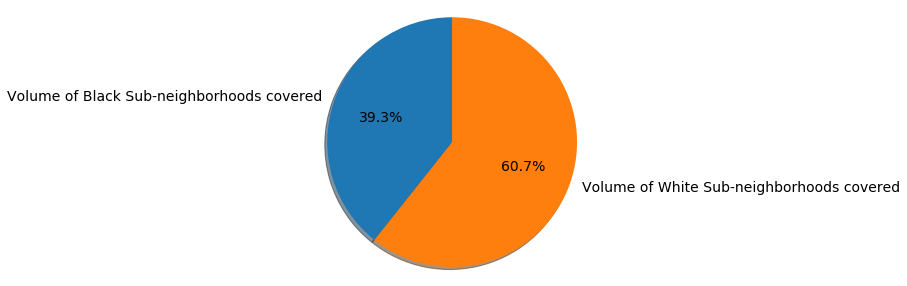

In [51]:

labels = 'Volume of Black Sub-neighborhoods covered', 'Volume of White Sub-neighborhoods covered'

# 24,992 out of 51,716
sizes = [24992, 38578]

fig1, ax1 = plt.subplots()
fig1.set_size_inches(5,5)
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
                shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
mpl.rcParams['font.size'] = 14.0
plt.show()

# Major Neighborhoods

In [63]:
# Black major neighborhoods
print('Black major neighborhoods: ', Black_Major)

# Non-black major neighborhoods
print('Other major neighborhoods: ', Other_Major)

Black major neighborhoods:  ['Roxbury', 'Dorchester', 'Mattapan', 'Hyde Park', 'Roslindale']
Other major neighborhoods:  ['Bay Village', 'East Boston', 'Charlestown', 'South End', 'Waterfront', 'Jamaica Plain', 'Back Bay', 'Brighton', 'Mission Hill', 'West End']


In [64]:
Other_Major_Sentiment_df = pd.read_csv('Other_Major_Neighborhoods_Coverage.csv')
Other_Major_Sentiment_df

Name  Count  Vader Sentiment
0    Bay Village     65         0.390646
1    East Boston    984         0.435111
2    Charlestown    693         0.523179
3      South End   1383         0.271491
4     Waterfront    128         0.790833
5  Jamaica Plain   1334         0.389403
6       Back Bay    826         0.419734
7       Brighton    768         0.493810
8   Mission Hill    495         0.173577
9       West End    127         0.679801

In [65]:
Black_Major_Sentiment_df = pd.read_csv('Black_Major_Neighborhoods_Coverage.csv')
Black_Major_Sentiment_df

Name  Count  Vader Sentiment
0     Roxbury   5326         0.174044
1  Dorchester   7868         0.124923
2    Mattapan   1976         0.105360
3   Hyde Park   1302         0.233559
4  Roslindale   1196         0.205509

In [73]:
import math
Major_Coverage_List_Black = []
for count, sent in zip(Black_Major_Sentiment_df['Count'],Black_Major_Sentiment_df['Vader Sentiment']):
    coverage = count*sent
    Major_Coverage_List_Black.append(coverage)


Major_BlackSe = pd.Series(Major_Coverage_List_Black)
Black_Major_Sentiment_df['Coverage'] = Major_BlackSe.values


Black_Major_Sentiment_df = Black_Major_Sentiment_df[Black_Major_Sentiment_df['Vader Sentiment'] != 0] 

Major_Log_scores = []
for coverage in Black_Major_Sentiment_df['Coverage']:
    if coverage < 0:
        Abs_value = coverage * (-1)
        Major_Log_scores.append(math.log10(Abs_value) * (-1))
    else:
        Major_Log_scores.append(math.log10(coverage))

Major_LogSe = pd.Series(Major_Log_scores)
Black_Major_Sentiment_df['Coverage_Log'] = Major_LogSe.values
        
        
        
#Sentiment_df['Coverage_Log'] = np.log10(Sentiment_df['Coverage'])

Black_Major_Sentiment_df

Name  Count  Vader Sentiment  Coverage  Coverage_Log
0     Roxbury   5326         0.174044  926.9602      2.967061
1  Dorchester   7868         0.124923  982.8926      2.992506
2    Mattapan   1976         0.105360  208.1916      2.318463
3   Hyde Park   1302         0.233559  304.0932      2.483007
4  Roslindale   1196         0.205509  245.7890      2.390562

In [74]:
Other_Major_List = []
for count, sent in zip(Other_Major_Sentiment_df['Count'],Other_Major_Sentiment_df['Vader Sentiment']):
    coverage = count*sent
    Other_Major_List.append(coverage)
    
OtherMajorSe = pd.Series(Other_Major_List)
Other_Major_Sentiment_df['Coverage'] = OtherMajorSe.values

Other_Major_Sentiment_df = Other_Major_Sentiment_df[Other_Major_Sentiment_df['Vader Sentiment'] != 0] 

Other_Major_Log_scores = []
for coverage in Other_Major_Sentiment_df['Coverage']:
    if coverage < 0:
        Abs_value = coverage * (-1)
        Other_Major_Log_scores.append(math.log10(Abs_value) * (-1))
    else:
        Other_Major_Log_scores.append(math.log10(coverage))

OtherMajorLogSe = pd.Series(Other_Major_Log_scores)
Other_Major_Sentiment_df['Coverage_Log'] = OtherMajorLogSe.values


#Other_Sentiment_df['Coverage_Log'] = np.log(Other_Sentiment_df['Coverage'])
Other_Major_Sentiment_df

Name  Count  Vader Sentiment  Coverage  Coverage_Log
0    Bay Village     65         0.390646   25.3920      1.404697
1    East Boston    984         0.435111  428.1488      2.631595
2    Charlestown    693         0.523179  362.5629      2.559383
3      South End   1383         0.271491  375.4718      2.574577
4     Waterfront    128         0.790833  101.2266      2.005295
5  Jamaica Plain   1334         0.389403  519.4641      2.715556
6       Back Bay    826         0.419734  346.7004      2.539954
7       Brighton    768         0.493810  379.2464      2.578921
8   Mission Hill    495         0.173577   85.9207      1.934098
9       West End    127         0.679801   86.3347      1.936185

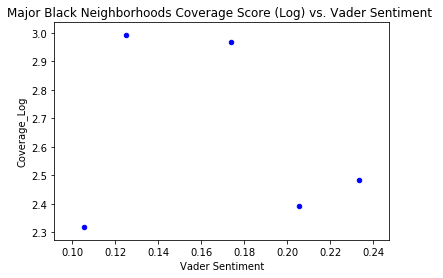

In [75]:
Black_Major_Sentiment_df.plot(kind='scatter',x='Vader Sentiment',y='Coverage_Log',color='blue', title='Major Black Neighborhoods Coverage Score (Log) vs. Vader Sentiment ')
plt.show()

In [77]:
print(Black_Major_Sentiment_df['Coverage_Log'].mean())
#print(Other_Sentiment_df['Coverage_Log'].mode())
print(Black_Major_Sentiment_df['Coverage_Log'].std())

2.630319901453663
0.32442751890000504


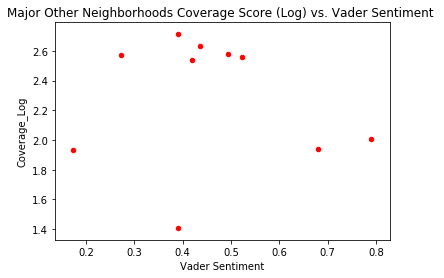

In [76]:
Other_Major_Sentiment_df.plot(kind='scatter',x='Vader Sentiment',y='Coverage_Log',color='red', title='Major Other Neighborhoods Coverage Score (Log) vs. Vader Sentiment ')
plt.show()

In [78]:
print(Other_Major_Sentiment_df['Coverage_Log'].mean())
#print(Other_Sentiment_df['Coverage_Log'].mode())
print(Other_Major_Sentiment_df['Coverage_Log'].std())

2.288026151661287
0.43638920005809667


In [40]:
Black_Neighborhoods_df = pd.read_excel('Black_Neighborhoods_Coverage.xlsx')
Black_Neighborhoods_df

Name  Count  Vader Sentiment  TextBlob Sentiment  \
0                Lower Roxbury     27         0.761278            0.113889   
1              Washington Park     45         0.729509            0.073123   
2                   Grove Hall    269         0.332162            0.095239   
3         Franklin Field South      2         0.961300            0.054459   
4                       Dudley   1096         0.303780            0.082397   
5                   Jones Hill      9         0.979200            0.130282   
6           Meeting House Hill     12        -0.510575            0.118055   
7                Codman Square     65         0.312495            0.096241   
8                  Milton Hill      3         0.997500            0.177228   
9              Wellington Hill      5        -0.931880            0.075598   
10                  Washington   1861         0.311263            0.084569   
11                  Mount Hope     17         0.647206            0.131835   
12                Beech Street      4        -0.496075            0.084158   
13                 West Street     69        -0.001588            0.058772   
14                River Street    176        -0.100574            0.041340   
15                Forest Hills    137         0.183575            0.072637   
16               Columbus Park     51         0.718696            0.108226   
17               Andrew Square     68         0.360693            0.070768   
18                   Fort Hill     57         0.464449            0.062980   
19               Mount Bowdoin      4        -0.990625            0.041385   
20           Dorchester Center      6         0.313333            0.110907   
21                West Roxbury   1131         0.197717            0.073956   
22                Dearborn St.      3        -0.626833            0.102238   
23                     Ruggles     78        -0.030110            0.087383   
24              Jackson Square     72         0.495871            0.060334   
25                 Rockland St     10         0.414930            0.111652   
26                    Woodbine      6         0.997333            0.166230   
27                   Gaston St      1        -0.932500           -0.033333   
28                Ellington St     17        -0.978882           -0.027967   
29  Jeremiah Burke High School     17        -0.052935            0.058489   
30                      Geneva    413         0.191335            0.092459   
31               Uphams Corner     64         0.349627            0.078427   
32                   Newmarket     79         0.468386            0.091437   
33                Four Corners     63         0.234825            0.102407   
34               Fields Corner    129         0.285684            0.092418   
35                     Shawmut    123         0.072615            0.066895   
36                  Talbot Ave     55        -0.407275            0.044136   
37               Morton Street     63        -0.508089            0.032808   
38                     Ashmont    233         0.087148            0.064652   
39              Peabody Square     20         0.644035            0.094969   
40                 Central Ave     14         0.575086            0.088296   
41                      Milton    573         0.212844            0.083771   
42                      Butler    159         0.517960            0.099344   
43     American Legion Highway     21        -0.519343            0.025522   
44                      Stella     32         0.982050            0.117788   

    TB_Coverage  TB_Coverage_Log  Coverage  Coverage_Log  Vader_Coverage  \
0      3.075012         0.487847   20.5545      1.312907         20.5545   
1      3.290545         0.517268   32.8279      1.516243         32.8279   
2     25.619326         1.408568   89.3516      1.951102         89.3516   
3      0.108918        -0.962901    1.9226      0.283889          1.9226   
4     90.306600         1.955719  332.9434      2.522370 

In [9]:
import math
TB_Coverage_List_Black = []
for count, sent in zip(Black_Neighborhoods_df['Count'],Black_Neighborhoods_df['TextBlob Sentiment']):
    coverage = count*sent
    TB_Coverage_List_Black.append(coverage)


BlackSe = pd.Series(TB_Coverage_List_Black)
Black_Neighborhoods_df['TB_Coverage'] = BlackSe.values


Black_Neighborhoods_df = Black_Neighborhoods_df[Black_Neighborhoods_df['TextBlob Sentiment'] != 0] 

Black_Log_scores = []
for coverage in Black_Neighborhoods_df['TB_Coverage']:
    if coverage < 0:
        Abs_value = coverage * (-1)
        Black_Log_scores.append(math.log10(Abs_value) * (-1))
    else:
        Black_Log_scores.append(math.log10(coverage))

Black_LogSe = pd.Series(Black_Log_scores)
Black_Neighborhoods_df['TB_Coverage_Log'] = Black_LogSe.values
        
        
        
#Sentiment_df['Coverage_Log'] = np.log10(Sentiment_df['Coverage'])
Black_Neighborhoods_df

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Name  Count  Vader Sentiment  TextBlob Sentiment  \
0                  Lower Roxbury     27         0.761278            0.113889   
2                Washington Park     45         0.729509            0.073123   
3                     Grove Hall    269         0.332162            0.095239   
4           Franklin Field South      2         0.961300            0.054459   
6                         Dudley   1096         0.303780            0.082397   
8                     Jones Hill      9         0.979200            0.130282   
9             Meeting House Hill     12        -0.510575            0.118055   
12                 Codman Square     65         0.312495            0.096241   
13                   Milton Hill      3         0.997500            0.177228   
15               Wellington Hill      5        -0.931880            0.075598   
17                   Washington    1861         0.311263            0.084569   
18                    Mount Hope     17         0.647206            0.131835   
20                  Beech Street      4        -0.496075            0.084158   
21                   West Street     69        -0.001588            0.058772   
22                  River Street    176        -0.100574            0.041340   
23                  Forest Hills    137         0.183575            0.072637   
25                Columbus Park      51         0.718696            0.108226   
26                 Andrew Square     68         0.360693            0.070768   
28                     Fort Hill     57         0.464449            0.062980   
30                 Mount Bowdoin      4        -0.990625            0.041385   
35             Dorchester Center      6         0.313333            0.110907   
36                  West Roxbury   1131         0.197717            0.073956   
41                  Dearborn St.      3        -0.626833            0.102238   
42                       Ruggles     78        -0.030110            0.087383   
45                Jackson Square     72         0.495871            0.060334   
48                   Walnut Ave       1         0.000000            0.500000   
49                   Rockland St     10         0.414930            0.111652   
51                     Woodbine       6         0.997333            0.166230   
53                     Gaston St      1        -0.932500           -0.033333   
55                  Ellington St     17        -0.978882           -0.027967   
57   Jeremiah Burke High School      17        -0.052935            0.058489   
58                        Geneva    413         0.191335            0.092459   
59                Uphams Corner      64         0.349627            0.078427   
60                     Newmarket     79         0.468386            0.091437   
63                  Four Corners     63         0.234825            0.102407   
64                 Fields Corner    129         0.285684            0.092418   
65                       Shawmut    123         0.072615            0.066895   
66                    Talbot Ave     55        -0.407275            0.044136   
67                 Morton Street     63        -0.508089            0.032808   
68                      Ashmont     233         0.087148            0.064652   
69                Peabody Square     20         0.644035            0.094969   
70                   Central Ave     14         0.575086            0.088296   
71                        Milton    573         0.212844            0.083771   
72                        Butler    159         0.517960            0.099344   
74      American Legion Highway      21        -0.519343            0.025522   
75                        Stella     32         0.982050            0.117788   

    TB_Coverage  TB_Coverage_Log  
0      3.075012         0.487847  
2      3.290545         0.517268  
3     25.619326         1.408568  
4      0.108918        -0.962901  
6     90.306600         1.955719  
8      1.172541         0.069128  
9      1.416666       

In [11]:
import math
Coverage_List_Black = []
for count, sent in zip(Black_Neighborhoods_df['Count'],Black_Neighborhoods_df['Vader Sentiment']):
    coverage = count*sent
    Coverage_List_Black.append(coverage)
    
BlackSe = pd.Series(Coverage_List_Black)
Black_Neighborhoods_df['Vader_Coverage'] = BlackSe.values


Black_Neighborhoods_df = Black_Neighborhoods_df[Black_Neighborhoods_df['Vader Sentiment'] != 0] 

Log_scores = []
for coverage in Black_Neighborhoods_df['Vader_Coverage']:
    if coverage < 0:
        Abs_value = coverage * (-1)
        Log_scores.append(math.log10(Abs_value) * (-1))
    else:
        Log_scores.append(math.log10(coverage))

LogSe = pd.Series(Log_scores)
Black_Neighborhoods_df['Vader_Coverage_Log'] = LogSe.values
        
        
        
#Sentiment_df['Coverage_Log'] = np.log10(Sentiment_df['Coverage'])

Black_Neighborhoods_df

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Name  Count  Vader Sentiment  TextBlob Sentiment  \
0                  Lower Roxbury     27         0.761278            0.113889   
2                Washington Park     45         0.729509            0.073123   
3                     Grove Hall    269         0.332162            0.095239   
4           Franklin Field South      2         0.961300            0.054459   
6                         Dudley   1096         0.303780            0.082397   
8                     Jones Hill      9         0.979200            0.130282   
9             Meeting House Hill     12        -0.510575            0.118055   
12                 Codman Square     65         0.312495            0.096241   
13                   Milton Hill      3         0.997500            0.177228   
15               Wellington Hill      5        -0.931880            0.075598   
17                   Washington    1861         0.311263            0.084569   
18                    Mount Hope     17         0.647206            0.131835   
20                  Beech Street      4        -0.496075            0.084158   
21                   West Street     69        -0.001588            0.058772   
22                  River Street    176        -0.100574            0.041340   
23                  Forest Hills    137         0.183575            0.072637   
25                Columbus Park      51         0.718696            0.108226   
26                 Andrew Square     68         0.360693            0.070768   
28                     Fort Hill     57         0.464449            0.062980   
30                 Mount Bowdoin      4        -0.990625            0.041385   
35             Dorchester Center      6         0.313333            0.110907   
36                  West Roxbury   1131         0.197717            0.073956   
41                  Dearborn St.      3        -0.626833            0.102238   
42                       Ruggles     78        -0.030110            0.087383   
45                Jackson Square     72         0.495871            0.060334   
49                   Rockland St     10         0.414930            0.111652   
51                     Woodbine       6         0.997333            0.166230   
53                     Gaston St      1        -0.932500           -0.033333   
55                  Ellington St     17        -0.978882           -0.027967   
57   Jeremiah Burke High School      17        -0.052935            0.058489   
58                        Geneva    413         0.191335            0.092459   
59                Uphams Corner      64         0.349627            0.078427   
60                     Newmarket     79         0.468386            0.091437   
63                  Four Corners     63         0.234825            0.102407   
64                 Fields Corner    129         0.285684            0.092418   
65                       Shawmut    123         0.072615            0.066895   
66                    Talbot Ave     55        -0.407275            0.044136   
67                 Morton Street     63        -0.508089            0.032808   
68                      Ashmont     233         0.087148            0.064652   
69                Peabody Square     20         0.644035            0.094969   
70                   Central Ave     14         0.575086            0.088296   
71                        Milton    573         0.212844            0.083771   
72                        Butler    159         0.517960            0.099344   
74      American Legion Highway      21        -0.519343            0.025522   
75                        Stella     32         0.982050            0.117788   

    TB_Coverage  TB_Coverage_Log  Coverage  Coverage_Log  Vader_Coverage  \
0      3.075012         0.487847   20.5545      1.312907         20.5545   
2      3.290545         0.517268   32.8279      1.516243         32.8279   
3     25.619326         1.408568   89.3516      1.951102         89.3516   
4      0.108918        -0.962901    1.9226 

In [12]:
Black_Neighborhoods_df.drop('Coverage', axis=1, inplace=True)
Black_Neighborhoods_df.drop('Coverage_Log', axis=1, inplace=True)
Black_Neighborhoods_df

Name  Count  Vader Sentiment  TextBlob Sentiment  \
0                  Lower Roxbury     27         0.761278            0.113889   
2                Washington Park     45         0.729509            0.073123   
3                     Grove Hall    269         0.332162            0.095239   
4           Franklin Field South      2         0.961300            0.054459   
6                         Dudley   1096         0.303780            0.082397   
8                     Jones Hill      9         0.979200            0.130282   
9             Meeting House Hill     12        -0.510575            0.118055   
12                 Codman Square     65         0.312495            0.096241   
13                   Milton Hill      3         0.997500            0.177228   
15               Wellington Hill      5        -0.931880            0.075598   
17                   Washington    1861         0.311263            0.084569   
18                    Mount Hope     17         0.647206            0.131835   
20                  Beech Street      4        -0.496075            0.084158   
21                   West Street     69        -0.001588            0.058772   
22                  River Street    176        -0.100574            0.041340   
23                  Forest Hills    137         0.183575            0.072637   
25                Columbus Park      51         0.718696            0.108226   
26                 Andrew Square     68         0.360693            0.070768   
28                     Fort Hill     57         0.464449            0.062980   
30                 Mount Bowdoin      4        -0.990625            0.041385   
35             Dorchester Center      6         0.313333            0.110907   
36                  West Roxbury   1131         0.197717            0.073956   
41                  Dearborn St.      3        -0.626833            0.102238   
42                       Ruggles     78        -0.030110            0.087383   
45                Jackson Square     72         0.495871            0.060334   
49                   Rockland St     10         0.414930            0.111652   
51                     Woodbine       6         0.997333            0.166230   
53                     Gaston St      1        -0.932500           -0.033333   
55                  Ellington St     17        -0.978882           -0.027967   
57   Jeremiah Burke High School      17        -0.052935            0.058489   
58                        Geneva    413         0.191335            0.092459   
59                Uphams Corner      64         0.349627            0.078427   
60                     Newmarket     79         0.468386            0.091437   
63                  Four Corners     63         0.234825            0.102407   
64                 Fields Corner    129         0.285684            0.092418   
65                       Shawmut    123         0.072615            0.066895   
66                    Talbot Ave     55        -0.407275            0.044136   
67                 Morton Street     63        -0.508089            0.032808   
68                      Ashmont     233         0.087148            0.064652   
69                Peabody Square     20         0.644035            0.094969   
70                   Central Ave     14         0.575086            0.088296   
71                        Milton    573         0.212844            0.083771   
72                        Butler    159         0.517960            0.099344   
74      American Legion Highway      21        -0.519343            0.025522   
75                        Stella     32         0.982050            0.117788   

    TB_Coverage  TB_Coverage_Log  Vader_Coverage  Vader_Coverage_Log  
0      3.075012         0.487847         20.5545            1.312907  
2      3.290545         0.517268         32.8279            1.516243  
3     25.619326         1.408568         89.3516            1.951102  
4      0.108918        -0.962901          1.9226            0.2

In [41]:
Black_Neighborhoods_df.drop(Black_Neighborhoods_df[Black_Neighborhoods_df['Name'] == 'Washington'].index, inplace = True)
Black_Neighborhoods_df.drop(Black_Neighborhoods_df[Black_Neighborhoods_df['Name'] == 'West Roxbury'].index, inplace = True)
Black_Neighborhoods_df

Name  Count  Vader Sentiment  TextBlob Sentiment  \
0                Lower Roxbury     27         0.761278            0.113889   
1              Washington Park     45         0.729509            0.073123   
2                   Grove Hall    269         0.332162            0.095239   
3         Franklin Field South      2         0.961300            0.054459   
4                       Dudley   1096         0.303780            0.082397   
5                   Jones Hill      9         0.979200            0.130282   
6           Meeting House Hill     12        -0.510575            0.118055   
7                Codman Square     65         0.312495            0.096241   
8                  Milton Hill      3         0.997500            0.177228   
9              Wellington Hill      5        -0.931880            0.075598   
11                  Mount Hope     17         0.647206            0.131835   
12                Beech Street      4        -0.496075            0.084158   
13                 West Street     69        -0.001588            0.058772   
14                River Street    176        -0.100574            0.041340   
15                Forest Hills    137         0.183575            0.072637   
16               Columbus Park     51         0.718696            0.108226   
17               Andrew Square     68         0.360693            0.070768   
18                   Fort Hill     57         0.464449            0.062980   
19               Mount Bowdoin      4        -0.990625            0.041385   
20           Dorchester Center      6         0.313333            0.110907   
22                Dearborn St.      3        -0.626833            0.102238   
23                     Ruggles     78        -0.030110            0.087383   
24              Jackson Square     72         0.495871            0.060334   
25                 Rockland St     10         0.414930            0.111652   
26                    Woodbine      6         0.997333            0.166230   
27                   Gaston St      1        -0.932500           -0.033333   
28                Ellington St     17        -0.978882           -0.027967   
29  Jeremiah Burke High School     17        -0.052935            0.058489   
30                      Geneva    413         0.191335            0.092459   
31               Uphams Corner     64         0.349627            0.078427   
32                   Newmarket     79         0.468386            0.091437   
33                Four Corners     63         0.234825            0.102407   
34               Fields Corner    129         0.285684            0.092418   
35                     Shawmut    123         0.072615            0.066895   
36                  Talbot Ave     55        -0.407275            0.044136   
37               Morton Street     63        -0.508089            0.032808   
38                     Ashmont    233         0.087148            0.064652   
39              Peabody Square     20         0.644035            0.094969   
40                 Central Ave     14         0.575086            0.088296   
41                      Milton    573         0.212844            0.083771   
42                      Butler    159         0.517960            0.099344   
43     American Legion Highway     21        -0.519343            0.025522   
44                      Stella     32         0.982050            0.117788   

    TB_Coverage  TB_Coverage_Log  Coverage  Coverage_Log  Vader_Coverage  \
0      3.075012         0.487847   20.5545      1.312907         20.5545   
1      3.290545         0.517268   32.8279      1.516243         32.8279   
2     25.619326         1.408568   89.3516      1.951102         89.3516   
3      0.108918        -0.962901    1.9226      0.283889          1.9226   
4     90.306600         1.955719  332.9434      2.522370        332.9434   
5      1.172541         0.069128    8.8128      0.945114          8.8128   
6      1.416666         0.151267   -6.1269     -0.787241     

In [42]:
with open('./Black_Neighborhoods_Coverage.csv', "w", newline='') as f:
    writer = csv.writer(f, delimiter=',')
    
Black_Neighborhoods_df.to_csv ('./Black_Neighborhoods_Coverage.csv', index = False, header=True)

# White Neighborhood Coverage

In [2]:
White_Neighborhoods_df = pd.read_csv('White_Neighborhoods_Coverage.csv')
White_Neighborhoods_df

Name  Count  Vader Sentiment  TextBlob Sentiment
0     Downtown Crossing    189         0.609318            0.092661
1             Jersey St     37         0.855335            0.055325
2      Back of the Hill      0         0.000000            0.000000
3           Wood Island      1         0.988800            0.094741
4               Copley     346         0.473775            0.097590
..                  ...    ...              ...                 ...
154                 MGH     46         0.037780            0.065314
155    91 E Concord St       0         0.000000            0.000000
156  Opp 43 W Dedham St      0         0.000000            0.000000
157                Wren     53         0.025619            0.074876
158     St. Elizabeth's      0         0.000000            0.000000

[159 rows x 4 columns]

In [3]:
import math
Coverage_List_White = []
for count, sent in zip(White_Neighborhoods_df['Count'],White_Neighborhoods_df['Vader Sentiment']):
    coverage = count*sent
    Coverage_List_White.append(coverage)
    
WhiteSe = pd.Series(Coverage_List_White)
White_Neighborhoods_df['Vader_Coverage'] = WhiteSe.values


White_Neighborhoods_df = White_Neighborhoods_df[White_Neighborhoods_df['Vader Sentiment'] != 0] 

White_Log_scores = []
for coverage in White_Neighborhoods_df['Vader_Coverage']:
    if coverage < 0:
        Abs_value = coverage * (-1)
        White_Log_scores.append(math.log10(Abs_value) * (-1))
    else:
        White_Log_scores.append(math.log10(coverage))

WhiteLogSe = pd.Series(White_Log_scores)
White_Neighborhoods_df['Vader_Coverage_Log'] = WhiteLogSe.values
        
        
        
#Sentiment_df['Coverage_Log'] = np.log10(Sentiment_df['Coverage'])

White_Neighborhoods_df

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Name  Count  Vader Sentiment  TextBlob Sentiment  \
0    Downtown Crossing    189         0.609318            0.092661   
1            Jersey St     37         0.855335            0.055325   
3          Wood Island      1         0.988800            0.094741   
4              Copley     346         0.473775            0.097590   
5           Washington   2870         0.320393            0.087419   
..                 ...    ...              ...                 ...   
150            Airport    477         0.245638            0.082046   
151        Harbor View     30         0.593847            0.121764   
152         Lansdowne      21         0.901181            0.098136   
154                MGH     46         0.037780            0.065314   
157               Wren     53         0.025619            0.074876   

     Vader_Coverage  Vader_Coverage_Log  
0          115.1611            2.061306  
1           31.6474            1.500338  
3            0.9888           -0.004892  
4          163.9263            2.214649  
5          919.5276            2.963565  
..              ...                 ...  
150        117.1693            2.068814  
151         17.8154            1.250796  
152         18.9248            1.277031  
154          1.7379            0.240025  
157          1.3578            0.132836  

[102 rows x 6 columns]

In [4]:
import math
TB_Coverage_List_White = []
for count, sent in zip(White_Neighborhoods_df['Count'],White_Neighborhoods_df['TextBlob Sentiment']):
    coverage = count*sent
    TB_Coverage_List_White.append(coverage)


WhiteTBSe = pd.Series(TB_Coverage_List_White)
White_Neighborhoods_df['TB_Coverage'] = WhiteTBSe.values


White_Neighborhoods_df = White_Neighborhoods_df[White_Neighborhoods_df['TextBlob Sentiment'] != 0] 

WhiteTB_Log_scores = []
for coverage in White_Neighborhoods_df['TB_Coverage']:
    if coverage < 0:
        Abs_value = coverage * (-1)
        WhiteTB_Log_scores.append(math.log10(Abs_value) * (-1))
    else:
        WhiteTB_Log_scores.append(math.log10(coverage))

WhiteTB_LogSe = pd.Series(WhiteTB_Log_scores)
White_Neighborhoods_df['TB_Coverage_Log'] = WhiteTB_LogSe.values
        
        
        
#Sentiment_df['Coverage_Log'] = np.log10(Sentiment_df['Coverage'])
White_Neighborhoods_df

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Name  Count  Vader Sentiment  TextBlob Sentiment  \
0    Downtown Crossing    189         0.609318            0.092661   
1            Jersey St     37         0.855335            0.055325   
3          Wood Island      1         0.988800            0.094741   
4              Copley     346         0.473775            0.097590   
5           Washington   2870         0.320393            0.087419   
..                 ...    ...              ...                 ...   
150            Airport    477         0.245638            0.082046   
151        Harbor View     30         0.593847            0.121764   
152         Lansdowne      21         0.901181            0.098136   
154                MGH     46         0.037780            0.065314   
157               Wren     53         0.025619            0.074876   

     Vader_Coverage  Vader_Coverage_Log  TB_Coverage  TB_Coverage_Log  
0          115.1611            2.061306    17.512856         1.243357  
1           31.6474            1.500338     2.047043         0.311127  
3            0.9888           -0.004892     0.094741        -1.023463  
4          163.9263            2.214649    33.766158         1.528482  
5          919.5276            2.963565   250.892921         2.399488  
..              ...                 ...          ...              ...  
150        117.1693            2.068814    39.135958         1.592576  
151         17.8154            1.250796     3.652905         0.562638  
152         18.9248            1.277031     2.060856         0.314048  
154          1.7379            0.240025     3.004450         0.477765  
157          1.3578            0.132836     3.968427         0.598618  

[102 rows x 8 columns]

In [5]:
with open('./White_Neighborhoods_Coverage.csv', "w", newline='') as f:
    writer = csv.writer(f, delimiter=',')
    
White_Neighborhoods_df.to_csv ('./White_Neighborhoods_Coverage.csv', index = False, header=True)

# Analysis of Coverage and Sentiment

In [7]:
White_Neighborhoods_df = pd.read_csv('White_Neighborhoods_Coverage.csv')
White_Neighborhoods_df

Name  Count  Vader Sentiment  TextBlob Sentiment  \
0    Downtown Crossing    189         0.609318            0.092661   
1            Jersey St     37         0.855335            0.055325   
2          Wood Island      1         0.988800            0.094741   
3              Copley     346         0.473775            0.097590   
4           Washington   2870         0.320393            0.087419   
..                 ...    ...              ...                 ...   
97             Airport    477         0.245638            0.082046   
98         Harbor View     30         0.593847            0.121764   
99          Lansdowne      21         0.901181            0.098136   
100                MGH     46         0.037780            0.065314   
101               Wren     53         0.025619            0.074876   

     Vader_Coverage  Vader_Coverage_Log  TB_Coverage  TB_Coverage_Log  
0          115.1611            2.061306    17.512856         1.243357  
1           31.6474            1.500338     2.047043         0.311127  
2            0.9888           -0.004892     0.094741        -1.023463  
3          163.9263            2.214649    33.766158         1.528482  
4          919.5276            2.963565   250.892921         2.399488  
..              ...                 ...          ...              ...  
97         117.1693            2.068814    39.135958         1.592576  
98          17.8154            1.250796     3.652905         0.562638  
99          18.9248            1.277031     2.060856         0.314048  
100          1.7379            0.240025     3.004450         0.477765  
101          1.3578            0.132836     3.968427         0.598618  

[102 rows x 8 columns]

In [8]:
Black_Neighborhoods_df = pd.read_csv('Black_Neighborhoods_Coverage.csv')
Black_Neighborhoods_df

Name  Count  Vader Sentiment  TextBlob Sentiment  \
0                Lower Roxbury     27         0.761278            0.113889   
1              Washington Park     45         0.729509            0.073123   
2                   Grove Hall    269         0.332162            0.095239   
3         Franklin Field South      2         0.961300            0.054459   
4                       Dudley   1096         0.303780            0.082397   
5                   Jones Hill      9         0.979200            0.130282   
6           Meeting House Hill     12        -0.510575            0.118055   
7                Codman Square     65         0.312495            0.096241   
8                  Milton Hill      3         0.997500            0.177228   
9              Wellington Hill      5        -0.931880            0.075598   
10                  Mount Hope     17         0.647206            0.131835   
11                Beech Street      4        -0.496075            0.084158   
12                 West Street     69        -0.001588            0.058772   
13                River Street    176        -0.100574            0.041340   
14                Forest Hills    137         0.183575            0.072637   
15               Columbus Park     51         0.718696            0.108226   
16               Andrew Square     68         0.360693            0.070768   
17                   Fort Hill     57         0.464449            0.062980   
18               Mount Bowdoin      4        -0.990625            0.041385   
19           Dorchester Center      6         0.313333            0.110907   
20                Dearborn St.      3        -0.626833            0.102238   
21                     Ruggles     78        -0.030110            0.087383   
22              Jackson Square     72         0.495871            0.060334   
23                 Rockland St     10         0.414930            0.111652   
24                    Woodbine      6         0.997333            0.166230   
25                   Gaston St      1        -0.932500           -0.033333   
26                Ellington St     17        -0.978882           -0.027967   
27  Jeremiah Burke High School     17        -0.052935            0.058489   
28                      Geneva    413         0.191335            0.092459   
29               Uphams Corner     64         0.349627            0.078427   
30                   Newmarket     79         0.468386            0.091437   
31                Four Corners     63         0.234825            0.102407   
32               Fields Corner    129         0.285684            0.092418   
33                     Shawmut    123         0.072615            0.066895   
34                  Talbot Ave     55        -0.407275            0.044136   
35               Morton Street     63        -0.508089            0.032808   
36                     Ashmont    233         0.087148            0.064652   
37              Peabody Square     20         0.644035            0.094969   
38                 Central Ave     14         0.575086            0.088296   
39                      Milton    573         0.212844            0.083771   
40                      Butler    159         0.517960            0.099344   
41     American Legion Highway     21        -0.519343            0.025522   
42                      Stella     32         0.982050            0.117788   

    TB_Coverage  TB_Coverage_Log  Coverage  Coverage_Log  Vader_Coverage  \
0      3.075012         0.487847   20.5545      1.312907         20.5545   
1      3.290545         0.517268   32.8279      1.516243         32.8279   
2     25.619326         1.408568   89.3516      1.951102         89.3516   
3      0.108918        -0.962901    1.9226      0.283889          1.9226   
4     90.306600         1.955719  332.9434      2.522370        332.9434   
5      1.172541         0.069128    8.8128      0.945114          8.8128   
6      1.416666         0.151267   -6.1269     -0.787241     

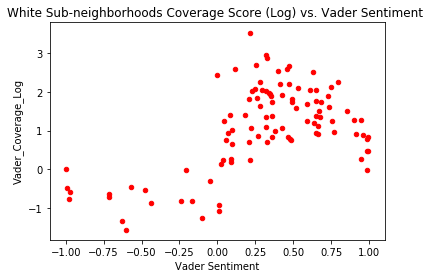

In [11]:
White_Neighborhoods_df.plot(kind='scatter',x='Vader Sentiment',y='Vader_Coverage_Log',color='red', title='White Sub-neighborhoods Coverage Score (Log) vs. Vader Sentiment ')
plt.show()

In [56]:
print(White_Neighborhoods_df['Vader_Coverage_Log'].mean())
print(White_Neighborhoods_df['Vader_Coverage_Log'].median())

1.077679538244433
1.2217722650241343


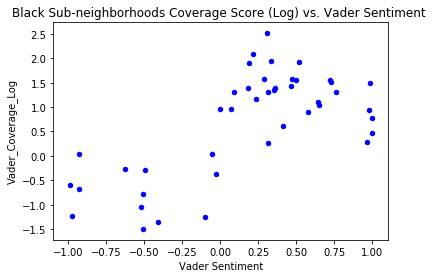

In [9]:
Black_Neighborhoods_df.plot(kind='scatter',x='Vader Sentiment',y='Vader_Coverage_Log',color='blue', title='Black Sub-neighborhoods Coverage Score (Log) vs. Vader Sentiment ')
plt.show()

In [57]:
print(Black_Neighborhoods_df['Vader_Coverage_Log'].mean())
print(Black_Neighborhoods_df['Vader_Coverage_Log'].median())

0.7660405023782336
1.0414913772349828


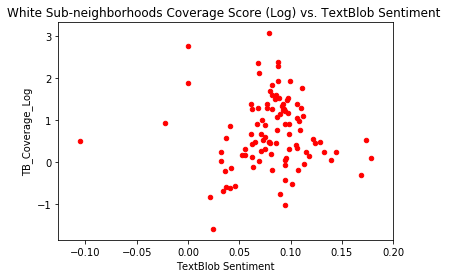

In [13]:
White_Neighborhoods_df.plot(kind='scatter',x='TextBlob Sentiment',y='TB_Coverage_Log',color='red', title='White Sub-neighborhoods Coverage Score (Log) vs. TextBlob Sentiment ')
plt.show()

In [58]:
print(White_Neighborhoods_df['TB_Coverage_Log'].mean())
print(White_Neighborhoods_df['TB_Coverage_Log'].median())

0.6990333018424731
0.5680102059346495


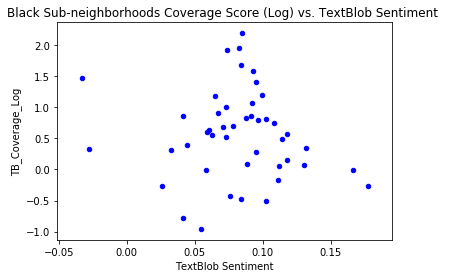

In [14]:
Black_Neighborhoods_df.plot(kind='scatter',x='TextBlob Sentiment',y='TB_Coverage_Log',color='blue', title='Black Sub-neighborhoods Coverage Score (Log) vs. TextBlob Sentiment ')
plt.show()

In [59]:
print(Black_Neighborhoods_df['TB_Coverage_Log'].mean())
print(Black_Neighborhoods_df['TB_Coverage_Log'].median())

0.5642617731046973
0.5762496182191746


In [15]:
White_Neighborhoods_df['Count'].sum()

38578

In [16]:
Black_Neighborhoods_df['Count'].sum()

7359

In [60]:
print(White_Neighborhoods_df['Vader Sentiment'].mean())
print(White_Neighborhoods_df['Vader Sentiment'].median())

0.2979002849918676
0.34239617647058845


In [61]:
print(Black_Neighborhoods_df['Vader Sentiment'].mean())
print(Black_Neighborhoods_df['Vader Sentiment'].median())

0.17814670256506793
0.3037804744525544


In [10]:
print(White_Neighborhoods_df['TextBlob Sentiment'].mean())
print(White_Neighborhoods_df['TextBlob Sentiment'].median())

0.08081940781167316
0.0854400702560917


In [11]:
print(Black_Neighborhoods_df['TextBlob Sentiment'].mean())
print(Black_Neighborhoods_df['TextBlob Sentiment'].median())

0.08139241860465117
0.08415800000000001


In [6]:

WList = ['Brighton', 'Allston', 'Fenway', 'Longwood Medical Area', 'Back Bay', 'Beacon Hill', 'West End', 'North End', 'Downtown', 'Charlestown', 'East Boston', 'South Boston', 'South Boston Waterfront', 'South End', 'Mission Hill', 'Dorchester', 'Jamaica Plain', 'Roslindale', 'West Roxbury']



In [7]:
rprint(Name_Search(WList)['Count'].sum())

23103


In [8]:
BList = ['Roxbury','Dorchester','Mattapan']

In [9]:
print(Name_Search(BList)['Count'].sum())

15170


In [10]:
OtherList = ['Harbor Islands', 'Hyde Park']

In [11]:
print(Name_Search(OtherList)['Count'].sum())

1338


In [72]:
Other_Neighborhoods_Unique = Neighborhoods_Sans_Black['Neighborhood'].unique()
Other_Neighborhoods_Unique

array(['Brighton', 'Allston', 'Fenway', 'Longwood Medical Area',
       'Back Bay', 'Beacon Hill', 'West End', 'North End', 'Downtown',
       'Charlestown', 'East Boston', 'South Boston',
       'South Boston Waterfront', 'South End', 'Roxbury', 'Mission Hill',
       'Jamaica Plain', 'Dorchester', 'Roslindale', 'West Roxbury',
       'Hyde Park', 'Harbor Islands', nan], dtype=object)

In [76]:
Major_Neighborhoods = ['Brighton', 'Allston', 'Fenway', 'Longwood Medical Area',
       'Back Bay', 'Beacon Hill', 'West End', 'North End', 'Downtown',
       'Charlestown', 'East Boston', 'South Boston',
       'South Boston Waterfront', 'South End', 'Roxbury', 'Mission Hill',
       'Jamaica Plain', 'Dorchester', 'Mattapan', 'Roslindale',
       'West Roxbury', 'Hyde Park', 'Harbor Islands']

In [77]:
print(Name_Search(Major_Neighborhoods)['Count'].sum())

30441


In [75]:
Un = Neighborhoods_df['Neighborhood'].unique()
Un

array(['Brighton', 'Allston', 'Fenway', 'Longwood Medical Area',
       'Back Bay', 'Beacon Hill', 'West End', 'North End', 'Downtown',
       'Charlestown', 'East Boston', 'South Boston',
       'South Boston Waterfront', 'South End', 'Roxbury', 'Mission Hill',
       'Jamaica Plain', 'Dorchester', 'Mattapan', 'Roslindale',
       'West Roxbury', 'Hyde Park', 'Harbor Islands', nan], dtype=object)

# Census Tracts Tables

In [17]:
Black_Census_Tracts = pd.read_csv('Black Census Tracts.csv')
Black_Census_Tracts

Census Tract#                     Zipcode  Neighborhood  \
0          801.00                02118, 02119       Roxbury   
1          803.00                       02119       Roxbury   
2          804.01         02118, 02119, 02120       Roxbury   
3          813.00                       02119       Roxbury   
4          815.00                       02119       Roxbury   
5          817.00                       02119       Roxbury   
6          818.00                       02119       Roxbury   
7          819.00                02119, 02121       Roxbury   
8          820.00                       02121       Roxbury   
9          821.00                       02121       Roxbury   
10         901.00                       02121    Dorchester   
11         902.00                       02121    Dorchester   
12         903.00                02121, 02125    Dorchester   
13         904.00         02119, 02121, 02125       Roxbury   
14         906.00                02119, 02125       Roxbury   
15         913.00                       02125    Dorchester   
16         914.00                       02125    Dorchester   
17         915.00                02122, 02125    Dorchester   
18         917.00                       02122    Dorchester   
19         918.00         02121, 02122, 02125    Dorchester   
20         919.00                02121, 02124    Dorchester   
21         920.00                02122, 02124    Dorchester   
22         923.00                       02124    Dorchester   
23         924.00                02121, 02124    Dorchester   
24        1001.00                02124, 02126    Dorchester   
25        1002.00                02124, 02126    Dorchester   
26        1003.00                02124, 02126    Dorchester   
27        1004.00                       02124    Dorchester   
28        1005.00                       02124    Dorchester   
29        1009.00                02124, 02126      Mattapan   
30        1010.01                       02126      Mattapan   
31        1010.02                       02126      Mattapan   
32        1011.01                       02126      Mattapan   
33        1011.02                       02126      Mattapan   
34        1102.01                       02131    Roslindale   
35        1304.06                02132, 02136  West Roxbury   
36        1401.06                       02131    Roslindale   
37        1403.00                       02136     Hyde Park   
38        1404.00         02126, 02131, 02136     Hyde Park   
39        9811.00  02124, 02126, 02130, 02131      Mattapan   

   US Geonames Sub-neigborhood  Total Population   Black  Black Proportion  \
0                          NaN              2690    1364          0.507063   
1                          NaN              2089    1546          0.740067   
2                          NaN              3265    1724          0.528025   
3                          NaN              5326    2726          0.511829   
4                      Roxbury              2616    1532          0.585627   
5                          NaN              4151    2849          0.686341   
6                          NaN              3489    2439          0.699054   
7                          NaN              3494    2496          0.714367   
8                          NaN              3409    2354          0.690525   
9                          NaN              5750    3974          0.691130   
10                         NaN              5148    3845          0.746892   
11                         NaN              2587    1755          0.678392   
12                         NaN              3469    2488          0.717210   
13                         NaN              4318    3289          0.761695   
14                         NaN              2599    1784          0.686418   
15                         NaN              2561    1597          0.623585   
16                         NaN              3165    1740          0.549763   
17              

In [19]:
Black_Census_Tracts = Black_Census_Tracts.sort_values('Black Proportion', ascending=False)
Black_Census_Tracts

Census Tract#                     Zipcode  Neighborhood  \
32        1011.01                       02126      Mattapan   
30        1010.01                       02126      Mattapan   
26        1003.00                02124, 02126    Dorchester   
33        1011.02                       02126      Mattapan   
31        1010.02                       02126      Mattapan   
24        1001.00                02124, 02126    Dorchester   
25        1002.00                02124, 02126    Dorchester   
22         923.00                       02124    Dorchester   
23         924.00                02121, 02124    Dorchester   
20         919.00                02121, 02124    Dorchester   
19         918.00         02121, 02122, 02125    Dorchester   
38        1404.00         02126, 02131, 02136     Hyde Park   
13         904.00         02119, 02121, 02125       Roxbury   
10         901.00                       02121    Dorchester   
1          803.00                       02119       Roxbury   
12         903.00                02121, 02125    Dorchester   
7          819.00                02119, 02121       Roxbury   
6          818.00                       02119       Roxbury   
9          821.00                       02121       Roxbury   
8          820.00                       02121       Roxbury   
14         906.00                02119, 02125       Roxbury   
5          817.00                       02119       Roxbury   
27        1004.00                       02124    Dorchester   
11         902.00                       02121    Dorchester   
28        1005.00                       02124    Dorchester   
21         920.00                02122, 02124    Dorchester   
15         913.00                       02125    Dorchester   
18         917.00                       02122    Dorchester   
4          815.00                       02119       Roxbury   
37        1403.00                       02136     Hyde Park   
16         914.00                       02125    Dorchester   
17         915.00                02122, 02125    Dorchester   
36        1401.06                       02131    Roslindale   
29        1009.00                02124, 02126      Mattapan   
39        9811.00  02124, 02126, 02130, 02131      Mattapan   
2          804.01         02118, 02119, 02120       Roxbury   
35        1304.06                02132, 02136  West Roxbury   
3          813.00                       02119       Roxbury   
0          801.00                02118, 02119       Roxbury   
34        1102.01                       02131    Roslindale   

   US Geonames Sub-neigborhood  Total Population   Black  Black Proportion  \
32                         NaN              3850    3581          0.930130   
30                         NaN              5978    5536          0.926062   
26                         NaN              4106    3709          0.903312   
33                         NaN              5137    4605          0.896438   
31                    Mattapan              6179    5270          0.852889   
24                         NaN              7140    5927          0.830112   
25                         NaN              3440    2815          0.818314   
22                         NaN              3392    2750          0.810731   
23                         NaN              6549    5239          0.799969   
20   Dorchester/ Mount Bowdoin              4194    3325          0.792799   
19                         NaN              3528    2776          0.786848   
38                         NaN              8961    6983          0.779266   
13                         NaN              4318    3289          0.761695   
10                         NaN              5148    3845          0.746892   
1                          NaN              2089    1546          0.740067   
12                         NaN              3469    2488          0.717210   
7                          NaN              3494    2496          0.714367   
6               

In [31]:
White_Census_Tracts = White_Census_Tracts.sort_values('Black Proportion', ascending=False)
White_Census_Tracts

Census Tract#       Zipcode   Neighborhood  \
54          507.00         02128    East Boston   
163        1402.01         02136      Hyde Park   
164        1402.02         02136      Hyde Park   
55          509.01         02128    East Boston   
179        9818.00  02130, 02215  Jamaica Plain   
..             ...           ...            ...   
66          608.00         02127   South Boston   
61          603.01         02127   South Boston   
42          401.00         02129    Charlestown   
37          301.00  02109, 02113      North End   
35          203.02  02108, 02114    Beacon Hill   

          US Geonames Sub-neigborhood  Total Population   Black  \
54                                NaN              5608    2432   
163                         Readville              2475     901   
164                         Farimount              6784    2430   
55                                NaN              4612    1617   
179                               NaN                26       9   
..                                ...               ...     ...   
66   Fort Independence / South Boston              4317      20   
61                                NaN              3655      16   
42                                NaN              2463       0   
37                                NaN              2334       0   
35                        Beacon Hill               980       0   

     Black Proportion  White  White Proportion  \
54           0.433666   5227          0.932061   
163          0.364040   1324          0.534949   
164          0.358196   3456          0.509434   
55           0.350607   4280          0.928014   
179          0.346154     17          0.653846   
..                ...    ...               ...   
66           0.004633   3748          0.868196   
61           0.004378   3542          0.969083   
42           0.000000   2419          0.982136   
37           0.000000   2205          0.944730   
35           0.000000    896          0.914286   

     American Indian & Alaska Native  ...  Male   Male Proportion  Female   \
54                                39  ...   3302         0.588802     2306   
163                                0  ...   1296         0.523636     1179   
164                                0  ...   3475         0.512235     3309   
55                                37  ...   2522         0.546834     2090   
179                                0  ...      4         0.153846       22   
..                               ...  ...    ...              ...      ...   
66                                61  ...   2048         0.474404     2269   
61                                 0  ...   1528         0.418057     2127   
42                                 0  ...    997         0.404791     1466   
37                                16  ...   1213         0.519709     1121   
35                                 0  ...    451         0.460204      529   

     Female Proportion         Lat       Long  \
54             0.411198  42.375357 -71.033271   
163            0.476364  42.237531 -71.130571   
164            0.487765  42.249518 -71.117543   
55             0.453166  42.381937 -71.029500   
179            0.846154  42.323121 -71.116882   
..                  ...        ...        ...   
66             0.525596  42.335403 -71.051493   
61             0.581943  42.333467 -71.036948   
42             0.595209  42.372998 -71.060150   
37             0.480291  42.366946 -71.056150   
35             0.539796  42.359344 -71.063996   

                 Primary Sub-Neighborhood     Secondary Sub-Neighborhood  \
54   Central Maverick Square/Paris Square                 Central Square   
163                              Ashcroft                 Fairmount Hill   
164                             Hyde Park                      Readville   
55                            Bunker Hill                        Chelsea   
179                      High Street Hill                            NaN   
..  

In [33]:
Neighborhoods_Sans_Black

Census Tract#       Zipcode   Neighborhood US Geonames Sub-neigborhood  \
0             1.00  02134, 02135       Brighton                         NaN   
1             2.01         02135       Brighton                         NaN   
2             2.02         02135       Brighton                         NaN   
3             3.01         02135       Brighton                         NaN   
4             3.02         02135       Brighton                         NaN   
..             ...           ...            ...                         ...   
176        9815.02         02151    East Boston                         NaN   
177        9816.00         02128    East Boston                         NaN   
178        9817.00         02116    Beacon Hill                         NaN   
179        9818.00  02130, 02215  Jamaica Plain                         NaN   
180        9901.01         02130            NaN                         NaN   

     Total Population   Black  Black Proportion  White  White Proportion  \
0                5324     311          0.058415   3315          0.622652   
1                3991     237          0.059384   3164          0.792784   
2                4272     263          0.061564   3031          0.709504   
3                2946     216          0.073320   2203          0.747794   
4                3469     359          0.103488   2346          0.676276   
..                ...     ...               ...    ...               ...   
176                 0       0          0.000000      0          0.000000   
177                 0       0          0.000000      0          0.000000   
178                 0       0          0.000000      0          0.000000   
179                26       9          0.346154     17          0.653846   
180                67      18          0.268657     49          0.731343   

     American Indian & Alaska Native  ...  Male   Male Proportion  Female   \
0                                  0  ...   2578         0.484222     2746   
1                                 17  ...   1800         0.451015     2191   
2                                  0  ...   2175         0.509129     2097   
3                                  0  ...   1650         0.560081     1296   
4                                 25  ...   1733         0.499568     1736   
..                               ...  ...    ...              ...      ...   
176                                0  ...      0         0.000000        0   
177                                0  ...      0         0.000000        0   
178                                0  ...      0         0.000000        0   
179                                0  ...      4         0.153846       22   
180                                0  ...     55         0.820896       12   

     Female Proportion         Lat       Long  Primary Sub-Neighborhood  \
0              0.515778  42.361485 -71.138588             Lower Allston   
1              0.548985  42.354066 -71.161168                Oak Square   
2              0.490871  42.352605 -71.154344                Oak Square   
3              0.439919  42.354144 -71.168827             Hunnwell Hill   
4              0.500432  42.347258 -71.167686                  Brighton   
..                  ...        ...        ...                       ...   
176            0.000000  42.396367 -71.004379                 Beachmont   
177            0.000000  42.388621 -70.993442            Orient Heights   
178            0.000000  42.355087 -71.065743         Downtown Crossing   
179            0.846154  42.323121 -71.116882          High Street Hill   
180            0.179104  42.329611 -70.949200                       NaN   

     Secondary Sub-Neighborhood  Teritriary Sub-Neighborhood(s)  \
0                       Allston                Packard's Corner   
1                      Brighton                  Hunnewell Hill   
2                      Brighton                         Allston   
3                    Oak Square      

In [43]:
Black_Census_Tracts_Filtered = Black_Census_Tracts[Black_Census_Tracts['Census Tract#','Neighborhood','Total Population',' Black','Black Proportion','Primary Sub-Neighborhood','Secondary Sub-Neighborhood','Teritriary Sub-Neighborhood(s)'
                                                    ,'T-Stop/Commuter Rail']]

Black_Census_Tracts_Filtered



KeyError: ('Census Tract#', 'Neighborhood', 'Total Population', ' Black', 'Black Proportion', 'Primary Sub-Neighborhood', 'Secondary Sub-Neighborhood', 'Teritriary Sub-Neighborhood(s)', 'T-Stop/Commuter Rail')

In [22]:
Black_Census_Tracts_Filtered = Black_Census_Tracts[['Census Tract#', 'Primary Sub-Neighborhood','Black Proportion',' Black','Total Population','Neighborhood'
                                                   ,'Secondary Sub-Neighborhood','Teritriary Sub-Neighborhood(s)',
                                                   'T-Stop/Commuter Rail']]
Black_Census_Tracts_Filtered.sort_values(by='Black Proportion', ascending=False)



Census Tract#            Primary Sub-Neighborhood  Black Proportion  \
133        1011.01                     Wellington Hill          0.930130   
131        1010.01                   Southern Mattapan          0.926062   
123        1003.00  West Codman Hill/ West Lower Mills          0.903312   
134        1011.02                     Washington Hill          0.896438   
132        1010.02                            Mattapan          0.852889   
121        1001.00                Franklin Field South          0.830112   
122        1002.00                Franklin Field South          0.818314   
119         923.00                   Dorcehster Center          0.810731   
120         924.00                Franklin Field South          0.799969   
115         919.00                          Dorchester          0.792799   
114         918.00          Bowdoin North/Mount Bodoin          0.786848   
166        1404.00            West Street/River Street          0.779266   
102         904.00               Dudley/Brunswick King          0.761695   
99          901.00                Franklin Field South          0.746892   
82          803.00                       Nubian Square          0.740067   
101         903.00               Dudley/Brunswick King          0.717210   
96          819.00                             Roxbury          0.714367   
95          818.00                       Nubian Square          0.699054   
98          821.00                          Grove Hall          0.691130   
97          820.00                             Roxbury          0.690525   
103         906.00                       Nubian Square          0.686418   
94          817.00                       Nubian Square          0.686341   
124        1004.00  West Codman Hill/ West Lower Mills          0.680694   
100         902.00          Bowdoin North/Mount Bodoin          0.678392   
125        1005.00                       Codman Square          0.656824   
116         920.00                          Dorchester          0.642603   
109         913.00                      Upham's Corner          0.623585   
113         917.00                  Meeting House Hill          0.617610   
93          815.00                     Washington Park          0.585627   
165        1403.00                           Hyde Park          0.581194   
110         914.00               Dudley/Brunswick King          0.549763   
111         915.00                          Jones Hill          0.547940   
161        1401.06      Metropolitan Hill/Beech Street          0.546453   
130        1009.00                         Milton Hill          0.537972   
171        9811.00             Forest Hills/Woodbourne          0.529787   
83          804.01                       Lower Roxbury          0.528025   
158        1304.06                           Hyde Park          0.515209   
91          813.00                    Washington Park           0.511829   
81          801.00                       Lower Roxbury          0.507063   
136        1102.01              Washington /Mount Hope          0.501978   

      Black  Total Population  Neighborhood  \
133    3581              3850      Mattapan   
131    5536              5978      Mattapan   
123    3709              4106    Dorchester   
134    4605              5137      Mattapan   
132    5270              6179      Mattapan   
121    5927              7140    Dorchester   
122    2815              3440    Dorchester   
119    2750              3392    Dorchester   
120    5239              6549    Dorchester   
115    3325              4194    Dorchester   
114    2776              3528    Dorchester   
166    6983              8961     Hyde Park   
102    3289              4318       Roxbury   
99     3845              5148    Dorchester   
82     1546              2089       Roxbury   
101    2488              3469    Dorchester   
96     2496              3494       Roxbury   
95     2439              3489       Roxbur

In [42]:

for names in Black_Census_Tracts.columns:
    print(names)

Census Tract#
Zipcode
Neighborhood
US Geonames Sub-neigborhood
Total Population
 Black
Black Proportion
White
White Proportion
American Indian & Alaska Native
American Indian & Alaska Native Proportion
Asian
Asian Proportion
Male 
Male Proportion
Female 
Female Proportion 
Lat
Long
Primary Sub-Neighborhood
Secondary Sub-Neighborhood
Teritriary Sub-Neighborhood(s)
T-Stop/Commuter Rail
